In [1]:
from collections import OrderedDict
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.25.0 / PyTorch 2.9.1+cu128


In [2]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
NUM_CLIENTS = 3
NUM_ROUNDS = 200
epochs = 5
EPOCHS_PER_ROUND=5
BATCH_SIZE = 32
DATASET_PATH = "Dataset"


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom dataset path - point directly to where CROPPED folders are
from torch.utils.data import Dataset
from PIL import Image

class CroppedImageDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic',
                        'Parabasal', 'Superficial-Intermediate']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Load images from CROPPED folders
        class_folders = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic',
                        'im_Parabasal', 'im_Superficial-Intermediate']

        for class_folder in class_folders:
            # Path: root/im_ClassName/im_ClassName/CROPPED/
            cropped_folder = os.path.join(root_path, class_folder, class_folder, 'CROPPED')

            # Get class name without 'im_' prefix
            class_name = class_folder.replace('im_', '')
            class_idx = self.class_to_idx[class_name]

            # Check if CROPPED folder exists
            if os.path.exists(cropped_folder):
                # Get all .bmp files
                for img_name in os.listdir(cropped_folder):
                    if img_name.endswith('.bmp'):
                        img_path = os.path.join(cropped_folder, img_name)
                        self.samples.append((img_path, class_idx))

        print(f"Loaded {len(self.samples)} images from CROPPED folders")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 1. Load SIPaKMeD using custom dataset (NO transform initially)
dataset = CroppedImageDataset(root_path=DATASET_PATH, transform=None)
print("Classes:", dataset.classes)
print(f"Total dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

# 2. Create GLOBAL train/validation split (80/20) BEFORE partitioning
print("\n" + "="*60)
print("CREATING GLOBAL TRAIN/VALIDATION SPLIT")
print("="*60)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size   # 20% for global validation
train_dataset_raw, val_dataset_raw = random_split(
    dataset, [train_size, val_size]
)
print(f"Training samples (to be partitioned): {len(train_dataset_raw)}")
print(f"Global validation samples (held-out): {len(val_dataset_raw)}")

# Wrapper class to apply transforms to a Subset
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        # Get reference to the base dataset
        self.base_dataset = subset.dataset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Get the actual index in the base dataset
        actual_idx = self.subset.indices[idx]
        # Get image path and label from base dataset
        img_path, label = self.base_dataset.samples[actual_idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Apply train_transform to training set
train_dataset = TransformSubset(train_dataset_raw, transform=train_transform)

# Apply val_transform to validation set
global_val_dataset = TransformSubset(val_dataset_raw, transform=val_transform)

# Create global validation DataLoader (used by ALL clients)
global_valloader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global validation DataLoader created with {len(global_valloader)} batches")

# 3. Partition ONLY the training data among clients (IID)
print("\n" + "="*60)
print("PARTITIONING TRAINING DATA AMONG CLIENTS (IID)")
print("="*60)

def partition_dataset(dataset, num_clients=NUM_CLIENTS):
    """
    Partition dataset into IID chunks for clients
    """
    data_per_client = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    partitions = []

    for i in range(num_clients):
        start = i * data_per_client
        end = (i+1) * data_per_client if i != num_clients-1 else len(dataset)
        client_indices = indices[start:end]
        partitions.append(Subset(dataset, client_indices))

    return partitions

# Partition the training data (not the full dataset!)
partitions = partition_dataset(train_dataset, NUM_CLIENTS)

# 4. Each client gets its own DataLoader for TRAINING ONLY
def load_client_train_data(partition_id: int):
    """
    Returns only training DataLoader for a client
    (No local validation split anymore)
    """
    partition = partitions[partition_id]
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True)
    return trainloader

# 5. Verification and Visualization
print("\n" + "="*60)
print("VERIFICATION AND VISUALIZATION")
print("="*60)
# Example: Get training data for client 0
trainloader = load_client_train_data(0)
print(f"Client 0 training samples: {len(trainloader.dataset)}")
# Show a batch from training
train_batch = next(iter(trainloader))
train_images, train_labels = train_batch
print(f"Training batch shape: {train_images.shape}")
# Show a batch from global validation
val_batch = next(iter(global_valloader))
val_images, val_labels = val_batch
print(f"Global validation batch shape: {val_images.shape}")


Loaded 4049 images from CROPPED folders
Classes: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']
Total dataset size: 4049
Number of classes: 5

CREATING GLOBAL TRAIN/VALIDATION SPLIT
Training samples (to be partitioned): 3239
Global validation samples (held-out): 810
Global validation DataLoader created with 26 batches

PARTITIONING TRAINING DATA AMONG CLIENTS (IID)

VERIFICATION AND VISUALIZATION
Client 0 training samples: 1079
Training batch shape: torch.Size([32, 3, 128, 128])


Global validation batch shape: torch.Size([32, 3, 128, 128])


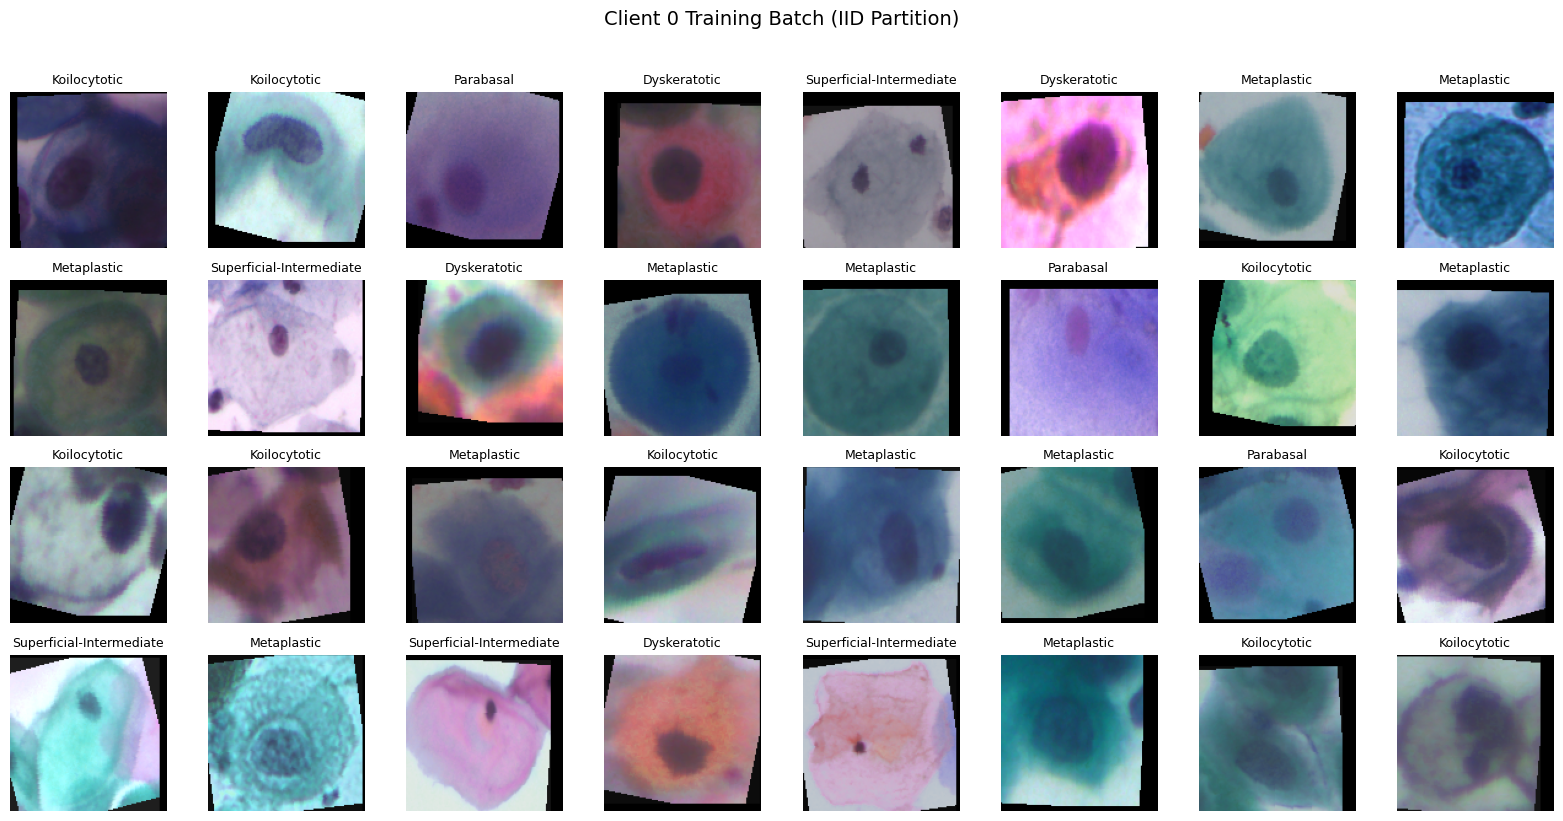

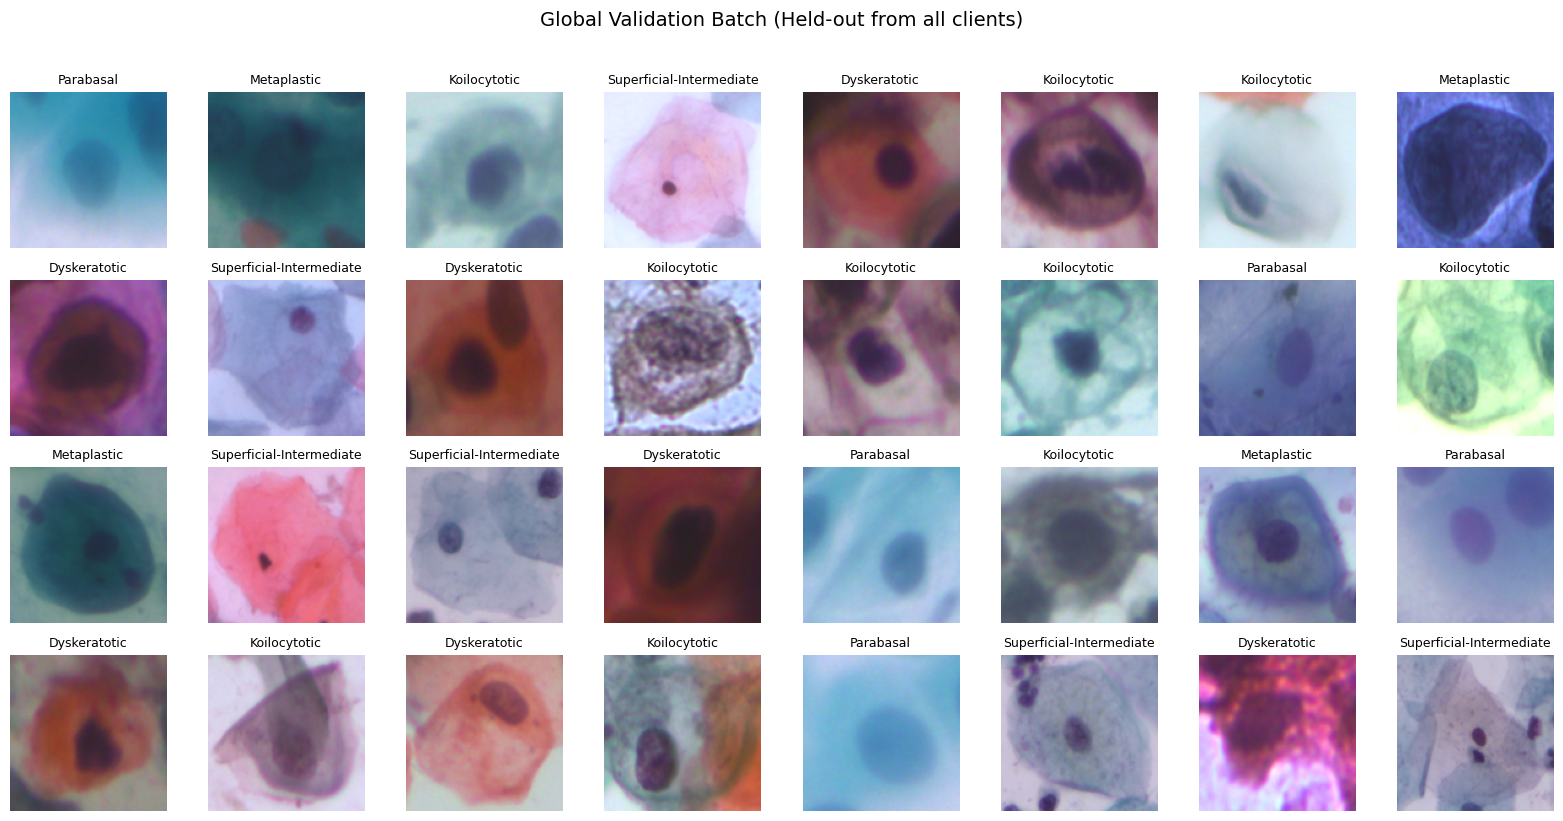

In [5]:
# 6. Create visualization function
def visualize_batch(images, labels, dataset_classes, title):
    """Visualize a batch of images"""
    # Convert for matplotlib
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    images_np = (images_np * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]))  # denormalize
    images_np = np.clip(images_np, 0, 1)

    fig, axs = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle(title, fontsize=14, y=1.02)

    for i, ax in enumerate(axs.flat):
        if i < len(images_np):
            ax.imshow(images_np[i])
            ax.set_title(f"{dataset_classes[labels[i].item()]}", fontsize=9)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize training batch (Client 0)
visualize_batch(train_images[:32], train_labels[:32], dataset.classes,
                "Client 0 Training Batch (IID Partition)")

# Visualize global validation batch
visualize_batch(val_images[:32], val_labels[:32], dataset.classes,
                "Global Validation Batch (Held-out from all clients)")

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, reduced, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(reduced, channels, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.gap(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

class ConvResidualFusion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Conv path
        self.conv_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Residual path
        self.res_path = ResidualBlock(in_channels, out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv_out = self.conv_path(x)
        res_out  = self.res_path(x)

        out = conv_out + res_out
        out = self.relu(out)
        return out

class CCanNet(nn.Module):
    """Simplified version with less overfitting"""
    def __init__(self, num_classes=5, dropout=0.5):  # Increased dropout
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.se = SEBlock(32, reduction=16)
        self.fusion1 = ConvResidualFusion(32, 64)
        self.fusion2 = ConvResidualFusion(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Simplified classifier with more dropout
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.se(x)
        x = self.fusion1(x)
        x = self.pool(x)
        x = self.fusion2(x)
        x = self.pool(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy

In [8]:
# # 2. Use MUCH smaller learning rate
# import math
# def get_lr_for_round(round_num):
#     initial_lr = 0.001  # Lower initial LR
#     min_lr = 0.00001
#     max_lr = 0.002  # Lower max LR
#     warmup_rounds = 5  # Longer warmup
#     total_rounds = NUM_ROUNDS

#     if round_num <= warmup_rounds:
#         return (max_lr / warmup_rounds) * round_num
#     else:
#         progress = (round_num - warmup_rounds) / (total_rounds - warmup_rounds)
#         cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
#         return min_lr + (max_lr - min_lr) * cosine_decay

# # 3. Update your training with gradient clipping
# def train_safe(net, trainloader, epochs=1, lr=0.00005, max_grad_norm=1.0):
#     """Safe training with gradient clipping"""
#     net.train()
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#     optimizer = torch.optim.Adam(
#         filter(lambda p: p.requires_grad, net.parameters()),
#         lr=lr,
#         weight_decay=1e-4,  # Add weight decay
#     )

#     running_loss = 0.0
#     running_correct = 0
#     total_samples = 0

#     for epoch in range(epochs):
#         for images, labels in trainloader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)

#             optimizer.zero_grad()
#             outputs = net(images)
#             loss = criterion(outputs, labels)
#             loss.backward()

#             # CRITICAL: Gradient clipping
#             torch.nn.utils.clip_grad_norm_(
#                 net.parameters(),
#                 max_norm=max_grad_norm,
#                 norm_type=2
#             )

#             optimizer.step()

#             running_loss += loss.item() * labels.size(0)
#             running_correct += (outputs.argmax(dim=1) == labels).sum().item()
#             total_samples += labels.size(0)

#     if total_samples == 0:
#         return 0.0, 0.0

#     avg_loss = running_loss / total_samples
#     avg_acc = running_correct / total_samples

#     return avg_loss, avg_acc

In [9]:
# CRITICAL FIX: The problem is BatchNorm running statistics aren't being properly handled
# When you call set_parameters(), you're only updating weights, NOT BatchNorm running_mean/running_var

def set_parameters(net, parameters: list[np.ndarray]):
    """Set trainable model parameters from a list of numpy arrays."""
    # CRITICAL FIX: Only set trainable parameters, preserve BatchNorm buffers
    trainable_params = [p for p in net.parameters() if p.requires_grad]

    if len(parameters) != len(trainable_params):
        print(f"Warning: Parameter mismatch. Model has {len(trainable_params)} trainable params, "
              f"received {len(parameters)} parameters.")
        if len(parameters) == 0:
            print("Using current model parameters (no update)")
            return net

    # Update trainable parameters
    for model_param, new_param in zip(trainable_params, parameters):
        model_param.data.copy_(torch.tensor(new_param, dtype=model_param.dtype))

    return net


# BETTER SOLUTION: Include BatchNorm statistics in parameter exchange
def get_parameters_with_bn(net) -> list[np.ndarray]:
    """Get model parameters including BatchNorm running statistics."""
    params = []

    # Add trainable parameters
    for param in net.parameters():
        if param.requires_grad:
            params.append(param.detach().cpu().numpy())

    # Add BatchNorm buffers (running_mean, running_var, num_batches_tracked)
    for name, buffer in net.named_buffers():
        if 'running_mean' in name or 'running_var' in name:
            params.append(buffer.detach().cpu().numpy())

    return params


def set_parameters_with_bn(net, parameters: list[np.ndarray]):
    """Set model parameters including BatchNorm running statistics."""
    param_idx = 0

    # Set trainable parameters
    for param in net.parameters():
        if param.requires_grad:
            param.data.copy_(torch.tensor(parameters[param_idx], dtype=param.dtype))
            param_idx += 1

    # Set BatchNorm buffers
    for name, buffer in net.named_buffers():
        if 'running_mean' in name or 'running_var' in name:
            if param_idx < len(parameters):
                buffer.data.copy_(torch.tensor(parameters[param_idx], dtype=buffer.dtype))
                param_idx += 1

    return net

In [10]:
import torch.optim as optim
import torch.nn as nn
from flwr.common import Context
from flwr.client import Client

In [11]:
class FlowerClient(NumPyClient):
    def __init__(self, client_id: int, trainloader, net, weight_decay=1e-5 , lr=0.001):
        self.client_id = client_id
        self.trainloader = trainloader
        self.net = net
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.net.to(self.device)

        # Lower learning rate with better optimizer settings
        self.optimizer = optim.AdamW(
            self.net.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=(0.9, 0.999)
        )

        self.weight_decay = weight_decay
        self.lr = lr
        self.train_history = []
        self.val_history = []

    def get_parameters(self, config):
        """Return model parameters INCLUDING BatchNorm statistics."""
        return get_parameters_with_bn(self.net)

    def fit(self, parameters, config):
        """Train the model on local data"""
        # CRITICAL: Use the new function that handles BatchNorm
        set_parameters_with_bn(self.net, parameters)
        self.net.to(self.device)

        # CRITICAL: Set to training mode BEFORE training
        self.net.train()

        lr = config.get("lr", self.lr)
        local_epochs = config.get("epochs", 3)

        train_loss, train_acc = self._train_with_lr(
            self.net, self.trainloader, lr, self.weight_decay, local_epochs
        )

        updated_params = self.get_parameters(config)
        num_examples = len(self.trainloader.dataset)

        client_metrics = {
            "client_id": self.client_id,
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
            "learning_rate": lr,
            "num_examples": num_examples,
        }

        return updated_params, num_examples, client_metrics

    def evaluate(self, parameters, config):
        """Evaluate the model on global validation set"""
        # CRITICAL: Use the new function that handles BatchNorm
        set_parameters_with_bn(self.net, parameters)
        self.net.to(self.device)

        # CRITICAL: Set to evaluation mode BEFORE evaluation
        self.net.eval()

        # VERIFY MODEL IS IN EVAL MODE
        is_training = self.net.training
        print(f"  [Client {self.client_id}] Model in training mode: {is_training}")

        val_loss, val_acc = self._evaluate(self.net, global_valloader)
        num_examples = len(global_valloader.dataset)

        val_metrics = {
            "client_id": self.client_id,
            "val_loss": float(val_loss),
            "val_accuracy": float(val_acc),
            "num_examples": num_examples
        }

        return float(val_loss), num_examples, val_metrics

    def _train_with_lr(self, net, trainloader, lr, weight_decay, epochs):
        """Train with specific learning rate"""
        net.train()  # Ensure training mode
        criterion = nn.CrossEntropyLoss()

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            param_group['weight_decay'] = weight_decay

        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_correct = 0
            epoch_total = 0

            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                self.optimizer.step()

                batch_size = labels.size(0)
                epoch_loss += loss.item() * batch_size
                epoch_correct += (outputs.argmax(dim=1) == labels).sum().item()
                epoch_total += batch_size

            if epoch_total > 0:
                epoch_avg_loss = epoch_loss / epoch_total
                epoch_avg_acc = epoch_correct / epoch_total
                print(f"    Client {self.client_id} Epoch {epoch+1}/{epochs}: "
                      f"Loss={epoch_avg_loss:.4f}, Acc={epoch_avg_acc:.4f}")

            running_loss += epoch_loss
            running_correct += epoch_correct
            total_samples += epoch_total

        if total_samples == 0:
            return 0.0, 0.0

        return running_loss / total_samples, running_correct / total_samples

    def _evaluate(self, net, val_loader):
        """Evaluate on validation set"""
        net.eval()
        criterion = nn.CrossEntropyLoss()

        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = net(images)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                running_loss += loss.item() * batch_size
                running_correct += (outputs.argmax(dim=1) == labels).sum().item()
                total_samples += batch_size

        if total_samples == 0:
            return 0.0, 0.0

        return running_loss / total_samples, running_correct / total_samples


In [12]:
# import math
# def get_lr_for_round(round_num):
#     initial_lr = 0.001  # Lower initial LR
#     min_lr = 0.00001
#     max_lr = 0.002  # Lower max LR
#     warmup_rounds = 5  # Longer warmup
#     total_rounds = NUM_ROUNDS

#     if round_num <= warmup_rounds:
#         return (max_lr / warmup_rounds) * round_num
#     else:
#         progress = (round_num - warmup_rounds) / (total_rounds - warmup_rounds)
#         cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
#         return min_lr + (max_lr - min_lr) * cosine_decay


def get_lr_for_round(round_num):

    if round_num <= 10:
        return 0.005  # Rounds 1-10: Initial warm-up phase
    elif round_num <= 40:
        return 0.003  # Rounds 11-40: Early training
    elif round_num <= 80:
        return 0.001  # Rounds 41-80: Mid training
    elif round_num <= 120:
        return 0.0005  # Rounds 81-120: Late training
    elif round_num <= 160:
        return 0.0002  # Rounds 121-160: Fine-tuning
    else:
        return 0.0001  # Rounds 161-200: Final convergence


In [13]:
def get_initial_parameters():
    """Get initial parameters including BatchNorm statistics."""
    model = CCanNet(num_classes=5, dropout= 0.3)
    model = model.to(DEVICE)

    # CRITICAL: Initialize BatchNorm properly by doing a forward pass
    model.train()
    dummy_input = torch.randn(1, 3, 128, 128).to(DEVICE)

    initial_params = get_parameters_with_bn(model)

    from flwr.common import ndarrays_to_parameters
    return ndarrays_to_parameters(initial_params)

In [14]:
from flwr.common import Context
from flwr.client import Client

def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    cid = int(partition_id)
    trainloader = load_client_train_data(cid)

    # Use simpler model with higher dropout
    model = CCanNet(num_classes=5)
    model = model.to(DEVICE)

    return FlowerClient(
        client_id=cid,
        trainloader=trainloader,
        net=model,
        weight_decay = 1e-5 ,  # Increased weight decay
        lr=0.005
    ).to_client()

In [15]:
print("\n" + "="*60)
print("DIAGNOSTIC: Check BatchNorm behavior")
print("="*60)
test_model = CCanNet(num_classes=5, dropout=0.3).to(DEVICE)

# Training mode
test_model.train()
# print(f"Model in training mode: {test_model.training}")
# print(f"First BN layer training: {test_model.initial[1].training}")

# Eval mode
test_model.eval()
# print(f"Model in eval mode: {not test_model.training}")
# print(f"First BN layer in eval: {not test_model.initial[1].training}")
# print("="*60 + "\n")


DIAGNOSTIC: Check BatchNorm behavior


CCanNet(
  (initial): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (se): SEBlock(
    (gap): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=32, out_features=2, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=2, out_features=32, bias=True)
    (sigmoid): Sigmoid()
  )
  (fusion1): ConvResidualFusion(
    (conv_path): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res_path): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
from flwr.client import ClientApp

# Wrap the client function into a ClientApp
client = ClientApp(client_fn=client_fn)

In [17]:
from flwr.simulation import run_simulation

# Configure resources per client
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# Define number of rounds


In [18]:
from typing import List, Tuple, Dict
# Global storage for per-client metrics
per_client_train_metrics = []  # List of lists: per_round[client_id] = metrics
per_client_val_metrics = []    # Same for validation

def aggregate_train_metrics_with_client_tracking(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    """
    Enhanced aggregation that stores per-client metrics
    """
    global per_client_train_metrics

    # Debug print
    print(f"\nDEBUG [Round {len(per_client_train_metrics)+1}] Training metrics from clients:")

    # Initialize storage for this round
    round_metrics = {}

    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_train_loss = 0.0
        avg_train_acc = 0.0
    else:
        # Calculate weighted averages
        weighted_loss = 0.0
        weighted_acc = 0.0

        for n, m in metrics:
            client_id = m.get("client_id", -1)
            client_loss = m.get("train_loss", 0.0)
            client_acc = m.get("train_accuracy", 0.0)
            client_lr = m.get("learning_rate", 1e-4)

            weighted_loss += n * client_loss
            weighted_acc += n * client_acc

            # Store per-client metrics
            if client_id != -1:
                if client_id not in round_metrics:
                    round_metrics[client_id] = []
                round_metrics[client_id].append({
                    "round": len(per_client_train_metrics) + 1,
                    "loss": client_loss,
                    "accuracy": client_acc,
                    "learning_rate": client_lr,
                    "samples": n
                })

            print(f"  Client {client_id}: loss={client_loss:.4f}, acc={client_acc:.4f}, "
                  f"lr={client_lr:.6f}, samples={n}")

        avg_train_loss = weighted_loss / total_examples
        avg_train_acc = weighted_acc / total_examples

    # Store round metrics
    per_client_train_metrics.append(round_metrics)

    # Return aggregated metrics for the strategy
    return {
        "train_loss": avg_train_loss,
        "train_accuracy": avg_train_acc,
        "round": len(per_client_train_metrics)
    }

def weighted_average_with_client_tracking(metrics):
    """
    Enhanced validation aggregation with per-client tracking
    """
    global per_client_val_metrics

    round_num = len(per_client_val_metrics) + 1
    print(f"\nDEBUG [Round {round_num}] Validation metrics from clients:")

    # Initialize storage for this round
    round_val_metrics = {}

    total_examples = sum(n for n, _ in metrics)

    if total_examples == 0:
        return {"accuracy": 0.0, "loss": 0.0}

    weighted_acc = 0.0
    weighted_loss = 0.0

    for n, m in metrics:
        client_id = m.get("client_id", -1)
        client_acc = m.get("val_accuracy", m.get("accuracy", 0.0))
        client_loss = m.get("val_loss", m.get("loss", 0.0))

        weighted_acc += n * client_acc
        weighted_loss += n * client_loss

        # Store per-client validation metrics
        if client_id != -1:
            if client_id not in round_val_metrics:
                round_val_metrics[client_id] = []
            round_val_metrics[client_id].append({
                "round": round_num,
                "loss": client_loss,
                "accuracy": client_acc,
                "samples": n
            })

        print(f"  Client {client_id}: loss={client_loss:.4f}, acc={client_acc:.4f}, samples={n}")

    avg_acc = weighted_acc / total_examples
    avg_loss = weighted_loss / total_examples

    # Store round metrics
    per_client_val_metrics.append(round_val_metrics)

    return {"accuracy": avg_acc, "loss": avg_loss}

In [19]:
# from flwr.server.strategy import FedAvg

# class FedAvgSaveParams(FedAvg):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.final_parameters = None

#     def aggregate_fit(self, server_round, results, failures):
#         aggregated = super().aggregate_fit(server_round, results, failures)
#         if aggregated is not None:
#             self.final_parameters = aggregated[0]  # Parameters object
#         return aggregated

In [20]:
# Simpler version - just track parameters
class FedAvgTrackParams(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_parameters = None
        self.all_parameters = []  # Store parameters from each round

    def aggregate_fit(self, server_round, results, failures):
        aggregated = super().aggregate_fit(server_round, results, failures)

        if aggregated is not None:
            parameters, metrics = aggregated
            self.final_parameters = parameters
            self.all_parameters.append({
                'round': server_round,
                'parameters': parameters,
                'loss': metrics.get('train_loss', 0),
                'accuracy': metrics.get('train_accuracy', 0)
            })
            print(f"DEBUG: Tracked parameters for round {server_round}")

        return aggregated

# Update your strategy:
strategy = FedAvgTrackParams(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=3,
    evaluate_metrics_aggregation_fn=weighted_average_with_client_tracking,
    fit_metrics_aggregation_fn=aggregate_train_metrics_with_client_tracking,
    on_fit_config_fn=lambda rnd: {
        "lr": get_lr_for_round(round_num = NUM_ROUNDS),  # Dynamic learning rate
        "epochs": epochs,
        "round": rnd
    },
    on_evaluate_config_fn=lambda rnd: {"final_round": rnd == NUM_ROUNDS}
)


In [21]:
from flwr.server import ServerApp, ServerAppComponents
from flwr.server import ServerConfig

def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

# Create new server instance
server = ServerApp(server_fn=server_fn)

In [22]:
# Run the federated learning simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=200, no round_timeout


INFO :      


INFO :      [INIT]


INFO :      Requesting initial parameters from one random client


/home/t510557/quickstart-pytorch1/.venv/lib/python3.10/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


INFO :      Received initial parameters from one random client


INFO :      Starting evaluation of initial global parameters


INFO :      Evaluation returned no results (`None`)


INFO :      


INFO :      [ROUND 1]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=1.3140, Acc=0.4856


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=1.1248, Acc=0.6033


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=1.0728, Acc=0.6089


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.9846, Acc=0.6497


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=1.0050, Acc=0.6376


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=1.3224, Acc=0.4903


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=1.1496, Acc=0.5848


(pid=gcs_server) [2026-02-02 09:49:17,375 E 35746 35746] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(raylet) [2026-02-02 09:49:18,466 E 35905 35905] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=1.0837, Acc=0.6089


(pid=35998) [2026-02-02 09:49:20,081 E 35998 36284] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


[2026-02-02 09:49:20,462 E 35646 35994] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=1.1049, Acc=0.5922


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=1.0154, Acc=0.6404


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=1.3354, Acc=0.4681


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=1.1343, Acc=0.5671


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=1.0450, Acc=0.6466


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=1.0446, Acc=0.6216


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.9933, Acc=0.6559

DEBUG [Round 1] Training metrics from clients:
  Client 1: loss=1.1352, acc=0.5833, lr=0.000100, samples=1079
  Client 2: loss=1.1105, acc=0.5919, lr=0.000100, samples=1081
  Client 0: loss=1.1002, acc=0.5970, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 1


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 2]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 1] Validation metrics from clients:
  Client 2: loss=0.8757, acc=0.7062, samples=810
  Client 1: loss=0.8757, acc=0.7062, samples=810
  Client 0: loss=0.8757, acc=0.7062, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=1.0079, Acc=0.6302


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.9619, Acc=0.6395


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.9093, Acc=0.6886


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.9089, Acc=0.6914


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.8618, Acc=0.7034


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=1.0165, Acc=0.6506


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=1.0011, Acc=0.6664


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.9988, Acc=0.6469


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.9683, Acc=0.6664


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.9528, Acc=0.6719


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.9809, Acc=0.6660


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.9548, Acc=0.6670


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.9259, Acc=0.6772


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.9167, Acc=0.6735


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.9183, Acc=0.6910

DEBUG [Round 2] Training metrics from clients:
  Client 2: loss=0.9393, acc=0.6749, lr=0.000100, samples=1081
  Client 1: loss=0.9875, acc=0.6604, lr=0.000100, samples=1079
  Client 0: loss=0.9300, acc=0.6706, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 2


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 3]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 2] Validation metrics from clients:
  Client 1: loss=0.8647, acc=0.6815, samples=810
  Client 0: loss=0.8647, acc=0.6815, samples=810
  Client 2: loss=0.8647, acc=0.6815, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.8487, Acc=0.7173


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.8720, Acc=0.6877


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.8300, Acc=0.7108


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.8353, Acc=0.7220


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.8086, Acc=0.7266


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.9415, Acc=0.6534


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.9420, Acc=0.6682


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.8702, Acc=0.7053


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.8699, Acc=0.6914


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.8727, Acc=0.6951


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.8739, Acc=0.6883


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.8925, Acc=0.6910


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.8564, Acc=0.7142


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.8501, Acc=0.7040


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.8338, Acc=0.7280

DEBUG [Round 3] Training metrics from clients:
  Client 1: loss=0.8993, acc=0.6827, lr=0.000100, samples=1079
  Client 0: loss=0.8389, acc=0.7129, lr=0.000100, samples=1079
  Client 2: loss=0.8613, acc=0.7051, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 3
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 4]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 3] Validation metrics from clients:
  Client 1: loss=0.7831, acc=0.7148, samples=810
  Client 2: loss=0.7831, acc=0.7148, samples=810
  Client 0: loss=0.7831, acc=0.7148, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.8163, Acc=0.7210


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.7828, Acc=0.7201


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.7671, Acc=0.7340


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.7619, Acc=0.7507


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.7692, Acc=0.7266


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.8521, Acc=0.7081


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.8466, Acc=0.6923


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.8312, Acc=0.7118


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.8348, Acc=0.7192


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.8125, Acc=0.7183


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.8171, Acc=0.7216


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.8138, Acc=0.7160


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.7946, Acc=0.7299


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.7692, Acc=0.7447


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.7948, Acc=0.7299

DEBUG [Round 4] Training metrics from clients:
  Client 1: loss=0.8354, acc=0.7099, lr=0.000100, samples=1079
  Client 0: loss=0.7795, acc=0.7305, lr=0.000100, samples=1079
  Client 2: loss=0.7979, acc=0.7284, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 4


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 5]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 4] Validation metrics from clients:
  Client 2: loss=0.6918, acc=0.7580, samples=810
  Client 0: loss=0.6918, acc=0.7580, samples=810
  Client 1: loss=0.6918, acc=0.7580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.7565, Acc=0.7220


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.7619, Acc=0.7433


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.7636, Acc=0.7414


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.7371, Acc=0.7461


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.7148, Acc=0.7498


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.7925, Acc=0.7312


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.8283, Acc=0.7136


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.8053, Acc=0.7164


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.7783, Acc=0.7247


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.7337, Acc=0.7507


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.7706, Acc=0.7493


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.7692, Acc=0.7317


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.7303, Acc=0.7419


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.7428, Acc=0.7484


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.7369, Acc=0.7650

DEBUG [Round 5] Training metrics from clients:
  Client 0: loss=0.7468, acc=0.7405, lr=0.000100, samples=1079
  Client 1: loss=0.7876, acc=0.7273, lr=0.000100, samples=1079
  Client 2: loss=0.7500, acc=0.7473, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 5


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 6]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 5] Validation metrics from clients:
  Client 0: loss=0.6534, acc=0.7642, samples=810
  Client 2: loss=0.6534, acc=0.7642, samples=810
  Client 1: loss=0.6534, acc=0.7642, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.7354, Acc=0.7424


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.7301, Acc=0.7488


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.6991, Acc=0.7581


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.7204, Acc=0.7609


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.7128, Acc=0.7553


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.8172, Acc=0.7183


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.7888, Acc=0.7359


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.7637, Acc=0.7396


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.7620, Acc=0.7285


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.7267, Acc=0.7563


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.7502, Acc=0.7419


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.7384, Acc=0.7539


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.7391, Acc=0.7419


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.7097, Acc=0.7632


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 6] Training metrics from clients:
  Client 2: loss=0.7286, acc=0.7517, lr=0.000100, samples=1081
  Client 0: loss=0.7196, acc=0.7531, lr=0.000100, samples=1079
  Client 1: loss=0.7717, acc=0.7357, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 6
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.7057, Acc=0.7576
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 7]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 6] Validation metrics from clients:
  Client 1: loss=0.6267, acc=0.7790, samples=810
  Client 0: loss=0.6267, acc=0.7790, samples=810
  Client 2: loss=0.6267, acc=0.7790, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6836, Acc=0.7868


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.6798, Acc=0.7766


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.6788, Acc=0.7665


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.6924, Acc=0.7794


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.6625, Acc=0.7711


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.7422, Acc=0.7368


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.7587, Acc=0.7322


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.7388, Acc=0.7507


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.7392, Acc=0.7535


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.7158, Acc=0.7498


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.7182, Acc=0.7530


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.6876, Acc=0.7687


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.6793, Acc=0.7687


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.6793, Acc=0.7604


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.6570, Acc=0.7891

DEBUG [Round 7] Training metrics from clients:
  Client 1: loss=0.7390, acc=0.7446, lr=0.000100, samples=1079
  Client 2: loss=0.6843, acc=0.7680, lr=0.000100, samples=1081
  Client 0: loss=0.6794, acc=0.7761, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 7


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 8]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 7] Validation metrics from clients:
  Client 2: loss=0.6023, acc=0.7963, samples=810
  Client 1: loss=0.6023, acc=0.7963, samples=810
  Client 0: loss=0.6023, acc=0.7963, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6703, Acc=0.7637


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.6672, Acc=0.7637


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.6591, Acc=0.7720


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.6730, Acc=0.7905


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.6573, Acc=0.7859


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.7735, Acc=0.7349


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.7186, Acc=0.7433


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.7096, Acc=0.7405


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.6899, Acc=0.7498


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6793, Acc=0.7711


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.6761, Acc=0.7650


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.6785, Acc=0.7761


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.6850, Acc=0.7613


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.6663, Acc=0.7743


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.6453, Acc=0.7808

DEBUG [Round 8] Training metrics from clients:
  Client 0: loss=0.6654, acc=0.7752, lr=0.000100, samples=1079
  Client 2: loss=0.6702, acc=0.7715, lr=0.000100, samples=1081
  Client 1: loss=0.7142, acc=0.7479, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 8


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 9]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 8] Validation metrics from clients:
  Client 2: loss=0.5311, acc=0.8136, samples=810
  Client 0: loss=0.5311, acc=0.8136, samples=810
  Client 1: loss=0.5311, acc=0.8136, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6475, Acc=0.7868


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.6352, Acc=0.7785


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.6128, Acc=0.7961


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.6154, Acc=0.8017


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.6597, Acc=0.7674


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6935, Acc=0.7600


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6674, Acc=0.7785


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.6930, Acc=0.7572


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.7036, Acc=0.7507


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6589, Acc=0.7683


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.6666, Acc=0.7632


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.6351, Acc=0.7752


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.6584, Acc=0.7789


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.6206, Acc=0.7835


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.6437, Acc=0.7826

DEBUG [Round 9] Training metrics from clients:
  Client 0: loss=0.6341, acc=0.7861, lr=0.000100, samples=1079
  Client 1: loss=0.6833, acc=0.7629, lr=0.000100, samples=1079
  Client 2: loss=0.6449, acc=0.7767, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 9


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 10]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 9] Validation metrics from clients:
  Client 1: loss=0.4959, acc=0.8247, samples=810
  Client 0: loss=0.4959, acc=0.8247, samples=810
  Client 2: loss=0.4959, acc=0.8247, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6474, Acc=0.7794


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.6207, Acc=0.7961


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5900, Acc=0.8082


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.6288, Acc=0.7822


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5856, Acc=0.8017


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6770, Acc=0.7590


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6703, Acc=0.7600


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.6348, Acc=0.7748


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.6371, Acc=0.7757


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6510, Acc=0.7609


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.6275, Acc=0.7919


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.6108, Acc=0.7854


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.6150, Acc=0.7900


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.6089, Acc=0.7909


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 10] Training metrics from clients:
  Client 2: loss=0.6117, acc=0.7898, lr=0.000100, samples=1081
  Client 1: loss=0.6540, acc=0.7661, lr=0.000100, samples=1079
  Client 0: loss=0.6145, acc=0.7935, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 10
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5963, Acc=0.7909


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 11]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 10] Validation metrics from clients:
  Client 0: loss=0.4440, acc=0.8556, samples=810
  Client 1: loss=0.4440, acc=0.8556, samples=810
  Client 2: loss=0.4440, acc=0.8556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6423, Acc=0.7674


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.6082, Acc=0.7850


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5955, Acc=0.7915


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5893, Acc=0.7980


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5958, Acc=0.7933


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6801, Acc=0.7618


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6386, Acc=0.7841


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.6393, Acc=0.7711


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.6524, Acc=0.7702


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6498, Acc=0.7544


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.6467, Acc=0.7891


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5991, Acc=0.7974


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5954, Acc=0.7872


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5528, Acc=0.8150


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5334, Acc=0.8131

DEBUG [Round 11] Training metrics from clients:
  Client 2: loss=0.5855, acc=0.8004, lr=0.000100, samples=1081
  Client 0: loss=0.6062, acc=0.7870, lr=0.000100, samples=1079
  Client 1: loss=0.6520, acc=0.7683, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 11
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 12]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 11] Validation metrics from clients:
  Client 0: loss=0.4524, acc=0.8383, samples=810
  Client 2: loss=0.4524, acc=0.8383, samples=810
  Client 1: loss=0.4524, acc=0.8383, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.5935, Acc=0.7915


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5852, Acc=0.7998


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5802, Acc=0.8109


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5699, Acc=0.8082


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5806, Acc=0.8063


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6492, Acc=0.7627


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6189, Acc=0.7794


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.6451, Acc=0.7590


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.6474, Acc=0.7757


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6172, Acc=0.7896


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5642, Acc=0.8187


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5660, Acc=0.8094


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5557, Acc=0.8131


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5901, Acc=0.8020


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5904, Acc=0.7872

DEBUG [Round 12] Training metrics from clients:
  Client 1: loss=0.6356, acc=0.7733, lr=0.000100, samples=1079
  Client 2: loss=0.5733, acc=0.8061, lr=0.000100, samples=1081
  Client 0: loss=0.5819, acc=0.8033, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 12
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 13]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 12] Validation metrics from clients:
  Client 2: loss=0.4183, acc=0.8469, samples=810
  Client 0: loss=0.4183, acc=0.8469, samples=810
  Client 1: loss=0.4183, acc=0.8469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6149, Acc=0.7905


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5700, Acc=0.8137


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5903, Acc=0.8007


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5917, Acc=0.7915


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5737, Acc=0.8026


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6454, Acc=0.7748


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6315, Acc=0.7868


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5824, Acc=0.8044


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5513, Acc=0.8128


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.6072, Acc=0.7980


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5837, Acc=0.8094


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5922, Acc=0.7928


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.6110, Acc=0.7937


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5570, Acc=0.8048


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 13] Training metrics from clients:
  Client 0: loss=0.5881, acc=0.7998, lr=0.000100, samples=1079
  Client 2: loss=0.5758, acc=0.8054, lr=0.000100, samples=1081
  Client 1: loss=0.6036, acc=0.7954, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 13
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5348, Acc=0.8261
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 14]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 13] Validation metrics from clients:
  Client 1: loss=0.4551, acc=0.8222, samples=810
  Client 2: loss=0.4551, acc=0.8222, samples=810
  Client 0: loss=0.4551, acc=0.8222, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.6041, Acc=0.7933


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5555, Acc=0.8017


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5070, Acc=0.8276


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5432, Acc=0.8165


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5518, Acc=0.8248


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6250, Acc=0.7674


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.6027, Acc=0.7989


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5642, Acc=0.8072


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5889, Acc=0.7970


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5547, Acc=0.7924


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5479, Acc=0.8094


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5578, Acc=0.8057


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5564, Acc=0.8030


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5327, Acc=0.8150


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 14] Training metrics from clients:
  Client 2: loss=0.5491, acc=0.8107, lr=0.000100, samples=1081
  Client 1: loss=0.5871, acc=0.7926, lr=0.000100, samples=1079
  Client 0: loss=0.5523, acc=0.8128, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 14
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5505, Acc=0.8205
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 15]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 14] Validation metrics from clients:
  Client 2: loss=0.4111, acc=0.8469, samples=810
  Client 1: loss=0.4111, acc=0.8469, samples=810
  Client 0: loss=0.4111, acc=0.8469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.5155, Acc=0.8248


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5582, Acc=0.8091


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5170, Acc=0.8174


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5354, Acc=0.8035


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5215, Acc=0.8082


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.6026, Acc=0.7943


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5869, Acc=0.7766


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5799, Acc=0.7915


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.6051, Acc=0.7785


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5818, Acc=0.8082


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5579, Acc=0.8104


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5556, Acc=0.8048


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5233, Acc=0.8261


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5267, Acc=0.8242


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5470, Acc=0.8141

DEBUG [Round 15] Training metrics from clients:
  Client 2: loss=0.5421, acc=0.8159, lr=0.000100, samples=1081
  Client 1: loss=0.5913, acc=0.7898, lr=0.000100, samples=1079
  Client 0: loss=0.5295, acc=0.8126, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 15
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 16]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 15] Validation metrics from clients:
  Client 0: loss=0.3884, acc=0.8617, samples=810
  Client 2: loss=0.3884, acc=0.8617, samples=810
  Client 1: loss=0.3884, acc=0.8617, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.5171, Acc=0.8258


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5347, Acc=0.8082


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5041, Acc=0.8304


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4942, Acc=0.8285


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5099, Acc=0.8415


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5758, Acc=0.7998


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5498, Acc=0.8082


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5294, Acc=0.8044


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5552, Acc=0.8017


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5652, Acc=0.7970


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5216, Acc=0.8205


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5002, Acc=0.8261


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5029, Acc=0.8335


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5220, Acc=0.8242


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5093, Acc=0.8307

DEBUG [Round 16] Training metrics from clients:
  Client 2: loss=0.5112, acc=0.8270, lr=0.000100, samples=1081
  Client 1: loss=0.5551, acc=0.8022, lr=0.000100, samples=1079
  Client 0: loss=0.5120, acc=0.8269, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 16


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 17]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 16] Validation metrics from clients:
  Client 2: loss=0.3504, acc=0.8765, samples=810
  Client 0: loss=0.3504, acc=0.8765, samples=810
  Client 1: loss=0.3504, acc=0.8765, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4900, Acc=0.8221


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.5274, Acc=0.8156


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.5229, Acc=0.8128


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.5144, Acc=0.8369


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.5002, Acc=0.8313


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5596, Acc=0.8156


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5227, Acc=0.8082


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5666, Acc=0.7961


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5573, Acc=0.8007


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5562, Acc=0.8026


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5265, Acc=0.8224


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.5118, Acc=0.8298


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5476, Acc=0.8113


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.5042, Acc=0.8178


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 17] Training metrics from clients:
  Client 1: loss=0.5525, acc=0.8046, lr=0.000100, samples=1079
  Client 2: loss=0.5232, acc=0.8237, lr=0.000100, samples=1081
  Client 0: loss=0.5110, acc=0.8237, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 17
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.5259, Acc=0.8372
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 18]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 17] Validation metrics from clients:
  Client 0: loss=0.3886, acc=0.8593, samples=810
  Client 2: loss=0.3886, acc=0.8593, samples=810
  Client 1: loss=0.3886, acc=0.8593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4848, Acc=0.8378


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4981, Acc=0.8369


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4475, Acc=0.8443


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4900, Acc=0.8304


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4749, Acc=0.8285


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5907, Acc=0.7933


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5336, Acc=0.8109


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5558, Acc=0.8054


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5361, Acc=0.8044


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5550, Acc=0.7943


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5099, Acc=0.8363


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4719, Acc=0.8492


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5091, Acc=0.8215


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4764, Acc=0.8464


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 18] Training metrics from clients:
  Client 0: loss=0.4791, acc=0.8356, lr=0.000100, samples=1079
  Client 2: loss=0.4921, acc=0.8364, lr=0.000100, samples=1081
  Client 1: loss=0.5543, acc=0.8017, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 18
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4934, Acc=0.8289
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 19]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 18] Validation metrics from clients:
  Client 2: loss=0.3414, acc=0.8778, samples=810
  Client 0: loss=0.3414, acc=0.8778, samples=810
  Client 1: loss=0.3414, acc=0.8778, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4917, Acc=0.8202


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4944, Acc=0.8285


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4658, Acc=0.8295


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4578, Acc=0.8452


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4451, Acc=0.8480


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5216, Acc=0.8165


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5232, Acc=0.8119


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5400, Acc=0.8072


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5173, Acc=0.8221


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5356, Acc=0.8109


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4770, Acc=0.8298


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4898, Acc=0.8316


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.5193, Acc=0.8150


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4933, Acc=0.8233


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 19] Training metrics from clients:
  Client 2: loss=0.4893, acc=0.8276, lr=0.000100, samples=1081
  Client 1: loss=0.5275, acc=0.8137, lr=0.000100, samples=1079
  Client 0: loss=0.4710, acc=0.8343, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 19
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4673, Acc=0.8381
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 20]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 19] Validation metrics from clients:
  Client 2: loss=0.3357, acc=0.8790, samples=810
  Client 0: loss=0.3357, acc=0.8790, samples=810
  Client 1: loss=0.3357, acc=0.8790, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4702, Acc=0.8332


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4689, Acc=0.8424


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4350, Acc=0.8489


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4720, Acc=0.8350


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4610, Acc=0.8480


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5074, Acc=0.8258


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.5195, Acc=0.8323


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4971, Acc=0.8202


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4899, Acc=0.8424


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5161, Acc=0.8137


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.5000, Acc=0.8316


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4737, Acc=0.8326


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4642, Acc=0.8409


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4676, Acc=0.8520


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4751, Acc=0.8298

DEBUG [Round 20] Training metrics from clients:
  Client 0: loss=0.4614, acc=0.8415, lr=0.000100, samples=1079
  Client 1: loss=0.5060, acc=0.8269, lr=0.000100, samples=1079
  Client 2: loss=0.4761, acc=0.8374, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 20


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 21]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 20] Validation metrics from clients:
  Client 0: loss=0.3575, acc=0.8667, samples=810
  Client 2: loss=0.3575, acc=0.8667, samples=810
  Client 1: loss=0.3575, acc=0.8667, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4880, Acc=0.8313


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4467, Acc=0.8526


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4706, Acc=0.8424


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4432, Acc=0.8462


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4251, Acc=0.8536


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5147, Acc=0.8146


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4864, Acc=0.8295


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.5245, Acc=0.8184


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5324, Acc=0.8128


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4927, Acc=0.8193


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4650, Acc=0.8446


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4469, Acc=0.8483


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4442, Acc=0.8501


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4350, Acc=0.8501


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4384, Acc=0.8474

DEBUG [Round 21] Training metrics from clients:
  Client 2: loss=0.4459, acc=0.8481, lr=0.000100, samples=1081
  Client 0: loss=0.4547, acc=0.8452, lr=0.000100, samples=1079
  Client 1: loss=0.5101, acc=0.8189, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 21


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 22]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 21] Validation metrics from clients:
  Client 2: loss=0.3264, acc=0.8753, samples=810
  Client 0: loss=0.3264, acc=0.8753, samples=810
  Client 1: loss=0.3264, acc=0.8753, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4387, Acc=0.8480


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4411, Acc=0.8499


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4473, Acc=0.8573


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4017, Acc=0.8591


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4448, Acc=0.8415


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4937, Acc=0.8193


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4831, Acc=0.8221


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4702, Acc=0.8415


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5042, Acc=0.8295


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.5050, Acc=0.8193


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4481, Acc=0.8446


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4858, Acc=0.8270


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4519, Acc=0.8437


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4378, Acc=0.8501


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 22] Training metrics from clients:
  Client 0: loss=0.4347, acc=0.8512, lr=0.000100, samples=1079
  Client 1: loss=0.4913, acc=0.8263, lr=0.000100, samples=1079
  Client 2: loss=0.4536, acc=0.8429, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 22
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4443, Acc=0.8492
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 23]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 22] Validation metrics from clients:
  Client 2: loss=0.3130, acc=0.8827, samples=810
  Client 1: loss=0.3130, acc=0.8827, samples=810
  Client 0: loss=0.3130, acc=0.8827, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4912, Acc=0.8295


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4365, Acc=0.8563


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4223, Acc=0.8610


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4117, Acc=0.8703


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4606, Acc=0.8378


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5104, Acc=0.8128


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4778, Acc=0.8323


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4795, Acc=0.8239


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.5121, Acc=0.8174


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4925, Acc=0.8248


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4594, Acc=0.8585


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4420, Acc=0.8538


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4147, Acc=0.8594


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4206, Acc=0.8548


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 23] Training metrics from clients:
  Client 2: loss=0.4324, acc=0.8551, lr=0.000100, samples=1081
  Client 1: loss=0.4944, acc=0.8222, lr=0.000100, samples=1079
  Client 0: loss=0.4444, acc=0.8510, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 23
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4251, Acc=0.8492
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 24]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 23] Validation metrics from clients:
  Client 0: loss=0.3196, acc=0.8864, samples=810
  Client 2: loss=0.3196, acc=0.8864, samples=810
  Client 1: loss=0.3196, acc=0.8864, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4595, Acc=0.8397


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4472, Acc=0.8526


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4566, Acc=0.8387


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4230, Acc=0.8601


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4052, Acc=0.8675


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4888, Acc=0.8174


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4409, Acc=0.8471


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4828, Acc=0.8221


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4618, Acc=0.8424


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4885, Acc=0.8276


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4486, Acc=0.8483


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4406, Acc=0.8492


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4272, Acc=0.8603


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4345, Acc=0.8538


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 24] Training metrics from clients:
  Client 1: loss=0.4726, acc=0.8313, lr=0.000100, samples=1079
  Client 2: loss=0.4392, acc=0.8522, lr=0.000100, samples=1081
  Client 0: loss=0.4383, acc=0.8517, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 24
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4451, Acc=0.8492
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 25]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 24] Validation metrics from clients:
  Client 0: loss=0.3026, acc=0.8963, samples=810
  Client 2: loss=0.3026, acc=0.8963, samples=810
  Client 1: loss=0.3026, acc=0.8963, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4154, Acc=0.8730


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.4007, Acc=0.8554


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4265, Acc=0.8526


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3981, Acc=0.8573


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4487, Acc=0.8480


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4652, Acc=0.8350


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4596, Acc=0.8239


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4855, Acc=0.8202


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4642, Acc=0.8341


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4642, Acc=0.8434


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4658, Acc=0.8437


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4239, Acc=0.8603


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4396, Acc=0.8483


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4430, Acc=0.8372


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4001, Acc=0.8622

DEBUG [Round 25] Training metrics from clients:
  Client 1: loss=0.4678, acc=0.8313, lr=0.000100, samples=1079
  Client 2: loss=0.4345, acc=0.8503, lr=0.000100, samples=1081
  Client 0: loss=0.4179, acc=0.8573, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 25
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 26]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 25] Validation metrics from clients:
  Client 0: loss=0.3126, acc=0.8877, samples=810
  Client 2: loss=0.3126, acc=0.8877, samples=810
  Client 1: loss=0.3126, acc=0.8877, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4251, Acc=0.8462


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3957, Acc=0.8703


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4033, Acc=0.8517


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3768, Acc=0.8638


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3863, Acc=0.8610


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.5137, Acc=0.8156


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4882, Acc=0.8100


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4398, Acc=0.8462


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4603, Acc=0.8452


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4561, Acc=0.8378


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4559, Acc=0.8492


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4536, Acc=0.8603


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4219, Acc=0.8548


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3998, Acc=0.8668


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 26] Training metrics from clients:
  Client 1: loss=0.4716, acc=0.8310, lr=0.000100, samples=1079
  Client 0: loss=0.3974, acc=0.8586, lr=0.000100, samples=1079
  Client 2: loss=0.4274, acc=0.8598, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 26
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4058, Acc=0.8677
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 27]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 26] Validation metrics from clients:
  Client 1: loss=0.3056, acc=0.8877, samples=810
  Client 0: loss=0.3056, acc=0.8877, samples=810
  Client 2: loss=0.3056, acc=0.8877, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3971, Acc=0.8675


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3759, Acc=0.8656


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4015, Acc=0.8610


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4111, Acc=0.8601


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3969, Acc=0.8536


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4657, Acc=0.8276


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4584, Acc=0.8304


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4550, Acc=0.8443


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4468, Acc=0.8341


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4815, Acc=0.8230


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4325, Acc=0.8511


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4111, Acc=0.8649


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4131, Acc=0.8631


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4040, Acc=0.8622


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 27] Training metrics from clients:
  Client 1: loss=0.4615, acc=0.8319, lr=0.000100, samples=1079
  Client 2: loss=0.4146, acc=0.8599, lr=0.000100, samples=1081
  Client 0: loss=0.3965, acc=0.8615, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 27
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.4125, Acc=0.8585
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 28]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 27] Validation metrics from clients:
  Client 2: loss=0.2742, acc=0.8988, samples=810
  Client 1: loss=0.2742, acc=0.8988, samples=810
  Client 0: loss=0.2742, acc=0.8988, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3864, Acc=0.8619


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3936, Acc=0.8647


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3828, Acc=0.8647


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.4052, Acc=0.8563


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3687, Acc=0.8712


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4555, Acc=0.8424


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4657, Acc=0.8304


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4804, Acc=0.8295


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4705, Acc=0.8443


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4366, Acc=0.8545


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4118, Acc=0.8557


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3788, Acc=0.8733


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4141, Acc=0.8474


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.4256, Acc=0.8455


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 28] Training metrics from clients:
  Client 2: loss=0.4020, acc=0.8574, lr=0.000100, samples=1081
  Client 1: loss=0.4617, acc=0.8402, lr=0.000100, samples=1079
  Client 0: loss=0.3873, acc=0.8638, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 28
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3798, Acc=0.8649
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 29]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 28] Validation metrics from clients:
  Client 2: loss=0.2794, acc=0.8877, samples=810
  Client 1: loss=0.2794, acc=0.8877, samples=810
  Client 0: loss=0.2794, acc=0.8877, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.4471, Acc=0.8397


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3686, Acc=0.8665


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3881, Acc=0.8665


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3985, Acc=0.8703


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.4145, Acc=0.8601


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4541, Acc=0.8378


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4503, Acc=0.8424


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4326, Acc=0.8526


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4259, Acc=0.8434


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4376, Acc=0.8369


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4167, Acc=0.8585


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.4015, Acc=0.8668


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4227, Acc=0.8492


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3959, Acc=0.8557


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3615, Acc=0.8640

DEBUG [Round 29] Training metrics from clients:
  Client 0: loss=0.4034, acc=0.8606, lr=0.000100, samples=1079
  Client 1: loss=0.4401, acc=0.8426, lr=0.000100, samples=1079
  Client 2: loss=0.3997, acc=0.8588, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 29


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 30]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 29] Validation metrics from clients:
  Client 2: loss=0.2658, acc=0.9086, samples=810
  Client 0: loss=0.2658, acc=0.9086, samples=810
  Client 1: loss=0.2658, acc=0.9086, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3590, Acc=0.8795


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3825, Acc=0.8619


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.4017, Acc=0.8684


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3901, Acc=0.8610


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3754, Acc=0.8712


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4582, Acc=0.8378


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4777, Acc=0.8332


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4445, Acc=0.8397


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3995, Acc=0.8693


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4662, Acc=0.8406


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3737, Acc=0.8659


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3750, Acc=0.8705


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3932, Acc=0.8566


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3828, Acc=0.8659


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3944, Acc=0.8733

DEBUG [Round 30] Training metrics from clients:
  Client 2: loss=0.3838, acc=0.8664, lr=0.000100, samples=1081
  Client 0: loss=0.3817, acc=0.8684, lr=0.000100, samples=1079
  Client 1: loss=0.4492, acc=0.8441, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 30


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 31]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 30] Validation metrics from clients:
  Client 1: loss=0.2669, acc=0.8988, samples=810
  Client 0: loss=0.2669, acc=0.8988, samples=810
  Client 2: loss=0.2669, acc=0.8988, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3824, Acc=0.8712


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3661, Acc=0.8777


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3903, Acc=0.8684


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3890, Acc=0.8684


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3586, Acc=0.8665


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4469, Acc=0.8452


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4213, Acc=0.8378


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4572, Acc=0.8369


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4457, Acc=0.8415


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4404, Acc=0.8424


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.4199, Acc=0.8520


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3685, Acc=0.8751


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.4011, Acc=0.8677


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3669, Acc=0.8659


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 31] Training metrics from clients:
  Client 2: loss=0.3864, acc=0.8666, lr=0.000100, samples=1081
  Client 0: loss=0.3773, acc=0.8704, lr=0.000100, samples=1079
  Client 1: loss=0.4423, acc=0.8408, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 31
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3752, Acc=0.8723
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 32]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 31] Validation metrics from clients:
  Client 0: loss=0.2783, acc=0.8926, samples=810
  Client 1: loss=0.2783, acc=0.8926, samples=810
  Client 2: loss=0.2783, acc=0.8926, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3465, Acc=0.8758


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3417, Acc=0.8814


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3653, Acc=0.8591


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3734, Acc=0.8684


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3779, Acc=0.8665


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4228, Acc=0.8526


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4256, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4219, Acc=0.8591


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4402, Acc=0.8387


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4294, Acc=0.8434


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3718, Acc=0.8649


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3772, Acc=0.8686


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3714, Acc=0.8733


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3632, Acc=0.8760


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3577, Acc=0.8788

DEBUG [Round 32] Training metrics from clients:
  Client 0: loss=0.3609, acc=0.8703, lr=0.000100, samples=1079
  Client 1: loss=0.4280, acc=0.8502, lr=0.000100, samples=1079
  Client 2: loss=0.3683, acc=0.8723, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 32


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 33]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 32] Validation metrics from clients:
  Client 1: loss=0.2441, acc=0.9099, samples=810
  Client 0: loss=0.2441, acc=0.9099, samples=810
  Client 2: loss=0.2441, acc=0.9099, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3828, Acc=0.8573


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3626, Acc=0.8842


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3465, Acc=0.8814


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3438, Acc=0.8795


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3570, Acc=0.8693


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4202, Acc=0.8471


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4315, Acc=0.8499


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4412, Acc=0.8462


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4451, Acc=0.8406


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4078, Acc=0.8536


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3703, Acc=0.8825


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3887, Acc=0.8585


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3845, Acc=0.8686


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3318, Acc=0.8871


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3720, Acc=0.8668

DEBUG [Round 33] Training metrics from clients:
  Client 2: loss=0.3695, acc=0.8727, lr=0.000100, samples=1081
  Client 1: loss=0.4291, acc=0.8475, lr=0.000100, samples=1079
  Client 0: loss=0.3585, acc=0.8743, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 33


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 34]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 33] Validation metrics from clients:
  Client 0: loss=0.2612, acc=0.8963, samples=810
  Client 2: loss=0.2612, acc=0.8963, samples=810
  Client 1: loss=0.2612, acc=0.8963, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3558, Acc=0.8906


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3372, Acc=0.8860


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3896, Acc=0.8675


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3359, Acc=0.8916


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3441, Acc=0.8740


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4512, Acc=0.8387


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4272, Acc=0.8489


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4187, Acc=0.8508


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4563, Acc=0.8471


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3715, Acc=0.8647


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3763, Acc=0.8622


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3578, Acc=0.8816


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3718, Acc=0.8686


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3402, Acc=0.8825


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3573, Acc=0.8686

DEBUG [Round 34] Training metrics from clients:
  Client 0: loss=0.3525, acc=0.8819, lr=0.000100, samples=1079
  Client 2: loss=0.3607, acc=0.8727, lr=0.000100, samples=1081
  Client 1: loss=0.4250, acc=0.8500, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 34
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 35]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 34] Validation metrics from clients:
  Client 0: loss=0.2676, acc=0.9025, samples=810
  Client 1: loss=0.2676, acc=0.9025, samples=810
  Client 2: loss=0.2676, acc=0.9025, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3643, Acc=0.8767


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3820, Acc=0.8749


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3511, Acc=0.8860


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3813, Acc=0.8730


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3552, Acc=0.8795


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4436, Acc=0.8424


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3759, Acc=0.8693


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3840, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4209, Acc=0.8341


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4046, Acc=0.8619


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3775, Acc=0.8686


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3682, Acc=0.8705


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3668, Acc=0.8770


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3276, Acc=0.8918


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3827, Acc=0.8649

DEBUG [Round 35] Training metrics from clients:
  Client 1: loss=0.4058, acc=0.8576, lr=0.000100, samples=1079
  Client 2: loss=0.3645, acc=0.8746, lr=0.000100, samples=1081
  Client 0: loss=0.3668, acc=0.8780, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 35


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 36]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 35] Validation metrics from clients:
  Client 2: loss=0.2555, acc=0.8988, samples=810
  Client 0: loss=0.2555, acc=0.8988, samples=810
  Client 1: loss=0.2555, acc=0.8988, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3860, Acc=0.8619


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3542, Acc=0.8740


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3713, Acc=0.8740


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3536, Acc=0.8823


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3553, Acc=0.8684


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4120, Acc=0.8545


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3879, Acc=0.8601


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3983, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4007, Acc=0.8684


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3778, Acc=0.8823


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3652, Acc=0.8733


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3477, Acc=0.8853


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3739, Acc=0.8770


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3420, Acc=0.8881


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 36] Training metrics from clients:
  Client 1: loss=0.3954, acc=0.8645, lr=0.000100, samples=1079
  Client 2: loss=0.3562, acc=0.8829, lr=0.000100, samples=1081
  Client 0: loss=0.3641, acc=0.8721, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 36
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3523, Acc=0.8908
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 37]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 36] Validation metrics from clients:
  Client 2: loss=0.2586, acc=0.9049, samples=810
  Client 1: loss=0.2586, acc=0.9049, samples=810
  Client 0: loss=0.2586, acc=0.9049, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3215, Acc=0.8962


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3353, Acc=0.8860


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3189, Acc=0.8851


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3621, Acc=0.8814


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3647, Acc=0.8684


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4088, Acc=0.8610


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4186, Acc=0.8480


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3884, Acc=0.8554


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.4129, Acc=0.8536


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4138, Acc=0.8526


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3514, Acc=0.8742


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3682, Acc=0.8733


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3598, Acc=0.8779


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3365, Acc=0.8825


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 37] Training metrics from clients:
  Client 0: loss=0.3405, acc=0.8834, lr=0.000100, samples=1079
  Client 2: loss=0.3535, acc=0.8794, lr=0.000100, samples=1081
  Client 1: loss=0.4085, acc=0.8541, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 37
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3516, Acc=0.8890


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 38]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 37] Validation metrics from clients:
  Client 2: loss=0.2273, acc=0.9173, samples=810
  Client 0: loss=0.2273, acc=0.9173, samples=810
  Client 1: loss=0.2273, acc=0.9173, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3341, Acc=0.8842


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3550, Acc=0.8730


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3441, Acc=0.8897


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3303, Acc=0.8888


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3493, Acc=0.8693


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4369, Acc=0.8471


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3903, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3945, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3847, Acc=0.8712


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4202, Acc=0.8545


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3671, Acc=0.8677


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3189, Acc=0.8881


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3747, Acc=0.8622


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3463, Acc=0.8760


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3316, Acc=0.8908

DEBUG [Round 38] Training metrics from clients:
  Client 2: loss=0.3477, acc=0.8770, lr=0.000100, samples=1081
  Client 1: loss=0.4053, acc=0.8575, lr=0.000100, samples=1079
  Client 0: loss=0.3426, acc=0.8810, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 38


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 39]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 38] Validation metrics from clients:
  Client 2: loss=0.2363, acc=0.9173, samples=810
  Client 1: loss=0.2363, acc=0.9173, samples=810
  Client 0: loss=0.2363, acc=0.9173, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3493, Acc=0.8721


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3355, Acc=0.8795


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3138, Acc=0.8888


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3463, Acc=0.8906


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3377, Acc=0.8749


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4670, Acc=0.8397


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4318, Acc=0.8480


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4046, Acc=0.8397


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3963, Acc=0.8647


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4131, Acc=0.8424


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3395, Acc=0.8807


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3891, Acc=0.8631


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3430, Acc=0.8705


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3685, Acc=0.8779


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3495, Acc=0.8594

DEBUG [Round 39] Training metrics from clients:
  Client 0: loss=0.3365, acc=0.8812, lr=0.000100, samples=1079
  Client 1: loss=0.4226, acc=0.8469, lr=0.000100, samples=1079
  Client 2: loss=0.3579, acc=0.8703, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 39
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 40]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 39] Validation metrics from clients:
  Client 2: loss=0.2382, acc=0.9074, samples=810
  Client 1: loss=0.2382, acc=0.9074, samples=810
  Client 0: loss=0.2382, acc=0.9074, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3103, Acc=0.8869


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3320, Acc=0.8879


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3342, Acc=0.8869


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3240, Acc=0.8823


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3280, Acc=0.8777


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4334, Acc=0.8323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4177, Acc=0.8517


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.4068, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3765, Acc=0.8730


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3966, Acc=0.8721


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3442, Acc=0.8853


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3474, Acc=0.8797


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3036, Acc=0.8936


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3159, Acc=0.8964


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 40] Training metrics from clients:
  Client 1: loss=0.4062, acc=0.8573, lr=0.000100, samples=1079
  Client 2: loss=0.3294, acc=0.8894, lr=0.000100, samples=1081
  Client 0: loss=0.3257, acc=0.8843, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 40
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3357, Acc=0.8918
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 41]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 40] Validation metrics from clients:
  Client 2: loss=0.2448, acc=0.9062, samples=810
  Client 1: loss=0.2448, acc=0.9062, samples=810
  Client 0: loss=0.2448, acc=0.9062, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3372, Acc=0.8804


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3588, Acc=0.8749


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3359, Acc=0.8786


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3794, Acc=0.8721


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3278, Acc=0.8897


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3948, Acc=0.8508


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3772, Acc=0.8721


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3919, Acc=0.8628


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3734, Acc=0.8517


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.4126, Acc=0.8619


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3561, Acc=0.8733


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3137, Acc=0.8908


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3349, Acc=0.8825


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3357, Acc=0.8881


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 41] Training metrics from clients:
  Client 1: loss=0.3900, acc=0.8599, lr=0.000100, samples=1079
  Client 0: loss=0.3478, acc=0.8791, lr=0.000100, samples=1079
  Client 2: loss=0.3388, acc=0.8820, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 41
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3534, Acc=0.8751
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 42]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 41] Validation metrics from clients:
  Client 1: loss=0.2343, acc=0.9123, samples=810
  Client 0: loss=0.2343, acc=0.9123, samples=810
  Client 2: loss=0.2343, acc=0.9123, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3613, Acc=0.8749


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2902, Acc=0.8943


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2947, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3122, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3340, Acc=0.8795


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3910, Acc=0.8545


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3876, Acc=0.8610


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3636, Acc=0.8777


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3795, Acc=0.8665


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3677, Acc=0.8656


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3352, Acc=0.8686


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3156, Acc=0.8936


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3184, Acc=0.8825


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3241, Acc=0.9010


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3073, Acc=0.8908

DEBUG [Round 42] Training metrics from clients:
  Client 2: loss=0.3201, acc=0.8873, lr=0.000100, samples=1081
  Client 0: loss=0.3185, acc=0.8890, lr=0.000100, samples=1079
  Client 1: loss=0.3779, acc=0.8651, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 42
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 43]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 42] Validation metrics from clients:
  Client 2: loss=0.2223, acc=0.9210, samples=810
  Client 0: loss=0.2223, acc=0.9210, samples=810
  Client 1: loss=0.2223, acc=0.9210, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3520, Acc=0.8777


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3148, Acc=0.8860


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2989, Acc=0.8971


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3083, Acc=0.8971


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3011, Acc=0.8943


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4189, Acc=0.8563


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3605, Acc=0.8693


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3693, Acc=0.8656


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3585, Acc=0.8675


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3627, Acc=0.8684


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3377, Acc=0.8742


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3411, Acc=0.8834


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3240, Acc=0.8779


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3546, Acc=0.8751


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 43] Training metrics from clients:
  Client 2: loss=0.3337, acc=0.8803, lr=0.000100, samples=1081
  Client 1: loss=0.3740, acc=0.8654, lr=0.000100, samples=1079
  Client 0: loss=0.3150, acc=0.8905, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 43
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3111, Acc=0.8908
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 44]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 43] Validation metrics from clients:
  Client 0: loss=0.2262, acc=0.9148, samples=810
  Client 1: loss=0.2262, acc=0.9148, samples=810
  Client 2: loss=0.2262, acc=0.9148, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3316, Acc=0.8823


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2975, Acc=0.9064


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2915, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3271, Acc=0.8814


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2852, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.4676, Acc=0.8258


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.4162, Acc=0.8526


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3638, Acc=0.8508


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3691, Acc=0.8684


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3743, Acc=0.8693


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3333, Acc=0.8844


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2924, Acc=0.9010


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3323, Acc=0.8927


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2784, Acc=0.9010


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2956, Acc=0.8945

DEBUG [Round 44] Training metrics from clients:
  Client 1: loss=0.3982, acc=0.8534, lr=0.000100, samples=1079
  Client 0: loss=0.3066, acc=0.8940, lr=0.000100, samples=1079
  Client 2: loss=0.3064, acc=0.8947, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 44
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 45]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 44] Validation metrics from clients:
  Client 2: loss=0.2675, acc=0.9000, samples=810
  Client 0: loss=0.2675, acc=0.9000, samples=810
  Client 1: loss=0.2675, acc=0.9000, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2949, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2970, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2882, Acc=0.8916


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3325, Acc=0.8943


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2965, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3987, Acc=0.8638


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3518, Acc=0.8703


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3394, Acc=0.8786


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3679, Acc=0.8675


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3569, Acc=0.8703


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3554, Acc=0.8797


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3022, Acc=0.8973


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3157, Acc=0.8853


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3329, Acc=0.8816


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 45] Training metrics from clients:
  Client 1: loss=0.3629, acc=0.8701, lr=0.000100, samples=1079
  Client 0: loss=0.3018, acc=0.8956, lr=0.000100, samples=1079
  Client 2: loss=0.3235, acc=0.8884, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 45
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3114, Acc=0.8982
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 46]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 45] Validation metrics from clients:
  Client 0: loss=0.2259, acc=0.9198, samples=810
  Client 1: loss=0.2259, acc=0.9198, samples=810
  Client 2: loss=0.2259, acc=0.9198, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3103, Acc=0.8925


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2735, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3177, Acc=0.8823


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2964, Acc=0.8934


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2818, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3470, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3791, Acc=0.8545


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3715, Acc=0.8647


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3778, Acc=0.8628


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3315, Acc=0.8804


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3152, Acc=0.8871


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3025, Acc=0.8964


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3125, Acc=0.8964


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3396, Acc=0.8797


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3121, Acc=0.8853

DEBUG [Round 46] Training metrics from clients:
  Client 1: loss=0.3614, acc=0.8686, lr=0.000100, samples=1079
  Client 2: loss=0.3164, acc=0.8890, lr=0.000100, samples=1081
  Client 0: loss=0.2959, acc=0.8955, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 46


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 47]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 46] Validation metrics from clients:
  Client 1: loss=0.2263, acc=0.9160, samples=810
  Client 2: loss=0.2263, acc=0.9160, samples=810
  Client 0: loss=0.2263, acc=0.9160, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3512, Acc=0.8675


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2724, Acc=0.9018


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2700, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3026, Acc=0.8934


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2941, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3971, Acc=0.8554


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3721, Acc=0.8703


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3580, Acc=0.8647


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3673, Acc=0.8712


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3467, Acc=0.8888


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2965, Acc=0.8908


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2874, Acc=0.8973


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2977, Acc=0.8982


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3112, Acc=0.8936


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 47] Training metrics from clients:
  Client 1: loss=0.3682, acc=0.8701, lr=0.000100, samples=1079
  Client 2: loss=0.3057, acc=0.8920, lr=0.000100, samples=1081
  Client 0: loss=0.2981, acc=0.8943, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 47
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3359, Acc=0.8797
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 48]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 47] Validation metrics from clients:
  Client 1: loss=0.2257, acc=0.9123, samples=810
  Client 2: loss=0.2257, acc=0.9123, samples=810
  Client 0: loss=0.2257, acc=0.9123, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3018, Acc=0.8990


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2639, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.3129, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3003, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2985, Acc=0.8897


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3727, Acc=0.8573


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3341, Acc=0.8851


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3499, Acc=0.8767


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3571, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3736, Acc=0.8758


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3297, Acc=0.8834


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3024, Acc=0.9001


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3027, Acc=0.8899


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2829, Acc=0.9010


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 48] Training metrics from clients:
  Client 2: loss=0.3039, acc=0.8942, lr=0.000100, samples=1081
  Client 1: loss=0.3575, acc=0.8753, lr=0.000100, samples=1079
  Client 0: loss=0.2955, acc=0.8979, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 48
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3017, Acc=0.8964


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 49]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 48] Validation metrics from clients:
  Client 2: loss=0.2051, acc=0.9235, samples=810
  Client 1: loss=0.2051, acc=0.9235, samples=810
  Client 0: loss=0.2051, acc=0.9235, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2845, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2823, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2662, Acc=0.9064


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3178, Acc=0.8943


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3012, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3752, Acc=0.8647


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3838, Acc=0.8610


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3240, Acc=0.8943


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3592, Acc=0.8638


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3566, Acc=0.8619


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3253, Acc=0.8834


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2984, Acc=0.8955


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3248, Acc=0.8834


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2790, Acc=0.9103


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 49] Training metrics from clients:
  Client 1: loss=0.3598, acc=0.8691, lr=0.000100, samples=1079
  Client 0: loss=0.2904, acc=0.8988, lr=0.000100, samples=1079
  Client 2: loss=0.3077, acc=0.8918, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 49
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3111, Acc=0.8862
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 50]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 49] Validation metrics from clients:
  Client 2: loss=0.2222, acc=0.9148, samples=810
  Client 1: loss=0.2222, acc=0.9148, samples=810
  Client 0: loss=0.2222, acc=0.9148, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2962, Acc=0.8934


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2990, Acc=0.8869


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2644, Acc=0.9129


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2851, Acc=0.9018


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2899, Acc=0.8879


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3525, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3611, Acc=0.8684


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3246, Acc=0.8860


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3430, Acc=0.8767


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3442, Acc=0.8730


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2779, Acc=0.8982


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3002, Acc=0.8982


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2875, Acc=0.9084


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3043, Acc=0.8955


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2911, Acc=0.9010

DEBUG [Round 50] Training metrics from clients:
  Client 0: loss=0.2869, acc=0.8966, lr=0.000100, samples=1079
  Client 1: loss=0.3451, acc=0.8769, lr=0.000100, samples=1079
  Client 2: loss=0.2922, acc=0.9003, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 50
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 51]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 50] Validation metrics from clients:
  Client 2: loss=0.2057, acc=0.9259, samples=810
  Client 1: loss=0.2057, acc=0.9259, samples=810
  Client 0: loss=0.2057, acc=0.9259, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2831, Acc=0.9110


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2875, Acc=0.8962


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2752, Acc=0.9092


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2866, Acc=0.9055


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2697, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3739, Acc=0.8749


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3942, Acc=0.8767


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3487, Acc=0.8777


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3383, Acc=0.8749


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3551, Acc=0.8749


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3106, Acc=0.8955


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3028, Acc=0.9038


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2855, Acc=0.8955


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3021, Acc=0.8945


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 51] Training metrics from clients:
  Client 2: loss=0.3085, acc=0.8957, lr=0.000100, samples=1081
  Client 1: loss=0.3620, acc=0.8758, lr=0.000100, samples=1079
  Client 0: loss=0.2804, acc=0.9082, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 51
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.3417, Acc=0.8890
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 52]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 51] Validation metrics from clients:
  Client 1: loss=0.2005, acc=0.9321, samples=810
  Client 0: loss=0.2005, acc=0.9321, samples=810
  Client 2: loss=0.2005, acc=0.9321, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2737, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2704, Acc=0.9110


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2852, Acc=0.8981


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2774, Acc=0.9045


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2978, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3543, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3679, Acc=0.8703


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3261, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3380, Acc=0.8832


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3440, Acc=0.8703


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2862, Acc=0.8881


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.3071, Acc=0.8918


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2873, Acc=0.9001


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2543, Acc=0.9084


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 52] Training metrics from clients:
  Client 0: loss=0.2809, acc=0.9027, lr=0.000100, samples=1079
  Client 2: loss=0.2844, acc=0.8973, lr=0.000100, samples=1081
  Client 1: loss=0.3461, acc=0.8790, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 52
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2872, Acc=0.8982
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 53]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 52] Validation metrics from clients:
  Client 0: loss=0.1914, acc=0.9370, samples=810
  Client 2: loss=0.1914, acc=0.9370, samples=810
  Client 1: loss=0.1914, acc=0.9370, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2937, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2652, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2737, Acc=0.9008


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2819, Acc=0.9064


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2833, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3291, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3227, Acc=0.8851


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3296, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3254, Acc=0.8758


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3492, Acc=0.8777


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2926, Acc=0.8955


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2612, Acc=0.9001


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2855, Acc=0.8973


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3095, Acc=0.8955


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2699, Acc=0.9066

DEBUG [Round 53] Training metrics from clients:
  Client 1: loss=0.3312, acc=0.8801, lr=0.000100, samples=1079
  Client 0: loss=0.2796, acc=0.9025, lr=0.000100, samples=1079
  Client 2: loss=0.2837, acc=0.8990, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 53
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 54]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 53] Validation metrics from clients:
  Client 2: loss=0.1953, acc=0.9407, samples=810
  Client 1: loss=0.1953, acc=0.9407, samples=810
  Client 0: loss=0.1953, acc=0.9407, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2744, Acc=0.9101


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.3060, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2841, Acc=0.8888


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2950, Acc=0.8916


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.3149, Acc=0.8758


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3314, Acc=0.8842


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3397, Acc=0.8860


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3348, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3288, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3093, Acc=0.8925


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3243, Acc=0.8844


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2743, Acc=0.9047


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3034, Acc=0.8770


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2611, Acc=0.9195


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2788, Acc=0.9029

DEBUG [Round 54] Training metrics from clients:
  Client 2: loss=0.2884, acc=0.8977, lr=0.000100, samples=1081
  Client 0: loss=0.2949, acc=0.8923, lr=0.000100, samples=1079
  Client 1: loss=0.3288, acc=0.8871, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 54


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 55]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 54] Validation metrics from clients:
  Client 1: loss=0.1999, acc=0.9284, samples=810
  Client 2: loss=0.1999, acc=0.9284, samples=810
  Client 0: loss=0.1999, acc=0.9284, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2672, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2776, Acc=0.8962


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2815, Acc=0.8962


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2799, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2739, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3575, Acc=0.8638


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3269, Acc=0.8860


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3134, Acc=0.8860


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3140, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3441, Acc=0.8795


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2622, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2896, Acc=0.9056


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3082, Acc=0.8908


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2867, Acc=0.8992


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 55] Training metrics from clients:
  Client 2: loss=0.2863, acc=0.9027, lr=0.000100, samples=1081
  Client 1: loss=0.3312, acc=0.8821, lr=0.000100, samples=1079
  Client 0: loss=0.2760, acc=0.9018, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 55
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2846, Acc=0.9029
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 56]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 55] Validation metrics from clients:
  Client 0: loss=0.1905, acc=0.9247, samples=810
  Client 1: loss=0.1905, acc=0.9247, samples=810
  Client 2: loss=0.1905, acc=0.9247, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2702, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2564, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2544, Acc=0.9175


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2531, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2626, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3230, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3389, Acc=0.8786


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3373, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3149, Acc=0.8934


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3451, Acc=0.8767


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3247, Acc=0.8918


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2648, Acc=0.9075


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2763, Acc=0.9047


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.3001, Acc=0.8982


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2629, Acc=0.9149

DEBUG [Round 56] Training metrics from clients:
  Client 1: loss=0.3318, acc=0.8821, lr=0.000100, samples=1079
  Client 0: loss=0.2594, acc=0.9105, lr=0.000100, samples=1079
  Client 2: loss=0.2858, acc=0.9034, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 56
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 57]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 56] Validation metrics from clients:
  Client 0: loss=0.2120, acc=0.9222, samples=810
  Client 1: loss=0.2120, acc=0.9222, samples=810
  Client 2: loss=0.2120, acc=0.9222, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2840, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2649, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2788, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2496, Acc=0.9082


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2763, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3634, Acc=0.8721


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2987, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3300, Acc=0.8703


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3236, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3172, Acc=0.8879


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2860, Acc=0.9029


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2560, Acc=0.9047


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2725, Acc=0.9010


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2505, Acc=0.9112


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2993, Acc=0.8964

DEBUG [Round 57] Training metrics from clients:
  Client 2: loss=0.2728, acc=0.9032, lr=0.000100, samples=1081
  Client 0: loss=0.2707, acc=0.9042, lr=0.000100, samples=1079
  Client 1: loss=0.3266, acc=0.8825, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 57


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 58]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 57] Validation metrics from clients:
  Client 0: loss=0.1957, acc=0.9284, samples=810
  Client 1: loss=0.1957, acc=0.9284, samples=810
  Client 2: loss=0.1957, acc=0.9284, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2732, Acc=0.8971


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2649, Acc=0.8999


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2676, Acc=0.9055


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.3124, Acc=0.8842


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2638, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3272, Acc=0.8823


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3062, Acc=0.8897


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3119, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3232, Acc=0.8721


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3567, Acc=0.8721


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3061, Acc=0.9010


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2877, Acc=0.9047


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2859, Acc=0.8936


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2557, Acc=0.9121


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2472, Acc=0.9112

DEBUG [Round 58] Training metrics from clients:
  Client 2: loss=0.2765, acc=0.9045, lr=0.000100, samples=1081
  Client 1: loss=0.3250, acc=0.8823, lr=0.000100, samples=1079
  Client 0: loss=0.2764, acc=0.8982, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 58


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 59]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 58] Validation metrics from clients:
  Client 2: loss=0.1891, acc=0.9420, samples=810
  Client 0: loss=0.1891, acc=0.9420, samples=810
  Client 1: loss=0.1891, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.3302, Acc=0.8962


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2437, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2586, Acc=0.9092


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2491, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2636, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3398, Acc=0.8749


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3064, Acc=0.8823


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3299, Acc=0.8832


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3258, Acc=0.8777


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3347, Acc=0.8842


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2727, Acc=0.9066


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2811, Acc=0.8973


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.3041, Acc=0.8982


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2676, Acc=0.8982


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 59] Training metrics from clients:
  Client 2: loss=0.2814, acc=0.8990, lr=0.000100, samples=1081
  Client 0: loss=0.2690, acc=0.9084, lr=0.000100, samples=1079
  Client 1: loss=0.3273, acc=0.8804, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 59
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2816, Acc=0.8945
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 60]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 59] Validation metrics from clients:
  Client 1: loss=0.1705, acc=0.9420, samples=810
  Client 0: loss=0.1705, acc=0.9420, samples=810
  Client 2: loss=0.1705, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2527, Acc=0.9194


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2713, Acc=0.9101


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2686, Acc=0.9129


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2227, Acc=0.9222


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2638, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3275, Acc=0.8879


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2812, Acc=0.8971


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3629, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2965, Acc=0.8981


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3370, Acc=0.8786


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.3069, Acc=0.8908


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2724, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2471, Acc=0.9223


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2740, Acc=0.9019


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2843, Acc=0.9121

DEBUG [Round 60] Training metrics from clients:
  Client 0: loss=0.2558, acc=0.9136, lr=0.000100, samples=1079
  Client 2: loss=0.2769, acc=0.9075, lr=0.000100, samples=1081
  Client 1: loss=0.3210, acc=0.8886, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 60


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 61]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 60] Validation metrics from clients:
  Client 1: loss=0.1950, acc=0.9321, samples=810
  Client 2: loss=0.1950, acc=0.9321, samples=810
  Client 0: loss=0.1950, acc=0.9321, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2971, Acc=0.8934


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2393, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2437, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2629, Acc=0.9110


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2408, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2992, Acc=0.8823


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3198, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3289, Acc=0.8851


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3302, Acc=0.8730


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3276, Acc=0.8851


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2922, Acc=0.8918


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2645, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2567, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2411, Acc=0.9195


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 61] Training metrics from clients:
  Client 1: loss=0.3211, acc=0.8834, lr=0.000100, samples=1079
  Client 2: loss=0.2660, acc=0.9114, lr=0.000100, samples=1081
  Client 0: loss=0.2568, acc=0.9114, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 61
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2756, Acc=0.9066
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 62]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 61] Validation metrics from clients:
  Client 1: loss=0.1890, acc=0.9284, samples=810
  Client 2: loss=0.1890, acc=0.9284, samples=810
  Client 0: loss=0.1890, acc=0.9284, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2692, Acc=0.9008


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2817, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2557, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2539, Acc=0.9027


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2625, Acc=0.9027


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3009, Acc=0.8962


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3015, Acc=0.8795


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3103, Acc=0.8925


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3290, Acc=0.8804


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3514, Acc=0.8730


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2672, Acc=0.9001


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2793, Acc=0.9066


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2489, Acc=0.9075


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2644, Acc=0.9093


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 62] Training metrics from clients:
  Client 0: loss=0.2646, acc=0.9042, lr=0.000100, samples=1079
  Client 1: loss=0.3186, acc=0.8843, lr=0.000100, samples=1079
  Client 2: loss=0.2635, acc=0.9055, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 62
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2575, Acc=0.9038
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 63]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 62] Validation metrics from clients:
  Client 0: loss=0.1715, acc=0.9395, samples=810
  Client 2: loss=0.1715, acc=0.9395, samples=810
  Client 1: loss=0.1715, acc=0.9395, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2680, Acc=0.9008


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2409, Acc=0.9194


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2487, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2077, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2256, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3194, Acc=0.8851


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3028, Acc=0.8999


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3010, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2987, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2859, Acc=0.9055


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2646, Acc=0.9029


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2966, Acc=0.9010


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2521, Acc=0.9140


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2746, Acc=0.8982


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2985, Acc=0.9019

DEBUG [Round 63] Training metrics from clients:
  Client 1: loss=0.3016, acc=0.8945, lr=0.000100, samples=1079
  Client 0: loss=0.2382, acc=0.9181, lr=0.000100, samples=1079
  Client 2: loss=0.2773, acc=0.9036, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 63
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 64]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 63] Validation metrics from clients:
  Client 1: loss=0.1800, acc=0.9420, samples=810
  Client 2: loss=0.1800, acc=0.9420, samples=810
  Client 0: loss=0.1800, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2355, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2332, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2617, Acc=0.9120


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2423, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2368, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3061, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3093, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2869, Acc=0.8943


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3324, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.3108, Acc=0.8916


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2907, Acc=0.9019


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2510, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2827, Acc=0.8992


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2623, Acc=0.9084


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2585, Acc=0.9112

DEBUG [Round 64] Training metrics from clients:
  Client 2: loss=0.2690, acc=0.9080, lr=0.000100, samples=1081
  Client 0: loss=0.2419, acc=0.9177, lr=0.000100, samples=1079
  Client 1: loss=0.3091, acc=0.8955, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 64


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 65]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 64] Validation metrics from clients:
  Client 2: loss=0.1588, acc=0.9531, samples=810
  Client 1: loss=0.1588, acc=0.9531, samples=810
  Client 0: loss=0.1588, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2445, Acc=0.9166


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2610, Acc=0.9147


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2192, Acc=0.9231


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2637, Acc=0.9175


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2272, Acc=0.9212


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3012, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3154, Acc=0.8943


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2785, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3268, Acc=0.8767


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2979, Acc=0.8990


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2747, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2249, Acc=0.9223


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2586, Acc=0.9112


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2309, Acc=0.9297


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2572, Acc=0.9103

DEBUG [Round 65] Training metrics from clients:
  Client 2: loss=0.2493, acc=0.9167, lr=0.000100, samples=1081
  Client 0: loss=0.2431, acc=0.9186, lr=0.000100, samples=1079
  Client 1: loss=0.3040, acc=0.8934, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 65
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 66]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 65] Validation metrics from clients:
  Client 2: loss=0.1981, acc=0.9333, samples=810
  Client 0: loss=0.1981, acc=0.9333, samples=810
  Client 1: loss=0.1981, acc=0.9333, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2215, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2189, Acc=0.9203


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2380, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2188, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2404, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3116, Acc=0.8934


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2996, Acc=0.8832


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2846, Acc=0.8971


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3312, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2876, Acc=0.8860


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2500, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2374, Acc=0.9186


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2398, Acc=0.9158


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2569, Acc=0.9084


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2357, Acc=0.9167

DEBUG [Round 66] Training metrics from clients:
  Client 1: loss=0.3029, acc=0.8901, lr=0.000100, samples=1079
  Client 0: loss=0.2275, acc=0.9220, lr=0.000100, samples=1079
  Client 2: loss=0.2439, acc=0.9140, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 66


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 67]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 66] Validation metrics from clients:
  Client 1: loss=0.1732, acc=0.9383, samples=810
  Client 2: loss=0.1732, acc=0.9383, samples=810
  Client 0: loss=0.1732, acc=0.9383, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2357, Acc=0.9175


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2154, Acc=0.9240


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2457, Acc=0.9055


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2386, Acc=0.9194


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2306, Acc=0.9212


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3129, Acc=0.8934


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2837, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.3048, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2925, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2750, Acc=0.8990


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2047, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2707, Acc=0.9075


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2363, Acc=0.9140


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2382, Acc=0.9084


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2490, Acc=0.9056

DEBUG [Round 67] Training metrics from clients:
  Client 0: loss=0.2332, acc=0.9175, lr=0.000100, samples=1079
  Client 2: loss=0.2398, acc=0.9136, lr=0.000100, samples=1081
  Client 1: loss=0.2938, acc=0.9005, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 67


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 68]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 67] Validation metrics from clients:
  Client 2: loss=0.1901, acc=0.9296, samples=810
  Client 1: loss=0.1901, acc=0.9296, samples=810
  Client 0: loss=0.1901, acc=0.9296, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2336, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2624, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1931, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2222, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2036, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3025, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2918, Acc=0.8934


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2807, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3039, Acc=0.8962


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2976, Acc=0.9027


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2623, Acc=0.9167


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2719, Acc=0.9093


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2563, Acc=0.9214


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2447, Acc=0.9241


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 68] Training metrics from clients:
  Client 2: loss=0.2488, acc=0.9193, lr=0.000100, samples=1081
  Client 1: loss=0.2953, acc=0.8975, lr=0.000100, samples=1079
  Client 0: loss=0.2230, acc=0.9207, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 68
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2088, Acc=0.9251
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 69]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 68] Validation metrics from clients:
  Client 0: loss=0.1784, acc=0.9383, samples=810
  Client 1: loss=0.1784, acc=0.9383, samples=810
  Client 2: loss=0.1784, acc=0.9383, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2547, Acc=0.9018


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2315, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2449, Acc=0.9110


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2290, Acc=0.9101


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2188, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3238, Acc=0.8823


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2824, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2836, Acc=0.8999


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2634, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2826, Acc=0.9073


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2551, Acc=0.9130


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2252, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2484, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2432, Acc=0.9103


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 69] Training metrics from clients:
  Client 0: loss=0.2358, acc=0.9118, lr=0.000100, samples=1079
  Client 2: loss=0.2445, acc=0.9149, lr=0.000100, samples=1081
  Client 1: loss=0.2872, acc=0.8990, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 69
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2507, Acc=0.9121


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 70]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 69] Validation metrics from clients:
  Client 1: loss=0.1811, acc=0.9420, samples=810
  Client 0: loss=0.1811, acc=0.9420, samples=810
  Client 2: loss=0.1811, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2483, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2388, Acc=0.9055


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2381, Acc=0.9129


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2241, Acc=0.9203


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2194, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2948, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3013, Acc=0.9008


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2678, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2868, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2877, Acc=0.9018


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2341, Acc=0.9177


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2242, Acc=0.9204


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2806, Acc=0.9038


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2568, Acc=0.9140


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2404, Acc=0.9204

DEBUG [Round 70] Training metrics from clients:
  Client 2: loss=0.2472, acc=0.9153, lr=0.000100, samples=1081
  Client 1: loss=0.2877, acc=0.9034, lr=0.000100, samples=1079
  Client 0: loss=0.2338, acc=0.9157, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 70
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 71]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 70] Validation metrics from clients:
  Client 0: loss=0.1622, acc=0.9457, samples=810
  Client 2: loss=0.1622, acc=0.9457, samples=810
  Client 1: loss=0.1622, acc=0.9457, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2621, Acc=0.8953


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2331, Acc=0.9203


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2258, Acc=0.9222


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2130, Acc=0.9203


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2222, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3009, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2748, Acc=0.8999


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2795, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2811, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2572, Acc=0.9120


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2321, Acc=0.9112


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2529, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2648, Acc=0.9047


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2425, Acc=0.9103


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 71] Training metrics from clients:
  Client 0: loss=0.2313, acc=0.9155, lr=0.000100, samples=1079
  Client 2: loss=0.2463, acc=0.9106, lr=0.000100, samples=1081
  Client 1: loss=0.2787, acc=0.9040, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 71
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2394, Acc=0.9121
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 72]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 71] Validation metrics from clients:
  Client 1: loss=0.1707, acc=0.9432, samples=810
  Client 2: loss=0.1707, acc=0.9432, samples=810
  Client 0: loss=0.1707, acc=0.9432, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2751, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2485, Acc=0.9073


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2266, Acc=0.9231


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2060, Acc=0.9240


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2069, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3100, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2890, Acc=0.8925


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2701, Acc=0.9018


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2496, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2827, Acc=0.9055


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2328, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2320, Acc=0.9167


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2218, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2427, Acc=0.9186


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2433, Acc=0.9121

DEBUG [Round 72] Training metrics from clients:
  Client 1: loss=0.2803, acc=0.9018, lr=0.000100, samples=1079
  Client 0: loss=0.2326, acc=0.9168, lr=0.000100, samples=1079
  Client 2: loss=0.2345, acc=0.9182, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 72


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 73]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 72] Validation metrics from clients:
  Client 2: loss=0.1736, acc=0.9469, samples=810
  Client 0: loss=0.1736, acc=0.9469, samples=810
  Client 1: loss=0.1736, acc=0.9469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2384, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2225, Acc=0.9120


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2313, Acc=0.9166


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2144, Acc=0.9231


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1982, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3009, Acc=0.9008


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.3345, Acc=0.8814


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2710, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.3058, Acc=0.8925


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2616, Acc=0.9110


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2187, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2092, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2441, Acc=0.9177


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2424, Acc=0.9186


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2309, Acc=0.9195

DEBUG [Round 73] Training metrics from clients:
  Client 0: loss=0.2209, acc=0.9184, lr=0.000100, samples=1079
  Client 1: loss=0.2948, acc=0.8969, lr=0.000100, samples=1079
  Client 2: loss=0.2291, acc=0.9230, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 73


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 74]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 73] Validation metrics from clients:
  Client 1: loss=0.1628, acc=0.9395, samples=810
  Client 2: loss=0.1628, acc=0.9395, samples=810
  Client 0: loss=0.1628, acc=0.9395, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2419, Acc=0.9175


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2185, Acc=0.9259


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2315, Acc=0.9110


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2241, Acc=0.9259


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1999, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2728, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2916, Acc=0.8971


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2670, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2756, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2741, Acc=0.8897


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2166, Acc=0.9204


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2569, Acc=0.9121


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2187, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2683, Acc=0.9038


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2246, Acc=0.9278

DEBUG [Round 74] Training metrics from clients:
  Client 1: loss=0.2762, acc=0.8994, lr=0.000100, samples=1079
  Client 0: loss=0.2232, acc=0.9209, lr=0.000100, samples=1079
  Client 2: loss=0.2370, acc=0.9167, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 74
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 75]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 74] Validation metrics from clients:
  Client 2: loss=0.1766, acc=0.9383, samples=810
  Client 0: loss=0.1766, acc=0.9383, samples=810
  Client 1: loss=0.1766, acc=0.9383, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2435, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2211, Acc=0.9240


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2029, Acc=0.9240


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2054, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2424, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2514, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2959, Acc=0.9055


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2550, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2610, Acc=0.9027


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2634, Acc=0.9120


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2496, Acc=0.9158


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2245, Acc=0.9334


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2551, Acc=0.9019


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2285, Acc=0.9288


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2373, Acc=0.9158

DEBUG [Round 75] Training metrics from clients:
  Client 0: loss=0.2231, acc=0.9212, lr=0.000100, samples=1079
  Client 2: loss=0.2390, acc=0.9191, lr=0.000100, samples=1081
  Client 1: loss=0.2653, acc=0.9071, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 75


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 76]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 75] Validation metrics from clients:
  Client 0: loss=0.1768, acc=0.9395, samples=810
  Client 1: loss=0.1768, acc=0.9395, samples=810
  Client 2: loss=0.1768, acc=0.9395, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2177, Acc=0.9194


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2435, Acc=0.9222


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2241, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2070, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2297, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3333, Acc=0.8888


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2833, Acc=0.8971


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2769, Acc=0.8906


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2872, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2758, Acc=0.8999


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2396, Acc=0.9084


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2504, Acc=0.9121


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2363, Acc=0.9204


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2252, Acc=0.9186


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2279, Acc=0.9315

DEBUG [Round 76] Training metrics from clients:
  Client 0: loss=0.2244, acc=0.9259, lr=0.000100, samples=1079
  Client 2: loss=0.2359, acc=0.9182, lr=0.000100, samples=1081
  Client 1: loss=0.2913, acc=0.8960, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 76


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 77]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 76] Validation metrics from clients:
  Client 2: loss=0.1810, acc=0.9346, samples=810
  Client 1: loss=0.1810, acc=0.9346, samples=810
  Client 0: loss=0.1810, acc=0.9346, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2632, Acc=0.9036


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2152, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2269, Acc=0.9147


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2281, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2140, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3017, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2624, Acc=0.9101


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2654, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2819, Acc=0.8934


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2676, Acc=0.8999


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2264, Acc=0.9167


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2199, Acc=0.9167


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2048, Acc=0.9251


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2618, Acc=0.9103


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 77] Training metrics from clients:
  Client 1: loss=0.2758, acc=0.9032, lr=0.000100, samples=1079
  Client 0: loss=0.2295, acc=0.9153, lr=0.000100, samples=1079
  Client 2: loss=0.2277, acc=0.9201, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 77
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2259, Acc=0.9315
(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 78]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 77] Validation metrics from clients:
  Client 1: loss=0.1835, acc=0.9284, samples=810
  Client 0: loss=0.1835, acc=0.9284, samples=810
  Client 2: loss=0.1835, acc=0.9284, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2341, Acc=0.9166


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2002, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2355, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2123, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2228, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2858, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2727, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2611, Acc=0.8962


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2771, Acc=0.8990


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2351, Acc=0.9194


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2414, Acc=0.9140


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2304, Acc=0.9121


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2409, Acc=0.9121


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2098, Acc=0.9269


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2523, Acc=0.9056

DEBUG [Round 78] Training metrics from clients:
  Client 0: loss=0.2210, acc=0.9255, lr=0.000100, samples=1079
  Client 1: loss=0.2664, acc=0.9044, lr=0.000100, samples=1079
  Client 2: loss=0.2350, acc=0.9142, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 78


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 79]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 78] Validation metrics from clients:
  Client 2: loss=0.1882, acc=0.9259, samples=810
  Client 1: loss=0.1882, acc=0.9259, samples=810
  Client 0: loss=0.1882, acc=0.9259, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1650, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2001, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1712, Acc=0.9361


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2214, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2098, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2789, Acc=0.9036


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2582, Acc=0.8999


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2622, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2638, Acc=0.8999


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2636, Acc=0.8999


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2300, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2416, Acc=0.9084


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2067, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2496, Acc=0.9158


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 79] Training metrics from clients:
  Client 0: loss=0.1935, acc=0.9331, lr=0.000100, samples=1079
  Client 1: loss=0.2653, acc=0.9025, lr=0.000100, samples=1079
  Client 2: loss=0.2361, acc=0.9201, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 79
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2524, Acc=0.9204
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 80]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 79] Validation metrics from clients:
  Client 0: loss=0.1665, acc=0.9370, samples=810
  Client 2: loss=0.1665, acc=0.9370, samples=810
  Client 1: loss=0.1665, acc=0.9370, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2078, Acc=0.9184


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2278, Acc=0.9138


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2211, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1911, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2039, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.3180, Acc=0.8981


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2948, Acc=0.8916


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2672, Acc=0.9027


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2660, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2594, Acc=0.9036


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2249, Acc=0.9121


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2242, Acc=0.9260


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2094, Acc=0.9269


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2149, Acc=0.9186


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 80] Training metrics from clients:
  Client 0: loss=0.2103, acc=0.9225, lr=0.000100, samples=1079
  Client 1: loss=0.2811, acc=0.9023, lr=0.000100, samples=1079
  Client 2: loss=0.2195, acc=0.9199, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 80
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2242, Acc=0.9158


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 81]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 80] Validation metrics from clients:
  Client 1: loss=0.1547, acc=0.9469, samples=810
  Client 0: loss=0.1547, acc=0.9469, samples=810
  Client 2: loss=0.1547, acc=0.9469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2241, Acc=0.9175


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1916, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1905, Acc=0.9286


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1887, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2139, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2830, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2472, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2444, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2376, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2663, Acc=0.9045


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2405, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2297, Acc=0.9112


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1991, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2326, Acc=0.9241


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2107, Acc=0.9223

DEBUG [Round 81] Training metrics from clients:
  Client 2: loss=0.2225, acc=0.9193, lr=0.000100, samples=1081
  Client 0: loss=0.2018, acc=0.9281, lr=0.000100, samples=1079
  Client 1: loss=0.2557, acc=0.9120, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 81
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 82]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 81] Validation metrics from clients:
  Client 0: loss=0.1409, acc=0.9506, samples=810
  Client 2: loss=0.1409, acc=0.9506, samples=810
  Client 1: loss=0.1409, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1937, Acc=0.9370


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1976, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1894, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2096, Acc=0.9259


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1716, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2587, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2363, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2539, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2768, Acc=0.9008


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2464, Acc=0.9027


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2455, Acc=0.9158


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2344, Acc=0.9029


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2061, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2108, Acc=0.9315


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 82] Training metrics from clients:
  Client 1: loss=0.2544, acc=0.9097, lr=0.000100, samples=1079
  Client 0: loss=0.1924, acc=0.9322, lr=0.000100, samples=1079
  Client 2: loss=0.2233, acc=0.9206, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 82
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2194, Acc=0.9241
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 83]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 82] Validation metrics from clients:
  Client 2: loss=0.1656, acc=0.9370, samples=810
  Client 1: loss=0.1656, acc=0.9370, samples=810
  Client 0: loss=0.1656, acc=0.9370, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2019, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2035, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1827, Acc=0.9342


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2056, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1887, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2210, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2466, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2114, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2555, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2585, Acc=0.9101


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2249, Acc=0.9223


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2248, Acc=0.9241


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2356, Acc=0.9103


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2144, Acc=0.9269


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 83] Training metrics from clients:
  Client 1: loss=0.2386, acc=0.9160, lr=0.000100, samples=1079
  Client 0: loss=0.1965, acc=0.9301, lr=0.000100, samples=1079
  Client 2: loss=0.2212, acc=0.9234, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 83
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2065, Acc=0.9334
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 84]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 83] Validation metrics from clients:
  Client 2: loss=0.1625, acc=0.9420, samples=810
  Client 1: loss=0.1625, acc=0.9420, samples=810
  Client 0: loss=0.1625, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2045, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2309, Acc=0.9157


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1891, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1779, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1921, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2609, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2573, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2590, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2352, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2652, Acc=0.8999


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2247, Acc=0.9232


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2405, Acc=0.9186


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2189, Acc=0.9214


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2146, Acc=0.9251


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2348, Acc=0.9204

DEBUG [Round 84] Training metrics from clients:
  Client 2: loss=0.2267, acc=0.9217, lr=0.000100, samples=1081
  Client 1: loss=0.2555, acc=0.9095, lr=0.000100, samples=1079
  Client 0: loss=0.1989, acc=0.9288, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 84
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 85]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 84] Validation metrics from clients:
  Client 1: loss=0.1598, acc=0.9407, samples=810
  Client 2: loss=0.1598, acc=0.9407, samples=810
  Client 0: loss=0.1598, acc=0.9407, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2056, Acc=0.9333


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2067, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2038, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1789, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2086, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2563, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2544, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2288, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2402, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2718, Acc=0.9055


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2271, Acc=0.9066


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2390, Acc=0.9223


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2183, Acc=0.9232


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2101, Acc=0.9334


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2058, Acc=0.9306

DEBUG [Round 85] Training metrics from clients:
  Client 0: loss=0.2007, acc=0.9310, lr=0.000100, samples=1079
  Client 1: loss=0.2503, acc=0.9127, lr=0.000100, samples=1079
  Client 2: loss=0.2201, acc=0.9232, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 85
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 86]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 85] Validation metrics from clients:
  Client 2: loss=0.1847, acc=0.9321, samples=810
  Client 0: loss=0.1847, acc=0.9321, samples=810
  Client 1: loss=0.1847, acc=0.9321, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2110, Acc=0.9194


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1727, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2065, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2372, Acc=0.9129


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2039, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2263, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2423, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2693, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2500, Acc=0.9101


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2486, Acc=0.9110


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2350, Acc=0.9130


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2170, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2152, Acc=0.9251


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2339, Acc=0.9130


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 86] Training metrics from clients:
  Client 1: loss=0.2473, acc=0.9131, lr=0.000100, samples=1079
  Client 0: loss=0.2062, acc=0.9260, lr=0.000100, samples=1079
  Client 2: loss=0.2268, acc=0.9208, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 86
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2328, Acc=0.9204
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 87]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 86] Validation metrics from clients:
  Client 0: loss=0.1731, acc=0.9333, samples=810
  Client 1: loss=0.1731, acc=0.9333, samples=810
  Client 2: loss=0.1731, acc=0.9333, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2319, Acc=0.9184


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1873, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1880, Acc=0.9361


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1880, Acc=0.9240


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1828, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2822, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2425, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2522, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2551, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2450, Acc=0.9184


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2234, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2216, Acc=0.9186


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2271, Acc=0.9204


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1972, Acc=0.9352


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 87] Training metrics from clients:
  Client 0: loss=0.1956, acc=0.9303, lr=0.000100, samples=1079
  Client 2: loss=0.2159, acc=0.9240, lr=0.000100, samples=1081
  Client 1: loss=0.2554, acc=0.9120, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 87
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2104, Acc=0.9306
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 88]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 87] Validation metrics from clients:
  Client 2: loss=0.1583, acc=0.9481, samples=810
  Client 0: loss=0.1583, acc=0.9481, samples=810
  Client 1: loss=0.1583, acc=0.9481, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1821, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2241, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2083, Acc=0.9286


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2079, Acc=0.9268


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1842, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2797, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2266, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2300, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2552, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2539, Acc=0.9073


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1900, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2169, Acc=0.9167


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1859, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1969, Acc=0.9288


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2301, Acc=0.9214

DEBUG [Round 88] Training metrics from clients:
  Client 0: loss=0.2013, acc=0.9316, lr=0.000100, samples=1079
  Client 2: loss=0.2039, acc=0.9262, lr=0.000100, samples=1081
  Client 1: loss=0.2491, acc=0.9107, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 88
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 89]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 88] Validation metrics from clients:
  Client 0: loss=0.1389, acc=0.9556, samples=810
  Client 1: loss=0.1389, acc=0.9556, samples=810
  Client 2: loss=0.1389, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2514, Acc=0.9231


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1761, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1970, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1758, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1903, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2531, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2889, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2514, Acc=0.9027


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2372, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2496, Acc=0.9036


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2036, Acc=0.9278


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2282, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1926, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1838, Acc=0.9334


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1998, Acc=0.9288

DEBUG [Round 89] Training metrics from clients:
  Client 0: loss=0.1981, acc=0.9318, lr=0.000100, samples=1079
  Client 2: loss=0.2016, acc=0.9284, lr=0.000100, samples=1081
  Client 1: loss=0.2560, acc=0.9070, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 89


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 90]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 89] Validation metrics from clients:
  Client 1: loss=0.1380, acc=0.9494, samples=810
  Client 2: loss=0.1380, acc=0.9494, samples=810
  Client 0: loss=0.1380, acc=0.9494, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2115, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2028, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1947, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2082, Acc=0.9286


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1744, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2834, Acc=0.9027


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2508, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2535, Acc=0.9045


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2604, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2418, Acc=0.9231


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2104, Acc=0.9260


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2212, Acc=0.9269


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2207, Acc=0.9149


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2166, Acc=0.9223


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2249, Acc=0.9232

DEBUG [Round 90] Training metrics from clients:
  Client 1: loss=0.2580, acc=0.9108, lr=0.000100, samples=1079
  Client 0: loss=0.1983, acc=0.9307, lr=0.000100, samples=1079
  Client 2: loss=0.2188, acc=0.9227, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 90


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 91]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 90] Validation metrics from clients:
  Client 1: loss=0.1508, acc=0.9383, samples=810
  Client 0: loss=0.1508, acc=0.9383, samples=810
  Client 2: loss=0.1508, acc=0.9383, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1986, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1782, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1654, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1808, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1878, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2702, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2584, Acc=0.9175


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2182, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2628, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2448, Acc=0.9092


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2058, Acc=0.9186


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2096, Acc=0.9260


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2091, Acc=0.9214


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2069, Acc=0.9214


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1824, Acc=0.9352

DEBUG [Round 91] Training metrics from clients:
  Client 0: loss=0.1822, acc=0.9366, lr=0.000100, samples=1079
  Client 2: loss=0.2028, acc=0.9245, lr=0.000100, samples=1081
  Client 1: loss=0.2509, acc=0.9114, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 91
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 92]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 91] Validation metrics from clients:
  Client 1: loss=0.1518, acc=0.9481, samples=810
  Client 0: loss=0.1518, acc=0.9481, samples=810
  Client 2: loss=0.1518, acc=0.9481, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1583, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1903, Acc=0.9361


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1816, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1945, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1893, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2873, Acc=0.8953


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2534, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2257, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1966, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2366, Acc=0.9110


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2177, Acc=0.9278


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2119, Acc=0.9251


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1900, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2074, Acc=0.9315


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 92] Training metrics from clients:
  Client 0: loss=0.1828, acc=0.9390, lr=0.000100, samples=1079
  Client 1: loss=0.2399, acc=0.9153, lr=0.000100, samples=1079
  Client 2: loss=0.2055, acc=0.9297, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 92
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2003, Acc=0.9269
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 93]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 92] Validation metrics from clients:
  Client 2: loss=0.1389, acc=0.9469, samples=810
  Client 1: loss=0.1389, acc=0.9469, samples=810
  Client 0: loss=0.1389, acc=0.9469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2230, Acc=0.9231


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1730, Acc=0.9370


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1987, Acc=0.9249


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1481, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1858, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2138, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2459, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2613, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2383, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2448, Acc=0.9129


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1752, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2236, Acc=0.9278


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2381, Acc=0.9112


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2284, Acc=0.9325


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 93] Training metrics from clients:
  Client 1: loss=0.2408, acc=0.9142, lr=0.000100, samples=1079
  Client 2: loss=0.2175, acc=0.9269, lr=0.000100, samples=1081
  Client 0: loss=0.1857, acc=0.9359, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 93
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2222, Acc=0.9223
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 94]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 93] Validation metrics from clients:
  Client 1: loss=0.1341, acc=0.9556, samples=810
  Client 2: loss=0.1341, acc=0.9556, samples=810
  Client 0: loss=0.1341, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1687, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1991, Acc=0.9268


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1751, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1646, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1920, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2457, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2225, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2664, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2060, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2359, Acc=0.9147


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2152, Acc=0.9241


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2282, Acc=0.9334


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1911, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1749, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1873, Acc=0.9343

DEBUG [Round 94] Training metrics from clients:
  Client 2: loss=0.1994, acc=0.9341, lr=0.000100, samples=1081
  Client 0: loss=0.1799, acc=0.9377, lr=0.000100, samples=1079
  Client 1: loss=0.2353, acc=0.9186, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 94


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 95]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 94] Validation metrics from clients:
  Client 1: loss=0.1451, acc=0.9531, samples=810
  Client 2: loss=0.1451, acc=0.9531, samples=810
  Client 0: loss=0.1451, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1889, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1904, Acc=0.9342


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1837, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2127, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.2160, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2339, Acc=0.9175


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2371, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2152, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2227, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2382, Acc=0.9259


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1881, Acc=0.9269


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2091, Acc=0.9269


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2105, Acc=0.9241


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2010, Acc=0.9288


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1990, Acc=0.9269

DEBUG [Round 95] Training metrics from clients:
  Client 0: loss=0.1983, acc=0.9327, lr=0.000100, samples=1079
  Client 2: loss=0.2016, acc=0.9267, lr=0.000100, samples=1081
  Client 1: loss=0.2294, acc=0.9186, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 95


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 96]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 95] Validation metrics from clients:
  Client 1: loss=0.1375, acc=0.9506, samples=810
  Client 0: loss=0.1375, acc=0.9506, samples=810
  Client 2: loss=0.1375, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1767, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2042, Acc=0.9268


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1839, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2014, Acc=0.9370


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1663, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2483, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2506, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2111, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2321, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2133, Acc=0.9184


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2004, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2554, Acc=0.9112


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1943, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1842, Acc=0.9343


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1954, Acc=0.9214

DEBUG [Round 96] Training metrics from clients:
  Client 0: loss=0.1865, acc=0.9333, lr=0.000100, samples=1079
  Client 2: loss=0.2059, acc=0.9256, lr=0.000100, samples=1081
  Client 1: loss=0.2311, acc=0.9183, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 96


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 97]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 96] Validation metrics from clients:
  Client 1: loss=0.1413, acc=0.9580, samples=810
  Client 2: loss=0.1413, acc=0.9580, samples=810
  Client 0: loss=0.1413, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2365, Acc=0.9055


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2179, Acc=0.9277


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1790, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1819, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1715, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2293, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2433, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2505, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2637, Acc=0.9064


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2401, Acc=0.9138


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1895, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1908, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2219, Acc=0.9214


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2099, Acc=0.9186


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2032, Acc=0.9352

DEBUG [Round 97] Training metrics from clients:
  Client 1: loss=0.2454, acc=0.9112, lr=0.000100, samples=1079
  Client 0: loss=0.1973, acc=0.9290, lr=0.000100, samples=1079
  Client 2: loss=0.2031, acc=0.9295, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 97


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 98]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 97] Validation metrics from clients:
  Client 2: loss=0.1347, acc=0.9519, samples=810
  Client 0: loss=0.1347, acc=0.9519, samples=810
  Client 1: loss=0.1347, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2073, Acc=0.9259


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.2094, Acc=0.9286


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1489, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2208, Acc=0.9212


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1934, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2360, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2053, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2431, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2279, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2599, Acc=0.9101


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1920, Acc=0.9251


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2037, Acc=0.9343


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2126, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2057, Acc=0.9297


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 98] Training metrics from clients:
  Client 2: loss=0.2002, acc=0.9314, lr=0.000100, samples=1081
  Client 0: loss=0.1960, acc=0.9301, lr=0.000100, samples=1079
  Client 1: loss=0.2344, acc=0.9164, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 98
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1871, Acc=0.9380
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 99]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 98] Validation metrics from clients:
  Client 1: loss=0.1403, acc=0.9494, samples=810
  Client 2: loss=0.1403, acc=0.9494, samples=810
  Client 0: loss=0.1403, acc=0.9494, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1770, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1866, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1522, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1616, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1777, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2149, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2415, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2019, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2146, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2340, Acc=0.9249


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1946, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1805, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1835, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1851, Acc=0.9325


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1921, Acc=0.9352

DEBUG [Round 99] Training metrics from clients:
  Client 1: loss=0.2214, acc=0.9227, lr=0.000100, samples=1079
  Client 2: loss=0.1872, acc=0.9343, lr=0.000100, samples=1081
  Client 0: loss=0.1710, acc=0.9416, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 99
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 100]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 99] Validation metrics from clients:
  Client 0: loss=0.1568, acc=0.9432, samples=810
  Client 1: loss=0.1568, acc=0.9432, samples=810
  Client 2: loss=0.1568, acc=0.9432, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1849, Acc=0.9361


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1967, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1818, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1763, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1473, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2173, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2353, Acc=0.9175


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2089, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2417, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2030, Acc=0.9286


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1941, Acc=0.9278


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1976, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1798, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1583, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1713, Acc=0.9408

DEBUG [Round 100] Training metrics from clients:
  Client 2: loss=0.1802, acc=0.9362, lr=0.000100, samples=1081
  Client 0: loss=0.1774, acc=0.9385, lr=0.000100, samples=1079
  Client 1: loss=0.2213, acc=0.9253, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 100


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 101]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 100] Validation metrics from clients:
  Client 2: loss=0.1319, acc=0.9531, samples=810
  Client 0: loss=0.1319, acc=0.9531, samples=810
  Client 1: loss=0.1319, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.2058, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1682, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1725, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1819, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1466, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2372, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1943, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2647, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2293, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2128, Acc=0.9166


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1923, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1867, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1913, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2000, Acc=0.9306


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 101] Training metrics from clients:
  Client 2: loss=0.1942, acc=0.9336, lr=0.000100, samples=1081
  Client 0: loss=0.1750, acc=0.9424, lr=0.000100, samples=1079
  Client 1: loss=0.2277, acc=0.9175, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 101
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2006, Acc=0.9371
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 102]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 101] Validation metrics from clients:
  Client 0: loss=0.1360, acc=0.9543, samples=810
  Client 2: loss=0.1360, acc=0.9543, samples=810
  Client 1: loss=0.1360, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1791, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1530, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1854, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1897, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1435, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2342, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2707, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2181, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2408, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2088, Acc=0.9333


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1798, Acc=0.9343


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2213, Acc=0.9241


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1785, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2229, Acc=0.9204


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1872, Acc=0.9343

DEBUG [Round 102] Training metrics from clients:
  Client 1: loss=0.2345, acc=0.9186, lr=0.000100, samples=1079
  Client 0: loss=0.1701, acc=0.9398, lr=0.000100, samples=1079
  Client 2: loss=0.1979, acc=0.9304, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 102
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 103]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 102] Validation metrics from clients:
  Client 2: loss=0.1436, acc=0.9568, samples=810
  Client 1: loss=0.1436, acc=0.9568, samples=810
  Client 0: loss=0.1436, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1842, Acc=0.9296


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1468, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1375, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1848, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1726, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2094, Acc=0.9212


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2344, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2269, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1894, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1944, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2207, Acc=0.9186


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1537, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1831, Acc=0.9352


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1693, Acc=0.9436


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1733, Acc=0.9371

DEBUG [Round 103] Training metrics from clients:
  Client 1: loss=0.2109, acc=0.9253, lr=0.000100, samples=1079
  Client 2: loss=0.1800, acc=0.9347, lr=0.000100, samples=1081
  Client 0: loss=0.1652, acc=0.9440, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 103


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 104]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 103] Validation metrics from clients:
  Client 0: loss=0.1218, acc=0.9630, samples=810
  Client 1: loss=0.1218, acc=0.9630, samples=810
  Client 2: loss=0.1218, acc=0.9630, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1437, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1926, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2134, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1713, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1595, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2247, Acc=0.9175


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2251, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2209, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2543, Acc=0.9101


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2422, Acc=0.9082


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2344, Acc=0.9241


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1852, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1904, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2099, Acc=0.9297


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 104] Training metrics from clients:
  Client 0: loss=0.1761, acc=0.9411, lr=0.000100, samples=1079
  Client 1: loss=0.2334, acc=0.9155, lr=0.000100, samples=1079
  Client 2: loss=0.2035, acc=0.9301, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 104
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1976, Acc=0.9343
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 105]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 104] Validation metrics from clients:
  Client 2: loss=0.1371, acc=0.9580, samples=810
  Client 0: loss=0.1371, acc=0.9580, samples=810
  Client 1: loss=0.1371, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1629, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1863, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1815, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1694, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1753, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2560, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2171, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2152, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2307, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2240, Acc=0.9212


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1598, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2189, Acc=0.9260


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1979, Acc=0.9232


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1817, Acc=0.9362


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1794, Acc=0.9445

DEBUG [Round 105] Training metrics from clients:
  Client 2: loss=0.1875, acc=0.9351, lr=0.000100, samples=1081
  Client 0: loss=0.1751, acc=0.9375, lr=0.000100, samples=1079
  Client 1: loss=0.2286, acc=0.9214, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 105
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 106]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 105] Validation metrics from clients:
  Client 1: loss=0.1423, acc=0.9481, samples=810
  Client 2: loss=0.1423, acc=0.9481, samples=810
  Client 0: loss=0.1423, acc=0.9481, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1947, Acc=0.9268


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1327, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1426, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1642, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1825, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2456, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2102, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2232, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1845, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2317, Acc=0.9082


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2156, Acc=0.9269


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1505, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1825, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2149, Acc=0.9269


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1845, Acc=0.9343

DEBUG [Round 106] Training metrics from clients:
  Client 1: loss=0.2190, acc=0.9197, lr=0.000100, samples=1079
  Client 0: loss=0.1634, acc=0.9429, lr=0.000100, samples=1079
  Client 2: loss=0.1896, acc=0.9364, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 106
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 107]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 106] Validation metrics from clients:
  Client 1: loss=0.1423, acc=0.9531, samples=810
  Client 2: loss=0.1423, acc=0.9531, samples=810
  Client 0: loss=0.1423, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1705, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1811, Acc=0.9342


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1764, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1738, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1884, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2622, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2403, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2097, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2533, Acc=0.9082


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1726, Acc=0.9462


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2429, Acc=0.9195


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1789, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1698, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1786, Acc=0.9417


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 107] Training metrics from clients:
  Client 1: loss=0.2276, acc=0.9222, lr=0.000100, samples=1079
  Client 2: loss=0.1876, acc=0.9380, lr=0.000100, samples=1081
  Client 0: loss=0.1780, acc=0.9381, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 107
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1675, Acc=0.9463
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 108]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 107] Validation metrics from clients:
  Client 2: loss=0.1302, acc=0.9519, samples=810
  Client 0: loss=0.1302, acc=0.9519, samples=810
  Client 1: loss=0.1302, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1938, Acc=0.9259


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1535, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1774, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1653, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1545, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2577, Acc=0.9055


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2023, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2227, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2213, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2041, Acc=0.9305


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2057, Acc=0.9352


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1739, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1719, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1780, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1998, Acc=0.9352

DEBUG [Round 108] Training metrics from clients:
  Client 0: loss=0.1689, acc=0.9392, lr=0.000100, samples=1079
  Client 1: loss=0.2216, acc=0.9214, lr=0.000100, samples=1079
  Client 2: loss=0.1859, acc=0.9380, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 108


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 109]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 108] Validation metrics from clients:
  Client 2: loss=0.1326, acc=0.9432, samples=810
  Client 1: loss=0.1326, acc=0.9432, samples=810
  Client 0: loss=0.1326, acc=0.9432, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1692, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1662, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1742, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1566, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1474, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2317, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2626, Acc=0.9120


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2137, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2014, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2079, Acc=0.9249


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1916, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1804, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1757, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1989, Acc=0.9315


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1817, Acc=0.9371

DEBUG [Round 109] Training metrics from clients:
  Client 1: loss=0.2234, acc=0.9220, lr=0.000100, samples=1079
  Client 2: loss=0.1857, acc=0.9367, lr=0.000100, samples=1081
  Client 0: loss=0.1627, acc=0.9440, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 109


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 110]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 109] Validation metrics from clients:
  Client 1: loss=0.1208, acc=0.9543, samples=810
  Client 0: loss=0.1208, acc=0.9543, samples=810
  Client 2: loss=0.1208, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1970, Acc=0.9361


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1690, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1512, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1873, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1840, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2466, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2452, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1922, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2089, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2159, Acc=0.9268


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1713, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1842, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1745, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1965, Acc=0.9278


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1956, Acc=0.9325

DEBUG [Round 110] Training metrics from clients:
  Client 0: loss=0.1777, acc=0.9390, lr=0.000100, samples=1079
  Client 1: loss=0.2218, acc=0.9260, lr=0.000100, samples=1079
  Client 2: loss=0.1844, acc=0.9375, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 110


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 111]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 110] Validation metrics from clients:
  Client 0: loss=0.1240, acc=0.9568, samples=810
  Client 2: loss=0.1240, acc=0.9568, samples=810
  Client 1: loss=0.1240, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1958, Acc=0.9323


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1392, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1784, Acc=0.9370


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1597, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1509, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2367, Acc=0.9073


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2064, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2464, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1812, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2385, Acc=0.9166


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1866, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.2003, Acc=0.9232


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1910, Acc=0.9334


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1421, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1773, Acc=0.9334

DEBUG [Round 111] Training metrics from clients:
  Client 0: loss=0.1648, acc=0.9437, lr=0.000100, samples=1079
  Client 2: loss=0.1795, acc=0.9351, lr=0.000100, samples=1081
  Client 1: loss=0.2218, acc=0.9212, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 111


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 112]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 111] Validation metrics from clients:
  Client 1: loss=0.1384, acc=0.9580, samples=810
  Client 0: loss=0.1384, acc=0.9580, samples=810
  Client 2: loss=0.1384, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1559, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1647, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1603, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1946, Acc=0.9333


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1913, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2005, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1882, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2250, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2260, Acc=0.9212


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2107, Acc=0.9333


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2014, Acc=0.9251


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1339, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.2172, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1581, Acc=0.9500


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1474, Acc=0.9500

DEBUG [Round 112] Training metrics from clients:
  Client 1: loss=0.2101, acc=0.9290, lr=0.000100, samples=1079
  Client 2: loss=0.1716, acc=0.9419, lr=0.000100, samples=1081
  Client 0: loss=0.1734, acc=0.9405, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 112


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 113]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 112] Validation metrics from clients:
  Client 2: loss=0.1261, acc=0.9556, samples=810
  Client 0: loss=0.1261, acc=0.9556, samples=810
  Client 1: loss=0.1261, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1566, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1694, Acc=0.9388


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1739, Acc=0.9342


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1520, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1587, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2163, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1985, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1941, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2052, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1918, Acc=0.9277


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1995, Acc=0.9288


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1883, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1671, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1881, Acc=0.9380


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.2187, Acc=0.9288

DEBUG [Round 113] Training metrics from clients:
  Client 1: loss=0.2012, acc=0.9301, lr=0.000100, samples=1079
  Client 2: loss=0.1923, acc=0.9354, lr=0.000100, samples=1081
  Client 0: loss=0.1621, acc=0.9429, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 113


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 114]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 113] Validation metrics from clients:
  Client 0: loss=0.1372, acc=0.9519, samples=810
  Client 2: loss=0.1372, acc=0.9519, samples=810
  Client 1: loss=0.1372, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1417, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1384, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1664, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2016, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1471, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2342, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2274, Acc=0.9138


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2136, Acc=0.9175


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2244, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1980, Acc=0.9296


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2027, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1985, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1830, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1510, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1676, Acc=0.9399

DEBUG [Round 114] Training metrics from clients:
  Client 0: loss=0.1590, acc=0.9437, lr=0.000100, samples=1079
  Client 1: loss=0.2195, acc=0.9205, lr=0.000100, samples=1079
  Client 2: loss=0.1806, acc=0.9375, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 114


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 115]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 114] Validation metrics from clients:
  Client 2: loss=0.1251, acc=0.9531, samples=810
  Client 1: loss=0.1251, acc=0.9531, samples=810
  Client 0: loss=0.1251, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1501, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1538, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1708, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1299, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1443, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2334, Acc=0.9110


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2219, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1831, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2234, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2025, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1901, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1745, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1841, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1452, Acc=0.9473


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1545, Acc=0.9445

DEBUG [Round 115] Training metrics from clients:
  Client 0: loss=0.1498, acc=0.9470, lr=0.000100, samples=1079
  Client 1: loss=0.2129, acc=0.9281, lr=0.000100, samples=1079
  Client 2: loss=0.1697, acc=0.9406, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 115
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 116]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 115] Validation metrics from clients:
  Client 1: loss=0.1292, acc=0.9556, samples=810
  Client 2: loss=0.1292, acc=0.9556, samples=810
  Client 0: loss=0.1292, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1706, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1347, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1585, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1915, Acc=0.9333


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1454, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2102, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2089, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1945, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2219, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2021, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1932, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1974, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1667, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1692, Acc=0.9343


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1695, Acc=0.9408

DEBUG [Round 116] Training metrics from clients:
  Client 2: loss=0.1792, acc=0.9384, lr=0.000100, samples=1081
  Client 1: loss=0.2075, acc=0.9272, lr=0.000100, samples=1079
  Client 0: loss=0.1601, acc=0.9420, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 116
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 117]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 116] Validation metrics from clients:
  Client 1: loss=0.1435, acc=0.9543, samples=810
  Client 0: loss=0.1435, acc=0.9543, samples=810
  Client 2: loss=0.1435, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2418, Acc=0.9129


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2119, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2278, Acc=0.9101


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2257, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2090, Acc=0.9268


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1650, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1834, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1827, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1390, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1550, Acc=0.9444


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1767, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1697, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1578, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1791, Acc=0.9362


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1782, Acc=0.9362

DEBUG [Round 117] Training metrics from clients:
  Client 1: loss=0.2232, acc=0.9188, lr=0.000100, samples=1079
  Client 0: loss=0.1650, acc=0.9442, lr=0.000100, samples=1079
  Client 2: loss=0.1723, acc=0.9389, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 117


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 118]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 117] Validation metrics from clients:
  Client 2: loss=0.1352, acc=0.9593, samples=810
  Client 1: loss=0.1352, acc=0.9593, samples=810
  Client 0: loss=0.1352, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1417, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1557, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1661, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1952, Acc=0.9370


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1627, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2072, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2016, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2043, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2217, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2179, Acc=0.9240


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1878, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1566, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1648, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1568, Acc=0.9482


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 118] Training metrics from clients:
  Client 2: loss=0.1669, acc=0.9447, lr=0.000100, samples=1081
  Client 1: loss=0.2105, acc=0.9262, lr=0.000100, samples=1079
  Client 0: loss=0.1643, acc=0.9442, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 118
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1684, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 119]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 118] Validation metrics from clients:
  Client 1: loss=0.1465, acc=0.9457, samples=810
  Client 0: loss=0.1465, acc=0.9457, samples=810
  Client 2: loss=0.1465, acc=0.9457, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1610, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1552, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.2013, Acc=0.9314


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1228, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1571, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2463, Acc=0.9092


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2029, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1749, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2233, Acc=0.9184


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1942, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1887, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1901, Acc=0.9334


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1971, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1663, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1795, Acc=0.9426

DEBUG [Round 119] Training metrics from clients:
  Client 1: loss=0.2084, acc=0.9260, lr=0.000100, samples=1079
  Client 0: loss=0.1595, acc=0.9474, lr=0.000100, samples=1079
  Client 2: loss=0.1844, acc=0.9389, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 119
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 120]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 119] Validation metrics from clients:
  Client 2: loss=0.1329, acc=0.9580, samples=810
  Client 1: loss=0.1329, acc=0.9580, samples=810
  Client 0: loss=0.1329, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1827, Acc=0.9333


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1390, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1450, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1619, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1799, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2177, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2105, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2255, Acc=0.9157


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1966, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1954, Acc=0.9333


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.2175, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1618, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1637, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1790, Acc=0.9408


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1719, Acc=0.9352

DEBUG [Round 120] Training metrics from clients:
  Client 0: loss=0.1617, acc=0.9429, lr=0.000100, samples=1079
  Client 1: loss=0.2091, acc=0.9279, lr=0.000100, samples=1079
  Client 2: loss=0.1788, acc=0.9375, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 120
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 121]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 120] Validation metrics from clients:
  Client 0: loss=0.1306, acc=0.9506, samples=810
  Client 1: loss=0.1306, acc=0.9506, samples=810
  Client 2: loss=0.1306, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1488, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1711, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1721, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1523, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1420, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1994, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2021, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2084, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1876, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2154, Acc=0.9286


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1906, Acc=0.9352


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1829, Acc=0.9325


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1539, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1346, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 121] Training metrics from clients:
  Client 1: loss=0.2026, acc=0.9307, lr=0.000100, samples=1079
  Client 0: loss=0.1573, acc=0.9464, lr=0.000100, samples=1079
  Client 2: loss=0.1658, acc=0.9406, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 121
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1671, Acc=0.9454
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 122]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 121] Validation metrics from clients:
  Client 2: loss=0.1583, acc=0.9420, samples=810
  Client 0: loss=0.1583, acc=0.9420, samples=810
  Client 1: loss=0.1583, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1641, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1609, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1380, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1475, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1521, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2181, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2101, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1961, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1788, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2240, Acc=0.9194


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1844, Acc=0.9306


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1695, Acc=0.9473


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1473, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1858, Acc=0.9315


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 122] Training metrics from clients:
  Client 0: loss=0.1525, acc=0.9440, lr=0.000100, samples=1079
  Client 1: loss=0.2054, acc=0.9273, lr=0.000100, samples=1079
  Client 2: loss=0.1653, acc=0.9419, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 122
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1397, Acc=0.9537
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 123]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 122] Validation metrics from clients:
  Client 0: loss=0.1227, acc=0.9531, samples=810
  Client 1: loss=0.1227, acc=0.9531, samples=810
  Client 2: loss=0.1227, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1279, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1752, Acc=0.9342


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1352, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1378, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1414, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1957, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2205, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1785, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1921, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1814, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1703, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1610, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1566, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1776, Acc=0.9473


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1845, Acc=0.9389

DEBUG [Round 123] Training metrics from clients:
  Client 1: loss=0.1937, acc=0.9325, lr=0.000100, samples=1079
  Client 2: loss=0.1700, acc=0.9447, lr=0.000100, samples=1081
  Client 0: loss=0.1435, acc=0.9466, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 123


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 124]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 123] Validation metrics from clients:
  Client 1: loss=0.1272, acc=0.9519, samples=810
  Client 0: loss=0.1272, acc=0.9519, samples=810
  Client 2: loss=0.1272, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1830, Acc=0.9305


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1633, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1674, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.2011, Acc=0.9351


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1694, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2021, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2053, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1996, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2119, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1718, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1808, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1602, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1768, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1807, Acc=0.9334


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1586, Acc=0.9445

DEBUG [Round 124] Training metrics from clients:
  Client 0: loss=0.1768, acc=0.9370, lr=0.000100, samples=1079
  Client 2: loss=0.1714, acc=0.9423, lr=0.000100, samples=1081
  Client 1: loss=0.1981, acc=0.9305, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 124


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 125]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 124] Validation metrics from clients:
  Client 0: loss=0.1616, acc=0.9420, samples=810
  Client 1: loss=0.1616, acc=0.9420, samples=810
  Client 2: loss=0.1616, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1420, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1678, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1441, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1684, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1535, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1877, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2133, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1911, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1846, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1774, Acc=0.9407


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1877, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1775, Acc=0.9343


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1608, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1533, Acc=0.9482


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1450, Acc=0.9537

DEBUG [Round 125] Training metrics from clients:
  Client 0: loss=0.1551, acc=0.9468, lr=0.000100, samples=1079
  Client 1: loss=0.1908, acc=0.9344, lr=0.000100, samples=1079
  Client 2: loss=0.1649, acc=0.9449, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 125


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 126]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 125] Validation metrics from clients:
  Client 0: loss=0.1247, acc=0.9481, samples=810
  Client 1: loss=0.1247, acc=0.9481, samples=810
  Client 2: loss=0.1247, acc=0.9481, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1337, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1271, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1548, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1622, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1296, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1958, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2093, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1810, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2006, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2052, Acc=0.9286


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1491, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1540, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1882, Acc=0.9278


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.2075, Acc=0.9315


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 126] Training metrics from clients:
  Client 2: loss=0.1709, acc=0.9423, lr=0.000100, samples=1081
  Client 0: loss=0.1415, acc=0.9507, lr=0.000100, samples=1079
  Client 1: loss=0.1984, acc=0.9272, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 126
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1555, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 127]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 126] Validation metrics from clients:
  Client 0: loss=0.1277, acc=0.9519, samples=810
  Client 2: loss=0.1277, acc=0.9519, samples=810
  Client 1: loss=0.1277, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1620, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1406, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1558, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1601, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1305, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2267, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2090, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2082, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1974, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2126, Acc=0.9240


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1843, Acc=0.9380


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1639, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1962, Acc=0.9297


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1667, Acc=0.9473


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 127] Training metrics from clients:
  Client 1: loss=0.2108, acc=0.9268, lr=0.000100, samples=1079
  Client 2: loss=0.1720, acc=0.9415, lr=0.000100, samples=1081
  Client 0: loss=0.1498, acc=0.9472, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 127
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1489, Acc=0.9436
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 128]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 127] Validation metrics from clients:
  Client 2: loss=0.1392, acc=0.9568, samples=810
  Client 0: loss=0.1392, acc=0.9568, samples=810
  Client 1: loss=0.1392, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1194, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1460, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1465, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1514, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1423, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2366, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2359, Acc=0.9166


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1776, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2004, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1835, Acc=0.9361


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1880, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1712, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1357, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1342, Acc=0.9482


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1401, Acc=0.9482

DEBUG [Round 128] Training metrics from clients:
  Client 2: loss=0.1539, acc=0.9456, lr=0.000100, samples=1081
  Client 0: loss=0.1411, acc=0.9511, lr=0.000100, samples=1079
  Client 1: loss=0.2068, acc=0.9285, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 128
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 129]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 128] Validation metrics from clients:
  Client 0: loss=0.1320, acc=0.9531, samples=810
  Client 1: loss=0.1320, acc=0.9531, samples=810
  Client 2: loss=0.1320, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1481, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1655, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1339, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1440, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1374, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2077, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2207, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1937, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1912, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1907, Acc=0.9296


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1757, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1249, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1611, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1511, Acc=0.9482


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 129] Training metrics from clients:
  Client 1: loss=0.2008, acc=0.9338, lr=0.000100, samples=1079
  Client 0: loss=0.1458, acc=0.9524, lr=0.000100, samples=1079
  Client 2: loss=0.1519, acc=0.9462, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 129
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1467, Acc=0.9463
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 130]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 129] Validation metrics from clients:
  Client 2: loss=0.1350, acc=0.9556, samples=810
  Client 1: loss=0.1350, acc=0.9556, samples=810
  Client 0: loss=0.1350, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1365, Acc=0.9407


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1247, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1318, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1290, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1462, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2529, Acc=0.9147


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1644, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1868, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1820, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1676, Acc=0.9342


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1663, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1847, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1619, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1407, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1781, Acc=0.9389

DEBUG [Round 130] Training metrics from clients:
  Client 1: loss=0.1907, acc=0.9320, lr=0.000100, samples=1079
  Client 0: loss=0.1336, acc=0.9516, lr=0.000100, samples=1079
  Client 2: loss=0.1663, acc=0.9397, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 130
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 131]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 130] Validation metrics from clients:
  Client 2: loss=0.1506, acc=0.9420, samples=810
  Client 1: loss=0.1506, acc=0.9420, samples=810
  Client 0: loss=0.1506, acc=0.9420, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1349, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1437, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1356, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1341, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1432, Acc=0.9555


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1948, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2210, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1836, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2020, Acc=0.9203


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1925, Acc=0.9305


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1958, Acc=0.9352


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1490, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1249, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1577, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1789, Acc=0.9426

DEBUG [Round 131] Training metrics from clients:
  Client 1: loss=0.1988, acc=0.9316, lr=0.000100, samples=1079
  Client 2: loss=0.1612, acc=0.9445, lr=0.000100, samples=1081
  Client 0: loss=0.1383, acc=0.9513, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 131


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 132]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 131] Validation metrics from clients:
  Client 1: loss=0.1230, acc=0.9556, samples=810
  Client 0: loss=0.1230, acc=0.9556, samples=810
  Client 2: loss=0.1230, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1555, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1558, Acc=0.9416


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1474, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1458, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1386, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2260, Acc=0.9305


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2016, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1812, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1955, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1893, Acc=0.9305


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1823, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1801, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1706, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1493, Acc=0.9473


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 132] Training metrics from clients:
  Client 0: loss=0.1486, acc=0.9453, lr=0.000100, samples=1079
  Client 2: loss=0.1682, acc=0.9432, lr=0.000100, samples=1081
  Client 1: loss=0.1987, acc=0.9338, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 132
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1587, Acc=0.9463
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 133]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 132] Validation metrics from clients:
  Client 0: loss=0.1359, acc=0.9519, samples=810
  Client 1: loss=0.1359, acc=0.9519, samples=810
  Client 2: loss=0.1359, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1608, Acc=0.9379


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1377, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1177, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1558, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1361, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2139, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2463, Acc=0.9194


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2132, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1924, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2535, Acc=0.9129


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1934, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1521, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1727, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1451, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1624, Acc=0.9389

DEBUG [Round 133] Training metrics from clients:
  Client 1: loss=0.2239, acc=0.9229, lr=0.000100, samples=1079
  Client 0: loss=0.1416, acc=0.9485, lr=0.000100, samples=1079
  Client 2: loss=0.1651, acc=0.9432, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 133


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 134]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 133] Validation metrics from clients:
  Client 0: loss=0.1188, acc=0.9556, samples=810
  Client 2: loss=0.1188, acc=0.9556, samples=810
  Client 1: loss=0.1188, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1295, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1547, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1359, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1370, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1335, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2070, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1929, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1764, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1887, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2008, Acc=0.9268


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1670, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1627, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1608, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1548, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 134] Training metrics from clients:
  Client 0: loss=0.1381, acc=0.9496, lr=0.000100, samples=1079
  Client 1: loss=0.1932, acc=0.9329, lr=0.000100, samples=1079
  Client 2: loss=0.1655, acc=0.9436, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 134
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1824, Acc=0.9371
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 135]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 134] Validation metrics from clients:
  Client 1: loss=0.1363, acc=0.9543, samples=810
  Client 0: loss=0.1363, acc=0.9543, samples=810
  Client 2: loss=0.1363, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1478, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1360, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1421, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1508, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1277, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1923, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1936, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1606, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1735, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1997, Acc=0.9323


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1973, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1538, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1638, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1525, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 135] Training metrics from clients:
  Client 0: loss=0.1409, acc=0.9500, lr=0.000100, samples=1079
  Client 2: loss=0.1619, acc=0.9449, lr=0.000100, samples=1081
  Client 1: loss=0.1839, acc=0.9381, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 135
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1420, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 136]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 135] Validation metrics from clients:
  Client 2: loss=0.1325, acc=0.9494, samples=810
  Client 0: loss=0.1325, acc=0.9494, samples=810
  Client 1: loss=0.1325, acc=0.9494, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1476, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1282, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1090, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1520, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1464, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1965, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2137, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1937, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2073, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1896, Acc=0.9286


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1759, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1790, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1817, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1404, Acc=0.9491


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 136] Training metrics from clients:
  Client 2: loss=0.1681, acc=0.9445, lr=0.000100, samples=1081
  Client 1: loss=0.2002, acc=0.9301, lr=0.000100, samples=1079
  Client 0: loss=0.1366, acc=0.9520, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 136
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1634, Acc=0.9482
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 137]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 136] Validation metrics from clients:
  Client 1: loss=0.1227, acc=0.9531, samples=810
  Client 0: loss=0.1227, acc=0.9531, samples=810
  Client 2: loss=0.1227, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1390, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1619, Acc=0.9398


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1117, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1121, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1421, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2060, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1996, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1847, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1878, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1890, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1774, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1657, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1701, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1699, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1448, Acc=0.9491

DEBUG [Round 137] Training metrics from clients:
  Client 1: loss=0.1934, acc=0.9340, lr=0.000100, samples=1079
  Client 0: loss=0.1333, acc=0.9514, lr=0.000100, samples=1079
  Client 2: loss=0.1656, acc=0.9415, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 137


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 138]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 137] Validation metrics from clients:
  Client 0: loss=0.1325, acc=0.9506, samples=810
  Client 1: loss=0.1325, acc=0.9506, samples=810
  Client 2: loss=0.1325, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1458, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1455, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1291, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1224, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1494, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2118, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2690, Acc=0.9222


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2043, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2238, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1882, Acc=0.9398


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1726, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1476, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1332, Acc=0.9667


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1723, Acc=0.9454


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 138] Training metrics from clients:
  Client 2: loss=0.1551, acc=0.9513, lr=0.000100, samples=1081
  Client 0: loss=0.1384, acc=0.9516, lr=0.000100, samples=1079
  Client 1: loss=0.2194, acc=0.9292, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 138
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1500, Acc=0.9500
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 139]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 138] Validation metrics from clients:
  Client 0: loss=0.1150, acc=0.9593, samples=810
  Client 1: loss=0.1150, acc=0.9593, samples=810
  Client 2: loss=0.1150, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1895, Acc=0.9333


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1402, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1431, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1391, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1456, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2033, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1488, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2059, Acc=0.9240


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1877, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1781, Acc=0.9416


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1512, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1771, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1598, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1497, Acc=0.9500


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 139] Training metrics from clients:
  Client 0: loss=0.1515, acc=0.9455, lr=0.000100, samples=1079
  Client 2: loss=0.1583, acc=0.9473, lr=0.000100, samples=1081
  Client 1: loss=0.1848, acc=0.9370, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 139
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1535, Acc=0.9500
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 140]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 139] Validation metrics from clients:
  Client 0: loss=0.1239, acc=0.9556, samples=810
  Client 2: loss=0.1239, acc=0.9556, samples=810
  Client 1: loss=0.1239, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1523, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1734, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1262, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1322, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1355, Acc=0.9555


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1872, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1735, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2210, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1856, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2047, Acc=0.9314


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1736, Acc=0.9362


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1566, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1418, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1521, Acc=0.9473


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 140] Training metrics from clients:
  Client 1: loss=0.1944, acc=0.9340, lr=0.000100, samples=1079
  Client 2: loss=0.1594, acc=0.9456, lr=0.000100, samples=1081
  Client 0: loss=0.1439, acc=0.9511, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 140
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1728, Acc=0.9436
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 141]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 140] Validation metrics from clients:
  Client 2: loss=0.1326, acc=0.9543, samples=810
  Client 1: loss=0.1326, acc=0.9543, samples=810
  Client 0: loss=0.1326, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1759, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1277, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1074, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1465, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1272, Acc=0.9583


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1969, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1716, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1553, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1895, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1906, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1571, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1584, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1536, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1765, Acc=0.9417


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1525, Acc=0.9482

DEBUG [Round 141] Training metrics from clients:
  Client 2: loss=0.1596, acc=0.9447, lr=0.000100, samples=1081
  Client 1: loss=0.1808, acc=0.9379, lr=0.000100, samples=1079
  Client 0: loss=0.1369, acc=0.9542, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 141


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 142]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 141] Validation metrics from clients:
  Client 1: loss=0.1288, acc=0.9568, samples=810
  Client 0: loss=0.1288, acc=0.9568, samples=810
  Client 2: loss=0.1288, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1371, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1300, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1289, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1239, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1352, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1962, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2083, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1947, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1826, Acc=0.9259


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1862, Acc=0.9379


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1503, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1405, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1796, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1411, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1567, Acc=0.9473

DEBUG [Round 142] Training metrics from clients:
  Client 0: loss=0.1310, acc=0.9527, lr=0.000100, samples=1079
  Client 1: loss=0.1936, acc=0.9320, lr=0.000100, samples=1079
  Client 2: loss=0.1537, acc=0.9510, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 142


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 143]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 142] Validation metrics from clients:
  Client 2: loss=0.1287, acc=0.9580, samples=810
  Client 1: loss=0.1287, acc=0.9580, samples=810
  Client 0: loss=0.1287, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1437, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1269, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1290, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1389, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1313, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1744, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1536, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2019, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1748, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1875, Acc=0.9259


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1507, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1656, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1643, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1737, Acc=0.9380


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 143] Training metrics from clients:
  Client 2: loss=0.1614, acc=0.9441, lr=0.000100, samples=1081
  Client 1: loss=0.1785, acc=0.9362, lr=0.000100, samples=1079
  Client 0: loss=0.1340, acc=0.9516, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 143
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1526, Acc=0.9482
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 144]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 143] Validation metrics from clients:
  Client 1: loss=0.1316, acc=0.9543, samples=810
  Client 0: loss=0.1316, acc=0.9543, samples=810
  Client 2: loss=0.1316, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1308, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1428, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1209, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1355, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1312, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2147, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2218, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1603, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1951, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2091, Acc=0.9333


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1548, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1570, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1515, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1369, Acc=0.9500


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 144] Training metrics from clients:
  Client 0: loss=0.1322, acc=0.9527, lr=0.000100, samples=1079
  Client 1: loss=0.2002, acc=0.9331, lr=0.000100, samples=1079
  Client 2: loss=0.1513, acc=0.9491, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 144
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1564, Acc=0.9556
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 145]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 144] Validation metrics from clients:
  Client 2: loss=0.1308, acc=0.9556, samples=810
  Client 1: loss=0.1308, acc=0.9556, samples=810
  Client 0: loss=0.1308, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1356, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1117, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1143, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1435, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1248, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2259, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1755, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1860, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2023, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2072, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1431, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1702, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1307, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1610, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1641, Acc=0.9445

DEBUG [Round 145] Training metrics from clients:
  Client 0: loss=0.1260, acc=0.9542, lr=0.000100, samples=1079
  Client 2: loss=0.1538, acc=0.9467, lr=0.000100, samples=1081
  Client 1: loss=0.1994, acc=0.9355, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 145


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 146]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 145] Validation metrics from clients:
  Client 2: loss=0.1266, acc=0.9642, samples=810
  Client 1: loss=0.1266, acc=0.9642, samples=810
  Client 0: loss=0.1266, acc=0.9642, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1234, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1151, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1303, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1379, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1697, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1940, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1832, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1985, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1879, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2039, Acc=0.9342


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1665, Acc=0.9473


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1563, Acc=0.9399


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1305, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1524, Acc=0.9556


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1906, Acc=0.9325

DEBUG [Round 146] Training metrics from clients:
  Client 1: loss=0.1935, acc=0.9344, lr=0.000100, samples=1079
  Client 2: loss=0.1592, acc=0.9452, lr=0.000100, samples=1081
  Client 0: loss=0.1353, acc=0.9507, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 146


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 147]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 146] Validation metrics from clients:
  Client 2: loss=0.1333, acc=0.9556, samples=810
  Client 1: loss=0.1333, acc=0.9556, samples=810
  Client 0: loss=0.1333, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1410, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1497, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1317, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1137, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1106, Acc=0.9611


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2024, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1761, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1792, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1958, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1967, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1464, Acc=0.9352


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1253, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1982, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1675, Acc=0.9389


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 147] Training metrics from clients:
  Client 2: loss=0.1601, acc=0.9428, lr=0.000100, samples=1081
  Client 0: loss=0.1293, acc=0.9577, lr=0.000100, samples=1079
  Client 1: loss=0.1901, acc=0.9381, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 147
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1629, Acc=0.9445
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 148]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 147] Validation metrics from clients:
  Client 1: loss=0.1222, acc=0.9605, samples=810
  Client 0: loss=0.1222, acc=0.9605, samples=810
  Client 2: loss=0.1222, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1300, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1269, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1402, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1528, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1276, Acc=0.9601


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1855, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1843, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1982, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1925, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1637, Acc=0.9416


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1436, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1436, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1410, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1598, Acc=0.9399


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1590, Acc=0.9445

DEBUG [Round 148] Training metrics from clients:
  Client 0: loss=0.1355, acc=0.9527, lr=0.000100, samples=1079
  Client 2: loss=0.1494, acc=0.9449, lr=0.000100, samples=1081
  Client 1: loss=0.1849, acc=0.9372, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 148
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 149]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 148] Validation metrics from clients:
  Client 1: loss=0.1203, acc=0.9568, samples=810
  Client 0: loss=0.1203, acc=0.9568, samples=810
  Client 2: loss=0.1203, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1318, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1476, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1358, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1342, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1411, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1634, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1815, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1748, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1875, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1523, Acc=0.9546


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1584, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1548, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1487, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1526, Acc=0.9482


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 149] Training metrics from clients:
  Client 2: loss=0.1523, acc=0.9480, lr=0.000100, samples=1081
  Client 0: loss=0.1381, acc=0.9527, lr=0.000100, samples=1079
  Client 1: loss=0.1719, acc=0.9390, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 149
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1470, Acc=0.9500
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 150]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 149] Validation metrics from clients:
  Client 1: loss=0.1389, acc=0.9519, samples=810
  Client 2: loss=0.1389, acc=0.9519, samples=810
  Client 0: loss=0.1389, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1307, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1426, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1302, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1338, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0944, Acc=0.9703


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1861, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2104, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1603, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1966, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1700, Acc=0.9407


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1377, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1435, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1495, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1660, Acc=0.9445


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1445, Acc=0.9445

DEBUG [Round 150] Training metrics from clients:
  Client 0: loss=0.1263, acc=0.9550, lr=0.000100, samples=1079
  Client 1: loss=0.1847, acc=0.9372, lr=0.000100, samples=1079
  Client 2: loss=0.1482, acc=0.9484, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 150


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 151]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 150] Validation metrics from clients:
  Client 2: loss=0.1472, acc=0.9457, samples=810
  Client 0: loss=0.1472, acc=0.9457, samples=810
  Client 1: loss=0.1472, acc=0.9457, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1261, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1124, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1303, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1166, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1472, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1708, Acc=0.9296


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1868, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1805, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1937, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1669, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1513, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1142, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1705, Acc=0.9315


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1364, Acc=0.9417


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1595, Acc=0.9482

DEBUG [Round 151] Training metrics from clients:
  Client 2: loss=0.1464, acc=0.9458, lr=0.000100, samples=1081
  Client 0: loss=0.1265, acc=0.9559, lr=0.000100, samples=1079
  Client 1: loss=0.1797, acc=0.9364, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 151
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 152]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 151] Validation metrics from clients:
  Client 0: loss=0.1288, acc=0.9593, samples=810
  Client 1: loss=0.1288, acc=0.9593, samples=810
  Client 2: loss=0.1288, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1315, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1325, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1598, Acc=0.9472


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1230, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1278, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2185, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1711, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1949, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.2048, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1586, Acc=0.9370


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1586, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1300, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1378, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1453, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1578, Acc=0.9519

DEBUG [Round 152] Training metrics from clients:
  Client 1: loss=0.1896, acc=0.9364, lr=0.000100, samples=1079
  Client 2: loss=0.1459, acc=0.9513, lr=0.000100, samples=1081
  Client 0: loss=0.1349, acc=0.9550, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 152
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 153]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 152] Validation metrics from clients:
  Client 1: loss=0.1398, acc=0.9519, samples=810
  Client 0: loss=0.1398, acc=0.9519, samples=810
  Client 2: loss=0.1398, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1371, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1361, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1135, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1107, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1406, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1967, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1598, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1870, Acc=0.9277


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1711, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2038, Acc=0.9314


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1470, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1241, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1506, Acc=0.9473


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1416, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 153] Training metrics from clients:
  Client 0: loss=0.1276, acc=0.9574, lr=0.000100, samples=1079
  Client 2: loss=0.1420, acc=0.9504, lr=0.000100, samples=1081
  Client 1: loss=0.1837, acc=0.9362, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 153
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1464, Acc=0.9537


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 154]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 153] Validation metrics from clients:
  Client 2: loss=0.1498, acc=0.9519, samples=810
  Client 1: loss=0.1498, acc=0.9519, samples=810
  Client 0: loss=0.1498, acc=0.9519, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1367, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1431, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1227, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1163, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1283, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2335, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1978, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2110, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1553, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1814, Acc=0.9361


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1569, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1505, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1408, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1569, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1386, Acc=0.9602

DEBUG [Round 154] Training metrics from clients:
  Client 0: loss=0.1294, acc=0.9563, lr=0.000100, samples=1079
  Client 1: loss=0.1958, acc=0.9331, lr=0.000100, samples=1079
  Client 2: loss=0.1487, acc=0.9521, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 154


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 155]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 154] Validation metrics from clients:
  Client 2: loss=0.1173, acc=0.9580, samples=810
  Client 1: loss=0.1173, acc=0.9580, samples=810
  Client 0: loss=0.1173, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1591, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1208, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1119, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1042, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1246, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1825, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2221, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1869, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1950, Acc=0.9231


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1659, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1314, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1559, Acc=0.9473


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1609, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1380, Acc=0.9602


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 155] Training metrics from clients:
  Client 2: loss=0.1421, acc=0.9515, lr=0.000100, samples=1081
  Client 0: loss=0.1241, acc=0.9587, lr=0.000100, samples=1079
  Client 1: loss=0.1905, acc=0.9333, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 155
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1244, Acc=0.9565
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 156]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 155] Validation metrics from clients:
  Client 1: loss=0.1275, acc=0.9506, samples=810
  Client 2: loss=0.1275, acc=0.9506, samples=810
  Client 0: loss=0.1275, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1673, Acc=0.9444


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1302, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1143, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1192, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1352, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2025, Acc=0.9249


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1692, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1609, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1695, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2150, Acc=0.9296


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1529, Acc=0.9371


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1416, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1710, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1171, Acc=0.9676


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1341, Acc=0.9547

DEBUG [Round 156] Training metrics from clients:
  Client 0: loss=0.1332, acc=0.9535, lr=0.000100, samples=1079
  Client 2: loss=0.1433, acc=0.9508, lr=0.000100, samples=1081
  Client 1: loss=0.1834, acc=0.9361, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 156
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 157]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 156] Validation metrics from clients:
  Client 1: loss=0.1258, acc=0.9543, samples=810
  Client 2: loss=0.1258, acc=0.9543, samples=810
  Client 0: loss=0.1258, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1472, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1215, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1636, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1054, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1501, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1938, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1504, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1354, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1482, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1544, Acc=0.9490


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1882, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1259, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1124, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1681, Acc=0.9343


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1442, Acc=0.9510

DEBUG [Round 157] Training metrics from clients:
  Client 1: loss=0.1565, acc=0.9464, lr=0.000100, samples=1079
  Client 0: loss=0.1376, acc=0.9538, lr=0.000100, samples=1079
  Client 2: loss=0.1478, acc=0.9488, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 157


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 158]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 157] Validation metrics from clients:
  Client 2: loss=0.1302, acc=0.9580, samples=810
  Client 1: loss=0.1302, acc=0.9580, samples=810
  Client 0: loss=0.1302, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1586, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1306, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1300, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1107, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1249, Acc=0.9583


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1770, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1575, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1472, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1657, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1872, Acc=0.9379


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1186, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1497, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1439, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1193, Acc=0.9584


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 158] Training metrics from clients:
  Client 0: loss=0.1310, acc=0.9544, lr=0.000100, samples=1079
  Client 1: loss=0.1669, acc=0.9459, lr=0.000100, samples=1079
  Client 2: loss=0.1374, acc=0.9545, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 158
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1557, Acc=0.9491
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 159]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 158] Validation metrics from clients:
  Client 2: loss=0.1341, acc=0.9580, samples=810
  Client 1: loss=0.1341, acc=0.9580, samples=810
  Client 0: loss=0.1341, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1226, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1105, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1090, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1335, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1429, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1395, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1855, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1850, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1939, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1514, Acc=0.9555


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1700, Acc=0.9408


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1118, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1705, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1491, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 159] Training metrics from clients:
  Client 0: loss=0.1237, acc=0.9548, lr=0.000100, samples=1079
  Client 1: loss=0.1711, acc=0.9433, lr=0.000100, samples=1079
  Client 2: loss=0.1522, acc=0.9497, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 159
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1596, Acc=0.9454
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 160]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 159] Validation metrics from clients:
  Client 0: loss=0.1374, acc=0.9506, samples=810
  Client 1: loss=0.1374, acc=0.9506, samples=810
  Client 2: loss=0.1374, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1309, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1441, Acc=0.9453


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1213, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1227, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1211, Acc=0.9629


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1833, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2093, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1555, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1704, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2013, Acc=0.9259


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1523, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1420, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1560, Acc=0.9426


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1116, Acc=0.9602


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1393, Acc=0.9482

DEBUG [Round 160] Training metrics from clients:
  Client 1: loss=0.1840, acc=0.9377, lr=0.000100, samples=1079
  Client 2: loss=0.1402, acc=0.9504, lr=0.000100, samples=1081
  Client 0: loss=0.1280, acc=0.9548, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 160
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 161]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 160] Validation metrics from clients:
  Client 0: loss=0.1187, acc=0.9654, samples=810
  Client 2: loss=0.1187, acc=0.9654, samples=810
  Client 1: loss=0.1187, acc=0.9654, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1124, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1482, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0932, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1334, Acc=0.9462


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1322, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1669, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1555, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2208, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1503, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1576, Acc=0.9435


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1440, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1455, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1492, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1287, Acc=0.9639


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1248, Acc=0.9611

DEBUG [Round 161] Training metrics from clients:
  Client 1: loss=0.1702, acc=0.9396, lr=0.000100, samples=1079
  Client 0: loss=0.1239, acc=0.9524, lr=0.000100, samples=1079
  Client 2: loss=0.1384, acc=0.9569, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 161
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 162]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 161] Validation metrics from clients:
  Client 1: loss=0.1212, acc=0.9543, samples=810
  Client 0: loss=0.1212, acc=0.9543, samples=810
  Client 2: loss=0.1212, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1275, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1011, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1014, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1438, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1222, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2114, Acc=0.9342


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1819, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1758, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1784, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1607, Acc=0.9462


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1737, Acc=0.9389


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1154, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1391, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1575, Acc=0.9436


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 162] Training metrics from clients:(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1346, Acc=0.9547

  Client 2: loss=0.1440, acc=0.9486, lr=0.000100, samples=1081
  Client 1: loss=0.1816, acc=0.9375, lr=0.000100, samples=1079
  Client 0: loss=0.1192, acc=0.9581, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 162
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 163]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 162] Validation metrics from clients:
  Client 2: loss=0.1241, acc=0.9556, samples=810
  Client 1: loss=0.1241, acc=0.9556, samples=810
  Client 0: loss=0.1241, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1172, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.0976, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1408, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1103, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1449, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1714, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1677, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1627, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1943, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1690, Acc=0.9416


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1654, Acc=0.9436


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1424, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1399, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1235, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1197, Acc=0.9593

DEBUG [Round 163] Training metrics from clients:
  Client 2: loss=0.1382, acc=0.9541, lr=0.000100, samples=1081
  Client 0: loss=0.1222, acc=0.9585, lr=0.000100, samples=1079
  Client 1: loss=0.1730, acc=0.9418, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 163


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 164]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 163] Validation metrics from clients:
  Client 1: loss=0.1315, acc=0.9543, samples=810
  Client 2: loss=0.1315, acc=0.9543, samples=810
  Client 0: loss=0.1315, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1568, Acc=0.9425


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1279, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1124, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1272, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1050, Acc=0.9666


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2011, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1489, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1854, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1626, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1503, Acc=0.9527


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1403, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1263, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1273, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1149, Acc=0.9630


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1382, Acc=0.9584

DEBUG [Round 164] Training metrics from clients:
  Client 1: loss=0.1697, acc=0.9427, lr=0.000100, samples=1079
  Client 0: loss=0.1259, acc=0.9570, lr=0.000100, samples=1079
  Client 2: loss=0.1294, acc=0.9563, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 164


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 165]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 164] Validation metrics from clients:
  Client 0: loss=0.1412, acc=0.9605, samples=810
  Client 2: loss=0.1412, acc=0.9605, samples=810
  Client 1: loss=0.1412, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1234, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1270, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1177, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1239, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1184, Acc=0.9555


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1930, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1465, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1746, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1904, Acc=0.9314


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1518, Acc=0.9444


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1552, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1058, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1448, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1467, Acc=0.9519


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 165] Training metrics from clients:
  Client 2: loss=0.1400, acc=0.9541, lr=0.000100, samples=1081
  Client 0: loss=0.1221, acc=0.9564, lr=0.000100, samples=1079
  Client 1: loss=0.1712, acc=0.9379, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 165
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1473, Acc=0.9491
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 166]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 165] Validation metrics from clients:
  Client 0: loss=0.1334, acc=0.9556, samples=810
  Client 1: loss=0.1334, acc=0.9556, samples=810
  Client 2: loss=0.1334, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1317, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1270, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0936, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1112, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1392, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2209, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1600, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1576, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1337, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1895, Acc=0.9425


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1370, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1515, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1264, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1285, Acc=0.9565


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 166] Training metrics from clients:
  Client 2: loss=0.1418, acc=0.9506, lr=0.000100, samples=1081
  Client 1: loss=0.1724, acc=0.9433, lr=0.000100, samples=1079
  Client 0: loss=0.1205, acc=0.9550, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 166
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1654, Acc=0.9408
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 167]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 166] Validation metrics from clients:
  Client 2: loss=0.1332, acc=0.9580, samples=810
  Client 1: loss=0.1332, acc=0.9580, samples=810
  Client 0: loss=0.1332, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1197, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1290, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1225, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1244, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1286, Acc=0.9639


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1850, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1679, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1802, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1628, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1591, Acc=0.9435


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1472, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1393, Acc=0.9473


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1274, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1109, Acc=0.9658


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 167] Training metrics from clients:(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1589, Acc=0.9473

  Client 0: loss=0.1249, acc=0.9583, lr=0.000100, samples=1079
  Client 1: loss=0.1710, acc=0.9414, lr=0.000100, samples=1079
  Client 2: loss=0.1367, acc=0.9536, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 167
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 168]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 167] Validation metrics from clients:
  Client 0: loss=0.1457, acc=0.9531, samples=810
  Client 2: loss=0.1457, acc=0.9531, samples=810
  Client 1: loss=0.1457, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.0993, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1176, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1279, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1101, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1409, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1755, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1657, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1326, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1711, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1556, Acc=0.9527


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1404, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1365, Acc=0.9639


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1241, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1251, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1544, Acc=0.9556

DEBUG [Round 168] Training metrics from clients:
  Client 2: loss=0.1361, acc=0.9545, lr=0.000100, samples=1081
  Client 1: loss=0.1601, acc=0.9470, lr=0.000100, samples=1079
  Client 0: loss=0.1191, acc=0.9576, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 168
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 169]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 168] Validation metrics from clients:
  Client 0: loss=0.1296, acc=0.9556, samples=810
  Client 2: loss=0.1296, acc=0.9556, samples=810
  Client 1: loss=0.1296, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1247, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1211, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1362, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1226, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1193, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1847, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1787, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1416, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1741, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1513, Acc=0.9407


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1326, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1423, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1215, Acc=0.9630


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1205, Acc=0.9556


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 169] Training metrics from clients:
  Client 1: loss=0.1661, acc=0.9425, lr=0.000100, samples=1079
  Client 0: loss=0.1248, acc=0.9566, lr=0.000100, samples=1079
  Client 2: loss=0.1340, acc=0.9567, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 169
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1532, Acc=0.9510
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 170]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 169] Validation metrics from clients:
  Client 2: loss=0.1214, acc=0.9556, samples=810
  Client 1: loss=0.1214, acc=0.9556, samples=810
  Client 0: loss=0.1214, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1325, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1302, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1235, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1156, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1033, Acc=0.9629


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1419, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1627, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1823, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1564, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1557, Acc=0.9490


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1590, Acc=0.9445


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1364, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1405, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1251, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1440, Acc=0.9482

DEBUG [Round 170] Training metrics from clients:
  Client 1: loss=0.1598, acc=0.9462, lr=0.000100, samples=1079
  Client 0: loss=0.1210, acc=0.9579, lr=0.000100, samples=1079
  Client 2: loss=0.1410, acc=0.9504, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 170


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 171]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 170] Validation metrics from clients:
  Client 0: loss=0.1250, acc=0.9593, samples=810
  Client 1: loss=0.1250, acc=0.9593, samples=810
  Client 2: loss=0.1250, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1293, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1526, Acc=0.9481


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1146, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1186, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1248, Acc=0.9564


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1714, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1710, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1525, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1513, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1492, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1452, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1160, Acc=0.9667


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1387, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1241, Acc=0.9500


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1073, Acc=0.9602

DEBUG [Round 171] Training metrics from clients:
  Client 2: loss=0.1263, acc=0.9552, lr=0.000100, samples=1081
  Client 1: loss=0.1591, acc=0.9433, lr=0.000100, samples=1079
  Client 0: loss=0.1280, acc=0.9527, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 171


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 172]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 171] Validation metrics from clients:
  Client 2: loss=0.1484, acc=0.9531, samples=810
  Client 0: loss=0.1484, acc=0.9531, samples=810
  Client 1: loss=0.1484, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1110, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1218, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1026, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1182, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1160, Acc=0.9583


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1662, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2147, Acc=0.9286


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1981, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1725, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1696, Acc=0.9342


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1385, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1538, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1579, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1550, Acc=0.9426


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 172] Training metrics from clients:
  Client 0: loss=0.1139, acc=0.9600, lr=0.000100, samples=1079
  Client 2: loss=0.1494, acc=0.9489, lr=0.000100, samples=1081
  Client 1: loss=0.1842, acc=0.9364, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 172
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1418, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 173]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 172] Validation metrics from clients:
  Client 2: loss=0.1288, acc=0.9593, samples=810
  Client 0: loss=0.1288, acc=0.9593, samples=810
  Client 1: loss=0.1288, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1070, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1135, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1235, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1356, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1356, Acc=0.9555


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1608, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1819, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1423, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1521, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1697, Acc=0.9444


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1365, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1588, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1311, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1883, Acc=0.9380


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 173] Training metrics from clients:
  Client 2: loss=0.1484, acc=0.9519, lr=0.000100, samples=1081
  Client 1: loss=0.1614, acc=0.9455, lr=0.000100, samples=1079
  Client 0: loss=0.1230, acc=0.9566, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 173
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1273, Acc=0.9584
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 174]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 173] Validation metrics from clients:
  Client 2: loss=0.1176, acc=0.9617, samples=810
  Client 0: loss=0.1176, acc=0.9617, samples=810
  Client 1: loss=0.1176, acc=0.9617, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1041, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1063, Acc=0.9694


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0845, Acc=0.9694


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1295, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1291, Acc=0.9583


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2227, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1656, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1778, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1630, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1861, Acc=0.9425


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1441, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1310, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1197, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1233, Acc=0.9611


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 174] Training metrics from clients:
  Client 1: loss=0.1831, acc=0.9405, lr=0.000100, samples=1079
  Client 0: loss=0.1107, acc=0.9627, lr=0.000100, samples=1079
  Client 2: loss=0.1361, acc=0.9556, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 174
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1623, Acc=0.9463
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 175]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 174] Validation metrics from clients:
  Client 0: loss=0.1218, acc=0.9593, samples=810
  Client 1: loss=0.1218, acc=0.9593, samples=810
  Client 2: loss=0.1218, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1456, Acc=0.9490


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1012, Acc=0.9703


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1107, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1165, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1167, Acc=0.9620


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.2137, Acc=0.9333


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1768, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1317, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1582, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2046, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1607, Acc=0.9417


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1502, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1287, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1761, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 175] Training metrics from clients:
  Client 2: loss=0.1512, acc=0.9476, lr=0.000100, samples=1081
  Client 0: loss=0.1181, acc=0.9616, lr=0.000100, samples=1079
  Client 1: loss=0.1770, acc=0.9438, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 175
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1404, Acc=0.9473
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 176]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 175] Validation metrics from clients:
  Client 0: loss=0.1260, acc=0.9654, samples=810
  Client 1: loss=0.1260, acc=0.9654, samples=810
  Client 2: loss=0.1260, acc=0.9654, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1444, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1010, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1139, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1126, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1203, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1614, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1753, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1652, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1732, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1494, Acc=0.9509


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1415, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.0992, Acc=0.9611


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1126, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1302, Acc=0.9565


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1344, Acc=0.9565

DEBUG [Round 176] Training metrics from clients:
  Client 0: loss=0.1184, acc=0.9594, lr=0.000100, samples=1079
  Client 1: loss=0.1649, acc=0.9457, lr=0.000100, samples=1079
  Client 2: loss=0.1236, acc=0.9554, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 176
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 177]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 176] Validation metrics from clients:
  Client 1: loss=0.1307, acc=0.9543, samples=810
  Client 2: loss=0.1307, acc=0.9543, samples=810
  Client 0: loss=0.1307, acc=0.9543, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1322, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1198, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1080, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1271, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1352, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1677, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1611, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1469, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1535, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2126, Acc=0.9370


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1355, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1398, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1249, Acc=0.9611


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1094, Acc=0.9685


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 177] Training metrics from clients:
  Client 2: loss=0.1264, acc=0.9587, lr=0.000100, samples=1081
  Client 1: loss=0.1684, acc=0.9440, lr=0.000100, samples=1079
  Client 0: loss=0.1244, acc=0.9555, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 177
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1225, Acc=0.9574
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 178]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 177] Validation metrics from clients:
  Client 1: loss=0.1280, acc=0.9605, samples=810
  Client 2: loss=0.1280, acc=0.9605, samples=810
  Client 0: loss=0.1280, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1211, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1313, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0965, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1157, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0951, Acc=0.9685


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1843, Acc=0.9323


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1713, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1648, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1203, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1555, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1359, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1434, Acc=0.9463


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1355, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1517, Acc=0.9500


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1035, Acc=0.9658

DEBUG [Round 178] Training metrics from clients:
  Client 0: loss=0.1119, acc=0.9614, lr=0.000100, samples=1079
  Client 2: loss=0.1340, acc=0.9541, lr=0.000100, samples=1081
  Client 1: loss=0.1592, acc=0.9459, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 178


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 179]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 178] Validation metrics from clients:
  Client 1: loss=0.1223, acc=0.9556, samples=810
  Client 2: loss=0.1223, acc=0.9556, samples=810
  Client 0: loss=0.1223, acc=0.9556, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.0839, Acc=0.9685


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1075, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1171, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0932, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1003, Acc=0.9648


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1947, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1727, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1832, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1632, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1606, Acc=0.9398


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1628, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1457, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1404, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1285, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1522, Acc=0.9565

DEBUG [Round 179] Training metrics from clients:
  Client 0: loss=0.1004, acc=0.9622, lr=0.000100, samples=1079
  Client 1: loss=0.1749, acc=0.9411, lr=0.000100, samples=1079
  Client 2: loss=0.1459, acc=0.9532, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 179


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 180]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 179] Validation metrics from clients:
  Client 0: loss=0.1359, acc=0.9531, samples=810
  Client 2: loss=0.1359, acc=0.9531, samples=810
  Client 1: loss=0.1359, acc=0.9531, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1177, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1410, Acc=0.9509


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1161, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1193, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1207, Acc=0.9611


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1655, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1617, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1675, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1746, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1490, Acc=0.9453


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1511, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1086, Acc=0.9648


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1117, Acc=0.9584


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1075, Acc=0.9621


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 180] Training metrics from clients:
  Client 2: loss=0.1206, acc=0.9589, lr=0.000100, samples=1081
  Client 1: loss=0.1637, acc=0.9479, lr=0.000100, samples=1079
  Client 0: loss=0.1230, acc=0.9577, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 180
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1243, Acc=0.9593
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 181]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 180] Validation metrics from clients:
  Client 2: loss=0.1205, acc=0.9568, samples=810
  Client 1: loss=0.1205, acc=0.9568, samples=810
  Client 0: loss=0.1205, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1030, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1198, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1137, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0945, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1341, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1978, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1498, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1548, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1836, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1579, Acc=0.9527


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1281, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1264, Acc=0.9584


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1229, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1640, Acc=0.9399


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 181] Training metrics from clients:
  Client 1: loss=0.1688, acc=0.9429, lr=0.000100, samples=1079
  Client 2: loss=0.1327, acc=0.9541, lr=0.000100, samples=1081
  Client 0: loss=0.1130, acc=0.9613, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 181
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1220, Acc=0.9565
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 182]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 181] Validation metrics from clients:
  Client 2: loss=0.1156, acc=0.9617, samples=810
  Client 1: loss=0.1156, acc=0.9617, samples=810
  Client 0: loss=0.1156, acc=0.9617, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1309, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1180, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1113, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0898, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1218, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1752, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1473, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1737, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1692, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1529, Acc=0.9444


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1096, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1327, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1339, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1245, Acc=0.9602


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1043, Acc=0.9658

DEBUG [Round 182] Training metrics from clients:
  Client 2: loss=0.1210, acc=0.9604, lr=0.000100, samples=1081
  Client 0: loss=0.1144, acc=0.9594, lr=0.000100, samples=1079
  Client 1: loss=0.1636, acc=0.9446, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 182


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 183]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 182] Validation metrics from clients:
  Client 1: loss=0.1323, acc=0.9580, samples=810
  Client 2: loss=0.1323, acc=0.9580, samples=810
  Client 0: loss=0.1323, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.0967, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1448, Acc=0.9500


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1275, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1018, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1262, Acc=0.9583


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1811, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1466, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1373, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1456, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1669, Acc=0.9435


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1462, Acc=0.9584


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1345, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1236, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1126, Acc=0.9565


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 183] Training metrics from clients:
  Client 0: loss=0.1194, acc=0.9592, lr=0.000100, samples=1079
  Client 2: loss=0.1276, acc=0.9574, lr=0.000100, samples=1081
  Client 1: loss=0.1555, acc=0.9485, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 183
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1209, Acc=0.9593
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 184]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 183] Validation metrics from clients:
  Client 0: loss=0.1233, acc=0.9580, samples=810
  Client 1: loss=0.1233, acc=0.9580, samples=810
  Client 2: loss=0.1233, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1360, Acc=0.9435


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1200, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1280, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0978, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1097, Acc=0.9676


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1663, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1498, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1743, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1735, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1725, Acc=0.9388


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1511, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1399, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1161, Acc=0.9621


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1192, Acc=0.9621


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 184] Training metrics from clients:
  Client 2: loss=0.1311, acc=0.9567, lr=0.000100, samples=1081
  Client 1: loss=0.1673, acc=0.9429, lr=0.000100, samples=1079
  Client 0: loss=0.1183, acc=0.9561, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 184
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1291, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 185]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 184] Validation metrics from clients:
  Client 1: loss=0.1151, acc=0.9617, samples=810
  Client 0: loss=0.1151, acc=0.9617, samples=810
  Client 2: loss=0.1151, acc=0.9617, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1165, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1350, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1114, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1245, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0995, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1538, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1881, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1673, Acc=0.9388


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1508, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1719, Acc=0.9481


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1204, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1368, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1427, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1170, Acc=0.9584


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1290, Acc=0.9574

DEBUG [Round 185] Training metrics from clients:
  Client 1: loss=0.1664, acc=0.9459, lr=0.000100, samples=1079
  Client 2: loss=0.1292, acc=0.9554, lr=0.000100, samples=1081
  Client 0: loss=0.1174, acc=0.9603, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 185
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 186]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 185] Validation metrics from clients:
  Client 2: loss=0.1342, acc=0.9568, samples=810
  Client 0: loss=0.1342, acc=0.9568, samples=810
  Client 1: loss=0.1342, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1068, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.0850, Acc=0.9694


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0953, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1290, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1395, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1845, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1507, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1642, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1543, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1381, Acc=0.9518


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1245, Acc=0.9639


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.0968, Acc=0.9648


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1404, Acc=0.9482


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1183, Acc=0.9611


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1673, Acc=0.9584

DEBUG [Round 186] Training metrics from clients:
  Client 1: loss=0.1584, acc=0.9477, lr=0.000100, samples=1079
  Client 2: loss=0.1295, acc=0.9593, lr=0.000100, samples=1081
  Client 0: loss=0.1111, acc=0.9616, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 186


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 187]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 186] Validation metrics from clients:
  Client 0: loss=0.1359, acc=0.9593, samples=810
  Client 1: loss=0.1359, acc=0.9593, samples=810
  Client 2: loss=0.1359, acc=0.9593, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1217, Acc=0.9555


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1133, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1341, Acc=0.9592


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1039, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1112, Acc=0.9601


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1591, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1926, Acc=0.9268


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1372, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1469, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1600, Acc=0.9453


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1348, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1512, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1400, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1325, Acc=0.9537


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1303, Acc=0.9510

DEBUG [Round 187] Training metrics from clients:
  Client 0: loss=0.1169, acc=0.9598, lr=0.000100, samples=1079
  Client 1: loss=0.1592, acc=0.9440, lr=0.000100, samples=1079
  Client 2: loss=0.1378, acc=0.9519, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 187


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 188]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 187] Validation metrics from clients:
  Client 0: loss=0.1139, acc=0.9580, samples=810
  Client 2: loss=0.1139, acc=0.9580, samples=810
  Client 1: loss=0.1139, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.0862, Acc=0.9666


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1100, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1111, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1008, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1517, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1247, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1770, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1397, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1699, Acc=0.9407


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1534, Acc=0.9351


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1611, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1392, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1263, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1206, Acc=0.9584


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1328, Acc=0.9556

DEBUG [Round 188] Training metrics from clients:
  Client 1: loss=0.1529, acc=0.9455, lr=0.000100, samples=1079
  Client 0: loss=0.1119, acc=0.9626, lr=0.000100, samples=1079
  Client 2: loss=0.1360, acc=0.9552, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 188
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 189]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 188] Validation metrics from clients:
  Client 2: loss=0.1330, acc=0.9605, samples=810
  Client 0: loss=0.1330, acc=0.9605, samples=810
  Client 1: loss=0.1330, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1429, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1374, Acc=0.9564


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1190, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0883, Acc=0.9713


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1543, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1805, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1583, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1569, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1640, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1555, Acc=0.9546


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1050, Acc=0.9630


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1428, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1208, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1283, Acc=0.9574


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1337, Acc=0.9602

DEBUG [Round 189] Training metrics from clients:
  Client 2: loss=0.1261, acc=0.9589, lr=0.000100, samples=1081
  Client 0: loss=0.1284, acc=0.9592, lr=0.000100, samples=1079
  Client 1: loss=0.1630, acc=0.9457, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 189
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 190]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 189] Validation metrics from clients:
  Client 1: loss=0.1164, acc=0.9605, samples=810
  Client 2: loss=0.1164, acc=0.9605, samples=810
  Client 0: loss=0.1164, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1296, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1326, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0952, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1004, Acc=0.9768


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1006, Acc=0.9639


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1879, Acc=0.9416


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1302, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.2032, Acc=0.9361


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1472, Acc=0.9462


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.2124, Acc=0.9314


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1193, Acc=0.9630


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1122, Acc=0.9611


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1265, Acc=0.9547


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1273, Acc=0.9630


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 190] Training metrics from clients:
  Client 0: loss=0.1117, acc=0.9626, lr=0.000100, samples=1079
  Client 2: loss=0.1180, acc=0.9613, lr=0.000100, samples=1081
  Client 1: loss=0.1762, acc=0.9412, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 190
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1045, Acc=0.9648


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 191]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 190] Validation metrics from clients:
  Client 2: loss=0.1324, acc=0.9580, samples=810
  Client 0: loss=0.1324, acc=0.9580, samples=810
  Client 1: loss=0.1324, acc=0.9580, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1325, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1030, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0658, Acc=0.9796


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1288, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1083, Acc=0.9639


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1545, Acc=0.9453


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1607, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1497, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1623, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1560, Acc=0.9435


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1524, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1283, Acc=0.9584


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1567, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1279, Acc=0.9574


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1051, Acc=0.9639

DEBUG [Round 191] Training metrics from clients:
  Client 0: loss=0.1077, acc=0.9626, lr=0.000100, samples=1079
  Client 2: loss=0.1341, acc=0.9569, lr=0.000100, samples=1081
  Client 1: loss=0.1567, acc=0.9455, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 191


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 192]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 191] Validation metrics from clients:
  Client 0: loss=0.1211, acc=0.9605, samples=810
  Client 2: loss=0.1211, acc=0.9605, samples=810
  Client 1: loss=0.1211, acc=0.9605, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1274, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1074, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1275, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0925, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0861, Acc=0.9731


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1730, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1733, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1681, Acc=0.9370


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1510, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1842, Acc=0.9333


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1036, Acc=0.9639


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1289, Acc=0.9491


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1434, Acc=0.9528


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1018, Acc=0.9676


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1283, Acc=0.9565

DEBUG [Round 192] Training metrics from clients:
  Client 2: loss=0.1212, acc=0.9580, lr=0.000100, samples=1081
  Client 1: loss=0.1699, acc=0.9420, lr=0.000100, samples=1079
  Client 0: loss=0.1082, acc=0.9653, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 192


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 193]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 192] Validation metrics from clients:
  Client 0: loss=0.1393, acc=0.9568, samples=810
  Client 2: loss=0.1393, acc=0.9568, samples=810
  Client 1: loss=0.1393, acc=0.9568, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1113, Acc=0.9601


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.0936, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1164, Acc=0.9518


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0997, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1488, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1622, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.2012, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1708, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1559, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1838, Acc=0.9416


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1362, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1369, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1148, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1163, Acc=0.9639


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 193] Training metrics from clients:
  Client 0: loss=0.1140, acc=0.9587, lr=0.000100, samples=1079
  Client 2: loss=0.1261, acc=0.9574, lr=0.000100, samples=1081
  Client 1: loss=0.1748, acc=0.9431, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 193
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1264, Acc=0.9556
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 194]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 193] Validation metrics from clients:
  Client 2: loss=0.1161, acc=0.9630, samples=810
  Client 0: loss=0.1161, acc=0.9630, samples=810
  Client 1: loss=0.1161, acc=0.9630, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1326, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1064, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0994, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0922, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1196, Acc=0.9592


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1899, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1445, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1562, Acc=0.9379


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1796, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1453, Acc=0.9527


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1349, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1432, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1487, Acc=0.9500


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1403, Acc=0.9611


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1047, Acc=0.9565

DEBUG [Round 194] Training metrics from clients:
  Client 2: loss=0.1344, acc=0.9545, lr=0.000100, samples=1081
  Client 1: loss=0.1631, acc=0.9442, lr=0.000100, samples=1079
  Client 0: loss=0.1100, acc=0.9614, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 194


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 195]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 194] Validation metrics from clients:
  Client 1: loss=0.1151, acc=0.9642, samples=810
  Client 0: loss=0.1151, acc=0.9642, samples=810
  Client 2: loss=0.1151, acc=0.9642, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1265, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1203, Acc=0.9527


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0916, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0969, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1055, Acc=0.9639


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1811, Acc=0.9472


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1541, Acc=0.9490


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1372, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1345, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1631, Acc=0.9462


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1428, Acc=0.9454


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1238, Acc=0.9658


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1379, Acc=0.9565


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1066, Acc=0.9639


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 195] Training metrics from clients:
  Client 1: loss=0.1540, acc=0.9492, lr=0.000100, samples=1079
  Client 2: loss=0.1327, acc=0.9567, lr=0.000100, samples=1081
  Client 0: loss=0.1081, acc=0.9616, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 195
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1523, Acc=0.9519
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 196]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 195] Validation metrics from clients:
  Client 0: loss=0.1213, acc=0.9642, samples=810
  Client 1: loss=0.1213, acc=0.9642, samples=810
  Client 2: loss=0.1213, acc=0.9642, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1050, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1085, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1271, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1070, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0940, Acc=0.9685


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1620, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1483, Acc=0.9425


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1495, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1385, Acc=0.9509


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1608, Acc=0.9435


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1537, Acc=0.9621


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1251, Acc=0.9584


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1234, Acc=0.9667


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1187, Acc=0.9630


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1174, Acc=0.9630

DEBUG [Round 196] Training metrics from clients:
  Client 2: loss=0.1276, acc=0.9626, lr=0.000100, samples=1081
  Client 0: loss=0.1083, acc=0.9631, lr=0.000100, samples=1079
  Client 1: loss=0.1518, acc=0.9481, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 196
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 197]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 196] Validation metrics from clients:
  Client 1: loss=0.1291, acc=0.9642, samples=810
  Client 2: loss=0.1291, acc=0.9642, samples=810
  Client 0: loss=0.1291, acc=0.9642, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.0872, Acc=0.9685


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.0866, Acc=0.9731


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1042, Acc=0.9629


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1089, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1305, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1849, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1689, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1784, Acc=0.9518


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1297, Acc=0.9546


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1179, Acc=0.9592


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1251, Acc=0.9510


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1302, Acc=0.9630


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1001, Acc=0.9704


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1227, Acc=0.9556


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 197] Training metrics from clients:
  Client 2: loss=0.1140, acc=0.9630, lr=0.000100, samples=1081
  Client 0: loss=0.1035, acc=0.9648, lr=0.000100, samples=1079
  Client 1: loss=0.1560, acc=0.9520, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 197
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.0917, Acc=0.9750
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 198]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 197] Validation metrics from clients:
  Client 1: loss=0.1308, acc=0.9506, samples=810
  Client 0: loss=0.1308, acc=0.9506, samples=810
  Client 2: loss=0.1308, acc=0.9506, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1095, Acc=0.9639


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1195, Acc=0.9657


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.0875, Acc=0.9676


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.0814, Acc=0.9759


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1199, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1572, Acc=0.9398


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1470, Acc=0.9481


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1423, Acc=0.9620


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1356, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1096, Acc=0.9592


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.0948, Acc=0.9695


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1282, Acc=0.9574


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1033, Acc=0.9611


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1591, Acc=0.9463


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1185, Acc=0.9556

DEBUG [Round 198] Training metrics from clients:
  Client 0: loss=0.1036, acc=0.9661, lr=0.000100, samples=1079
  Client 1: loss=0.1383, acc=0.9533, lr=0.000100, samples=1079
  Client 2: loss=0.1208, acc=0.9580, lr=0.000100, samples=1081
DEBUG: Tracked parameters for round 198


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 199]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 198] Validation metrics from clients:
  Client 2: loss=0.1291, acc=0.9654, samples=810
  Client 0: loss=0.1291, acc=0.9654, samples=810
  Client 1: loss=0.1291, acc=0.9654, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1119, Acc=0.9574


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1385, Acc=0.9546


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1070, Acc=0.9611


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1108, Acc=0.9583


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.0995, Acc=0.9676


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1906, Acc=0.9351


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1619, Acc=0.9435


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1441, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1261, Acc=0.9527


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1420, Acc=0.9509


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1630, Acc=0.9519


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1290, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1308, Acc=0.9556


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.1544, Acc=0.9565


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1169, Acc=0.9611

DEBUG [Round 199] Training metrics from clients:
  Client 0: loss=0.1135, acc=0.9598, lr=0.000100, samples=1079
  Client 2: loss=0.1388, acc=0.9569, lr=0.000100, samples=1081
  Client 1: loss=0.1529, acc=0.9453, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 199


(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [ROUND 200]


INFO :      configure_fit: strategy sampled 3 clients (out of 3)



DEBUG [Round 199] Validation metrics from clients:
  Client 0: loss=0.1292, acc=0.9469, samples=810
  Client 2: loss=0.1292, acc=0.9469, samples=810
  Client 1: loss=0.1292, acc=0.9469, samples=810


(ClientAppActor pid=37690)     Client 0 Epoch 1/5: Loss=0.1129, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 2/5: Loss=0.1180, Acc=0.9620


(ClientAppActor pid=37690)     Client 0 Epoch 3/5: Loss=0.1179, Acc=0.9537


(ClientAppActor pid=37690)     Client 0 Epoch 4/5: Loss=0.1061, Acc=0.9648


(ClientAppActor pid=37690)     Client 0 Epoch 5/5: Loss=0.1285, Acc=0.9574


(ClientAppActor pid=37690)     Client 1 Epoch 1/5: Loss=0.1441, Acc=0.9500


(ClientAppActor pid=37690)     Client 1 Epoch 2/5: Loss=0.1232, Acc=0.9537


(ClientAppActor pid=37690)     Client 1 Epoch 3/5: Loss=0.1779, Acc=0.9444


(ClientAppActor pid=37690)     Client 1 Epoch 4/5: Loss=0.1276, Acc=0.9555


(ClientAppActor pid=37690)     Client 1 Epoch 5/5: Loss=0.1512, Acc=0.9537


(ClientAppActor pid=37690)     Client 2 Epoch 1/5: Loss=0.1055, Acc=0.9695


(ClientAppActor pid=37690)     Client 2 Epoch 2/5: Loss=0.1161, Acc=0.9593


(ClientAppActor pid=37690)     Client 2 Epoch 3/5: Loss=0.1181, Acc=0.9602


(ClientAppActor pid=37690)     Client 2 Epoch 4/5: Loss=0.0963, Acc=0.9658


INFO :      aggregate_fit: received 3 results and 0 failures


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)



DEBUG [Round 200] Training metrics from clients:
  Client 2: loss=0.1136, acc=0.9630, lr=0.000100, samples=1081
  Client 0: loss=0.1167, acc=0.9600, lr=0.000100, samples=1079
  Client 1: loss=0.1448, acc=0.9514, lr=0.000100, samples=1079
DEBUG: Tracked parameters for round 200
(ClientAppActor pid=37690)     Client 2 Epoch 5/5: Loss=0.1323, Acc=0.9602
(ClientAppActor pid=37690)   [Client 0] Model in training mode: False


(ClientAppActor pid=37690)   [Client 1] Model in training mode: False


(ClientAppActor pid=37690)   [Client 2] Model in training mode: False


INFO :      aggregate_evaluate: received 3 results and 0 failures


INFO :      


INFO :      [SUMMARY]


INFO :      Run finished 200 round(s) in 9490.20s


INFO :      	History (loss, distributed):


INFO :      		round 1: 0.8756635186112958


INFO :      		round 2: 0.8647362017337187


INFO :      		round 3: 0.78309658927682


INFO :      		round 4: 0.6917560129989813


INFO :      		round 5: 0.6533640009385568


INFO :      		round 6: 0.6266626284446245


INFO :      		round 7: 0.6023433083369408


INFO :      		round 8: 0.5311195339685605


INFO :      		round 9: 0.49587939344806437


INFO :      		round 10: 0.4440232725790989


INFO :      		round 11: 0.4523921602302127


INFO :      		round 12: 0.4183001036997195


INFO :      		round 13: 0.4551112464916559


INFO :      		round 14: 0.4110933783613605


INFO :      		round 15: 0.3884061187873652


INFO :      		round 16: 0.3504393430403721


INFO :      		round 17: 0.3886330542373069


INFO :      		round 18: 0.3413880886487019


INFO :      		round 19: 0.3357308208574483


INFO :      		round 20: 0.3575324041607939


INFO :      		round 21: 0.32644165180347584


INFO :      		round 22: 0.3129686537348194


INFO :      		round 23: 0.31960393756995964


INFO :      		round 24: 0.30263556403878294


INFO :      		round 25: 0.312640466881387


INFO :      		round 26: 0.3055799258895862


INFO :      		round 27: 0.2742412907841765


INFO :      		round 28: 0.279381658743929


INFO :      		round 29: 0.2658093993310575


INFO :      		round 30: 0.26688172933128146


INFO :      		round 31: 0.27826096205799666


INFO :      		round 32: 0.24408404076540913


INFO :      		round 33: 0.2611980700198515


INFO :      		round 34: 0.2676417428954148


INFO :      		round 35: 0.25545961799812905


INFO :      		round 36: 0.25860141857906627


INFO :      		round 37: 0.22728700700365467


INFO :      		round 38: 0.23625671683270255


INFO :      		round 39: 0.2381696550934403


INFO :      		round 40: 0.24480316802675342


INFO :      		round 41: 0.23427563850526456


INFO :      		round 42: 0.22227158774564296


INFO :      		round 43: 0.22616224303657625


INFO :      		round 44: 0.26754063327371336


INFO :      		round 45: 0.22592296061324485


INFO :      		round 46: 0.2263067293866181


INFO :      		round 47: 0.2257238614614363


INFO :      		round 48: 0.2051428160917612


INFO :      		round 49: 0.22224968528306044


INFO :      		round 50: 0.2057145678334766


INFO :      		round 51: 0.20054331281118923


INFO :      		round 52: 0.1913549454215868


INFO :      		round 53: 0.19533056572631555


INFO :      		round 54: 0.19988174033753667


INFO :      		round 55: 0.1905187017755744


INFO :      		round 56: 0.21201772301653285


INFO :      		round 57: 0.19571431200077505


INFO :      		round 58: 0.18905242311733741


INFO :      		round 59: 0.17049004240536395


INFO :      		round 60: 0.195036048690478


INFO :      		round 61: 0.1889648922063686


INFO :      		round 62: 0.17146165508914876


INFO :      		round 63: 0.1799691261148747


INFO :      		round 64: 0.15875440026506965


INFO :      		round 65: 0.19812869409352174


INFO :      		round 66: 0.1731753252354669


INFO :      		round 67: 0.19011340774135826


INFO :      		round 68: 0.17835496575744064


INFO :      		round 69: 0.1811218990587894


INFO :      		round 70: 0.16218250426981184


INFO :      		round 71: 0.17066126064753825


INFO :      		round 72: 0.17356632850420328


INFO :      		round 73: 0.16280907996826702


INFO :      		round 74: 0.17660635276525108


INFO :      		round 75: 0.17681109085679053


INFO :      		round 76: 0.18095208400929416


INFO :      		round 77: 0.18349780011692166


INFO :      		round 78: 0.1882120067230713


INFO :      		round 79: 0.16646253894324656


INFO :      		round 80: 0.15469891141042297


INFO :      		round 81: 0.14085511918421145


INFO :      		round 82: 0.16558350142505435


INFO :      		round 83: 0.16246952654126987


INFO :      		round 84: 0.15980527233562353


INFO :      		round 85: 0.18470054687357243


INFO :      		round 86: 0.17310304107305444


INFO :      		round 87: 0.15834904817151435


INFO :      		round 88: 0.13887735516016866


INFO :      		round 89: 0.13803889687046592


INFO :      		round 90: 0.15080936587887045


INFO :      		round 91: 0.15183060999821735


INFO :      		round 92: 0.13893254284321527


INFO :      		round 93: 0.13410607146812073


INFO :      		round 94: 0.14511724689308508


INFO :      		round 95: 0.1375318901774324


INFO :      		round 96: 0.1412533683863319


INFO :      		round 97: 0.13467158774534863


INFO :      		round 98: 0.14033518740792333


INFO :      		round 99: 0.15684648918700808


INFO :      		round 100: 0.1318995383326654


INFO :      		round 101: 0.13598605039311043


INFO :      		round 102: 0.14359036564459035


INFO :      		round 103: 0.12181652821140525


INFO :      		round 104: 0.13705344810438008


INFO :      		round 105: 0.1423385293395431


INFO :      		round 106: 0.1422597356048631


INFO :      		round 107: 0.13024063148984202


INFO :      		round 108: 0.13259829422573985


INFO :      		round 109: 0.12084189107940521


INFO :      		round 110: 0.12397357869295426


INFO :      		round 111: 0.13837591019677528


INFO :      		round 112: 0.1260858212908109


INFO :      		round 113: 0.13719029111074812


INFO :      		round 114: 0.12507150102360748


INFO :      		round 115: 0.12923431535377913


INFO :      		round 116: 0.1435144647863912


INFO :      		round 117: 0.13522269230014008


INFO :      		round 118: 0.14646211526828048


INFO :      		round 119: 0.132853064465302


INFO :      		round 120: 0.1305641263447426


INFO :      		round 121: 0.15830174078360015


INFO :      		round 122: 0.12266485514464202


INFO :      		round 123: 0.12720695412085384


INFO :      		round 124: 0.16158468873228557


INFO :      		round 125: 0.1246626920906114


INFO :      		round 126: 0.12767733691467179


INFO :      		round 127: 0.13916435161214552


INFO :      		round 128: 0.13196449525378365


INFO :      		round 129: 0.1349889091871403


INFO :      		round 130: 0.15060875501345705


INFO :      		round 131: 0.12296567949707861


INFO :      		round 132: 0.1359211140392739


INFO :      		round 133: 0.11882535304736208


INFO :      		round 134: 0.13631831609908446


INFO :      		round 135: 0.13252465773695785


INFO :      		round 136: 0.1226860423238925


INFO :      		round 137: 0.1325263000656793


INFO :      		round 138: 0.11498213439811895


INFO :      		round 139: 0.1239471108365206


INFO :      		round 140: 0.1325662700758304


INFO :      		round 141: 0.12884285321206224


INFO :      		round 142: 0.1287041844777119


INFO :      		round 143: 0.13158939974727454


INFO :      		round 144: 0.1308457349875459


INFO :      		round 145: 0.1265763720612467


INFO :      		round 146: 0.13334809428563824


INFO :      		round 147: 0.12222250278717206


INFO :      		round 148: 0.1203150358028066


INFO :      		round 149: 0.13889534647266066


INFO :      		round 150: 0.1472286432073164


INFO :      		round 151: 0.12880287681832725


INFO :      		round 152: 0.13979064147045583


INFO :      		round 153: 0.14979135611175018


INFO :      		round 154: 0.11726304311995153


INFO :      		round 155: 0.12747431276941001


INFO :      		round 156: 0.1258445323433405


INFO :      		round 157: 0.130182141267959


INFO :      		round 158: 0.13409321248347378


INFO :      		round 159: 0.13744952859885898


INFO :      		round 160: 0.11866607665555713


INFO :      		round 161: 0.12123054236081647


INFO :      		round 162: 0.12411969627058249


INFO :      		round 163: 0.13154238627556666


INFO :      		round 164: 0.14117762942189052


INFO :      		round 165: 0.13338589223538652


INFO :      		round 166: 0.1332056951145699


INFO :      		round 167: 0.1457241337976338


INFO :      		round 168: 0.12956984616172165


INFO :      		round 169: 0.12138470746231851


INFO :      		round 170: 0.12503766191226465


INFO :      		round 171: 0.14842179974564063


INFO :      		round 172: 0.12884981706738471


INFO :      		round 173: 0.11761177709717073


INFO :      		round 174: 0.12177830457825352


INFO :      		round 175: 0.1259964273483665


INFO :      		round 176: 0.13071199334054082


INFO :      		round 177: 0.12796318385704064


INFO :      		round 178: 0.12231033950078267


INFO :      		round 179: 0.13590251936542766


INFO :      		round 180: 0.12048144895629383


INFO :      		round 181: 0.11555959083898752


INFO :      		round 182: 0.1323053378197882


INFO :      		round 183: 0.12333947206720894


INFO :      		round 184: 0.11514715103225576


INFO :      		round 185: 0.1341792384116554


INFO :      		round 186: 0.13590356449792046


INFO :      		round 187: 0.11390193942244406


INFO :      		round 188: 0.1330303274003076


INFO :      		round 189: 0.1164401290041429


INFO :      		round 190: 0.1323963064470409


INFO :      		round 191: 0.12105597749030517


INFO :      		round 192: 0.13927161573075955


INFO :      		round 193: 0.11609329037414289


INFO :      		round 194: 0.11514626493056615


INFO :      		round 195: 0.12125276801762758


INFO :      		round 196: 0.12910334105936833


INFO :      		round 197: 0.13081116284600194


INFO :      		round 198: 0.12908462130085185


INFO :      		round 199: 0.12918020961461243


INFO :      		round 200: 0.12626932080559153


INFO :      	History (metrics, distributed, fit):


INFO :      	{'round': [(1, 1),


INFO :      	           (2, 2),


INFO :      	           (3, 3),


INFO :      	           (4, 4),


INFO :      	           (5, 5),


INFO :      	           (6, 6),


INFO :      	           (7, 7),


INFO :      	           (8, 8),


INFO :      	           (9, 9),


INFO :      	           (10, 10),


INFO :      	           (11, 11),


INFO :      	           (12, 12),


INFO :      	           (13, 13),


INFO :      	           (14, 14),


INFO :      	           (15, 15),


INFO :      	           (16, 16),


INFO :      	           (17, 17),


INFO :      	           (18, 18),


INFO :      	           (19, 19),


INFO :      	           (20, 20),


INFO :      	           (21, 21),


INFO :      	           (22, 22),


INFO :      	           (23, 23),


INFO :      	           (24, 24),


INFO :      	           (25, 25),


INFO :      	           (26, 26),


INFO :      	           (27, 27),


INFO :      	           (28, 28),


INFO :      	           (29, 29),


INFO :      	           (30, 30),


INFO :      	           (31, 31),


INFO :      	           (32, 32),


INFO :      	           (33, 33),


INFO :      	           (34, 34),


INFO :      	           (35, 35),


INFO :      	           (36, 36),


INFO :      	           (37, 37),


INFO :      	           (38, 38),


INFO :      	           (39, 39),


INFO :      	           (40, 40),


INFO :      	           (41, 41),


INFO :      	           (42, 42),


INFO :      	           (43, 43),


INFO :      	           (44, 44),


INFO :      	           (45, 45),


INFO :      	           (46, 46),


INFO :      	           (47, 47),


INFO :      	           (48, 48),


INFO :      	           (49, 49),


INFO :      	           (50, 50),


INFO :      	           (51, 51),


INFO :      	           (52, 52),


INFO :      	           (53, 53),


INFO :      	           (54, 54),


INFO :      	           (55, 55),


INFO :      	           (56, 56),


INFO :      	           (57, 57),


INFO :      	           (58, 58),


INFO :      	           (59, 59),


INFO :      	           (60, 60),


INFO :      	           (61, 61),


INFO :      	           (62, 62),


INFO :      	           (63, 63),


INFO :      	           (64, 64),


INFO :      	           (65, 65),


INFO :      	           (66, 66),


INFO :      	           (67, 67),


INFO :      	           (68, 68),


INFO :      	           (69, 69),


INFO :      	           (70, 70),


INFO :      	           (71, 71),


INFO :      	           (72, 72),


INFO :      	           (73, 73),


INFO :      	           (74, 74),


INFO :      	           (75, 75),


INFO :      	           (76, 76),


INFO :      	           (77, 77),


INFO :      	           (78, 78),


INFO :      	           (79, 79),


INFO :      	           (80, 80),


INFO :      	           (81, 81),


INFO :      	           (82, 82),


INFO :      	           (83, 83),


INFO :      	           (84, 84),


INFO :      	           (85, 85),


INFO :      	           (86, 86),


INFO :      	           (87, 87),


INFO :      	           (88, 88),


INFO :      	           (89, 89),


INFO :      	           (90, 90),


INFO :      	           (91, 91),


INFO :      	           (92, 92),


INFO :      	           (93, 93),


INFO :      	           (94, 94),


INFO :      	           (95, 95),


INFO :      	           (96, 96),


INFO :      	           (97, 97),


INFO :      	           (98, 98),


INFO :      	           (99, 99),


INFO :      	           (100, 100),


INFO :      	           (101, 101),


INFO :      	           (102, 102),


INFO :      	           (103, 103),


INFO :      	           (104, 104),


INFO :      	           (105, 105),


INFO :      	           (106, 106),


INFO :      	           (107, 107),


INFO :      	           (108, 108),


INFO :      	           (109, 109),


INFO :      	           (110, 110),


INFO :      	           (111, 111),


INFO :      	           (112, 112),


INFO :      	           (113, 113),


INFO :      	           (114, 114),


INFO :      	           (115, 115),


INFO :      	           (116, 116),


INFO :      	           (117, 117),


INFO :      	           (118, 118),


INFO :      	           (119, 119),


INFO :      	           (120, 120),


INFO :      	           (121, 121),


INFO :      	           (122, 122),


INFO :      	           (123, 123),


INFO :      	           (124, 124),


INFO :      	           (125, 125),


INFO :      	           (126, 126),


INFO :      	           (127, 127),


INFO :      	           (128, 128),


INFO :      	           (129, 129),


INFO :      	           (130, 130),


INFO :      	           (131, 131),


INFO :      	           (132, 132),


INFO :      	           (133, 133),


INFO :      	           (134, 134),


INFO :      	           (135, 135),


INFO :      	           (136, 136),


INFO :      	           (137, 137),


INFO :      	           (138, 138),


INFO :      	           (139, 139),


INFO :      	           (140, 140),


INFO :      	           (141, 141),


INFO :      	           (142, 142),


INFO :      	           (143, 143),


INFO :      	           (144, 144),


INFO :      	           (145, 145),


INFO :      	           (146, 146),


INFO :      	           (147, 147),


INFO :      	           (148, 148),


INFO :      	           (149, 149),


INFO :      	           (150, 150),


INFO :      	           (151, 151),


INFO :      	           (152, 152),


INFO :      	           (153, 153),


INFO :      	           (154, 154),


INFO :      	           (155, 155),


INFO :      	           (156, 156),


INFO :      	           (157, 157),


INFO :      	           (158, 158),


INFO :      	           (159, 159),


INFO :      	           (160, 160),


INFO :      	           (161, 161),


INFO :      	           (162, 162),


INFO :      	           (163, 163),


INFO :      	           (164, 164),


INFO :      	           (165, 165),


INFO :      	           (166, 166),


INFO :      	           (167, 167),


INFO :      	           (168, 168),


INFO :      	           (169, 169),


INFO :      	           (170, 170),


INFO :      	           (171, 171),


INFO :      	           (172, 172),


INFO :      	           (173, 173),


INFO :      	           (174, 174),


INFO :      	           (175, 175),


INFO :      	           (176, 176),


INFO :      	           (177, 177),


INFO :      	           (178, 178),


INFO :      	           (179, 179),


INFO :      	           (180, 180),


INFO :      	           (181, 181),


INFO :      	           (182, 182),


INFO :      	           (183, 183),


INFO :      	           (184, 184),


INFO :      	           (185, 185),


INFO :      	           (186, 186),


INFO :      	           (187, 187),


INFO :      	           (188, 188),


INFO :      	           (189, 189),


INFO :      	           (190, 190),


INFO :      	           (191, 191),


INFO :      	           (192, 192),


INFO :      	           (193, 193),


INFO :      	           (194, 194),


INFO :      	           (195, 195),


INFO :      	           (196, 196),


INFO :      	           (197, 197),


INFO :      	           (198, 198),


INFO :      	           (199, 199),


INFO :      	           (200, 200)],


INFO :      	 'train_accuracy': [(1, 0.5907378820623649),


INFO :      	                    (2, 0.6686631676443348),


INFO :      	                    (3, 0.7002161160852115),


INFO :      	                    (4, 0.7229391787588761),


INFO :      	                    (5, 0.738376041988268),


INFO :      	                    (6, 0.7468354430379747),


INFO :      	                    (7, 0.7628897807965421),


INFO :      	                    (8, 0.7648656992899043),


INFO :      	                    (9, 0.7752392713800556),


INFO :      	                    (10, 0.7831429453535043),


INFO :      	                    (11, 0.7852423587527014),


INFO :      	                    (12, 0.7942574868786663),


INFO :      	                    (13, 0.8001852423587528),


INFO :      	                    (14, 0.8053720284038283),


INFO :      	                    (15, 0.8061129978388392),


INFO :      	                    (16, 0.8187094782340227),


INFO :      	                    (17, 0.8173510342698364),


INFO :      	                    (18, 0.8245754862611918),


INFO :      	                    (19, 0.8251929607903674),


INFO :      	                    (20, 0.8352577956159308),


INFO :      	                    (21, 0.8374189564680458),


INFO :      	                    (22, 0.8401358443964186),


INFO :      	                    (23, 0.8427909848718741),


INFO :      	                    (24, 0.845075640629824),


INFO :      	                    (25, 0.8463105896881753),


INFO :      	                    (26, 0.8497684470515592),


INFO :      	                    (27, 0.8511268910157457),


INFO :      	                    (28, 0.853782031491201),


INFO :      	                    (29, 0.8540290213028712),


INFO :      	                    (30, 0.8596480395183698),


INFO :      	                    (31, 0.8592775548008644),


INFO :      	                    (32, 0.8642790984871874),


INFO :      	                    (33, 0.8648348255634455),


INFO :      	                    (34, 0.8682309354739116),


INFO :      	                    (35, 0.8700833590614386),


INFO :      	                    (36, 0.8731707317073171),


INFO :      	                    (37, 0.8723062673664712),


INFO :      	                    (38, 0.8718122877431305),


INFO :      	                    (39, 0.8661315220747143),


INFO :      	                    (40, 0.8769990737882062),


INFO :      	                    (41, 0.8736647113306577),


INFO :      	                    (42, 0.8804569311515901),


INFO :      	                    (43, 0.8787280024698982),


INFO :      	                    (44, 0.8807039209632602),


INFO :      	                    (45, 0.8847175054029021),


INFO :      	                    (46, 0.8843470206853966),


INFO :      	                    (47, 0.885458474837913),


INFO :      	                    (48, 0.8891015745600495),


INFO :      	                    (49, 0.8865699289904291),


INFO :      	                    (50, 0.8912627354121643),


INFO :      	                    (51, 0.8932386539055264),


INFO :      	                    (52, 0.8929916640938561),


INFO :      	                    (53, 0.8938561284347022),


INFO :      	                    (54, 0.8923741895646805),


INFO :      	                    (55, 0.8955233096634764),


INFO :      	                    (56, 0.8986724297622724),


INFO :      	                    (57, 0.8966347638159925),


INFO :      	                    (58, 0.8950293300401359),


INFO :      	                    (59, 0.8959555418338994),


INFO :      	                    (60, 0.9032417412781722),


INFO :      	                    (61, 0.9020685396727386),


INFO :      	                    (62, 0.897993207780179),


INFO :      	                    (63, 0.9054029021302873),


INFO :      	                    (64, 0.9070700833590615),


INFO :      	                    (65, 0.9096017289286816),


INFO :      	                    (66, 0.9086755171349181),


INFO :      	                    (67, 0.9105279407224451),


INFO :      	                    (68, 0.9125038592158073),


INFO :      	                    (69, 0.9085520222290832),


INFO :      	                    (70, 0.9114541525162086),


INFO :      	                    (71, 0.9100339610991046),


INFO :      	                    (72, 0.9122568694041371),


INFO :      	                    (73, 0.9128125964803951),


INFO :      	                    (74, 0.9123186168570546),


INFO :      	                    (75, 0.915838221673356),


INFO :      	                    (76, 0.9133683235566533),


INFO :      	                    (77, 0.9128743439333128),


INFO :      	                    (78, 0.9146650200679223),


INFO :      	                    (79, 0.9185551096017289),


INFO :      	                    (80, 0.9149120098795925),


INFO :      	                    (81, 0.9197900586600802),


INFO :      	                    (82, 0.920839765359679),


INFO :      	                    (83, 0.9231861685705464),


INFO :      	                    (84, 0.9200370484717505),


INFO :      	                    (85, 0.9223217042297005),


INFO :      	                    (86, 0.9199753010188331),


INFO :      	                    (87, 0.9220747144180304),


INFO :      	                    (88, 0.922815683853041),


INFO :      	                    (89, 0.922383451682618),


INFO :      	                    (90, 0.921395492435937),


INFO :      	                    (91, 0.9241741278172275),


INFO :      	                    (92, 0.9280024698981167),


INFO :      	                    (93, 0.9256560666872492),


INFO :      	                    (94, 0.9301636307502316),


INFO :      	                    (95, 0.9260265514047544),


INFO :      	                    (96, 0.9257178141401667),


INFO :      	                    (97, 0.923247916023464),


INFO :      	                    (98, 0.9259648039518369),


INFO :      	                    (99, 0.9328805186786044),


INFO :      	                    (100, 0.9333127508490274),


INFO :      	                    (101, 0.9311515899969126),


INFO :      	                    (102, 0.9296079036739735),


INFO :      	                    (103, 0.934671194813214),


INFO :      	                    (104, 0.9288669342389626),


INFO :      	                    (105, 0.9313368323556654),


INFO :      	                    (106, 0.9330040135844396),


INFO :      	                    (107, 0.9327570237727694),


INFO :      	                    (108, 0.9328805186786044),


INFO :      	                    (109, 0.9342389626427909),


INFO :      	                    (110, 0.9341772151898733),


INFO :      	                    (111, 0.9333127508490274),


INFO :      	                    (112, 0.9371410929299165),


INFO :      	                    (113, 0.9361531336832355),


INFO :      	                    (114, 0.9338684779252856),


INFO :      	                    (115, 0.9385612843470207),


INFO :      	                    (116, 0.9358443964186478),


INFO :      	                    (117, 0.9339919728311207),


INFO :      	                    (118, 0.9383760419882679),


INFO :      	                    (119, 0.9374498301945045),


INFO :      	                    (120, 0.936091386230318),


INFO :      	                    (121, 0.9392405063291138),


INFO :      	                    (122, 0.9377585674590924),


INFO :      	                    (123, 0.9412781722753937),


INFO :      	                    (124, 0.9365853658536585),


INFO :      	                    (125, 0.9420191417104046),


INFO :      	                    (126, 0.9400432232170423),


INFO :      	                    (127, 0.9384995368941031),


INFO :      	                    (128, 0.9417104044458167),


INFO :      	                    (129, 0.9441185551096017),


INFO :      	                    (130, 0.9410929299166408),


INFO :      	                    (131, 0.9424513738808273),


INFO :      	                    (132, 0.940784192652053),


INFO :      	                    (133, 0.9381907996295153),


INFO :      	                    (134, 0.9420191417104044),


INFO :      	                    (135, 0.9443037974683546),


INFO :      	                    (136, 0.9422043840691572),


INFO :      	                    (137, 0.9423278789749923),


INFO :      	                    (138, 0.9440568076566841),


INFO :      	                    (139, 0.9432540907687558),


INFO :      	                    (140, 0.9435628280333436),


INFO :      	                    (141, 0.9456004939796234),


INFO :      	                    (142, 0.9452300092621179),


INFO :      	                    (143, 0.9439950602037667),


INFO :      	                    (144, 0.9449830194504477),


INFO :      	                    (145, 0.9454769990737882),


INFO :      	                    (146, 0.9434393331275085),


INFO :      	                    (147, 0.946217968508799),


INFO :      	                    (148, 0.9449212719975301),


INFO :      	                    (149, 0.9465884532263044),


INFO :      	                    (150, 0.9468354430379747),


INFO :      	                    (151, 0.9460327261500464),


INFO :      	                    (152, 0.9475764124729855),


INFO :      	                    (153, 0.9480086446434086),


INFO :      	                    (154, 0.9471441803025625),


INFO :      	                    (155, 0.9478234022846558),


INFO :      	                    (156, 0.9467736955850571),


INFO :      	                    (157, 0.9496758258721828),


INFO :      	                    (158, 0.9515899969126272),


INFO :      	                    (159, 0.9492435937017598),


INFO :      	                    (160, 0.9476381599259033),


INFO :      	                    (161, 0.9496140784192653),


INFO :      	                    (162, 0.948070392096326),


INFO :      	                    (163, 0.9514665020067923),


INFO :      	                    (164, 0.9520222290830501),


INFO :      	                    (165, 0.94949058351343),


INFO :      	                    (166, 0.9496140784192653),


INFO :      	                    (167, 0.9510960172892869),


INFO :      	                    (168, 0.9530101883297315),



DEBUG [Round 200] Validation metrics from clients:
  Client 1: loss=0.1263, acc=0.9568, samples=810
  Client 0: loss=0.1263, acc=0.9568, samples=810
  Client 2: loss=0.1263, acc=0.9568, samples=810


INFO :      	                    (169, 0.9519604816301327),


INFO :      	                    (170, 0.9515282494597099),


INFO :      	                    (171, 0.9504167953071936),


INFO :      	                    (172, 0.9484408768138314),


INFO :      	                    (173, 0.951343007100957),


INFO :      	                    (174, 0.9529484408768139),


INFO :      	                    (175, 0.9510342698363693),


INFO :      	                    (176, 0.9535041679530718),


INFO :      	                    (177, 0.9527631985180611),


INFO :      	                    (178, 0.9538129052176598),


INFO :      	                    (179, 0.9521457239888854),


INFO :      	                    (180, 0.9548626119172583),


INFO :      	                    (181, 0.9527631985180611),


INFO :      	                    (182, 0.9548008644643409),


INFO :      	                    (183, 0.9550478542760111),


INFO :      	                    (184, 0.9518987341772152),


INFO :      	                    (185, 0.9538746526705775),


INFO :      	                    (186, 0.9562210558814448),


INFO :      	                    (187, 0.9518987341772153),


INFO :      	                    (188, 0.9544303797468356),


INFO :      	                    (189, 0.9546156221055881),


INFO :      	                    (190, 0.9550478542760111),


INFO :      	                    (191, 0.9549861068230935),


INFO :      	                    (192, 0.9551096017289287),


INFO :      	                    (193, 0.9530719357826489),


INFO :      	                    (194, 0.9533806730472368),


INFO :      	                    (195, 0.9558505711639395),


INFO :      	                    (196, 0.9579499845631368),


INFO :      	                    (197, 0.9599259030564988),


INFO :      	                    (198, 0.9591231861685705),


INFO :      	                    (199, 0.9539981475764124),


INFO :      	                    (200, 0.9581352269218895)],


INFO :      	 'train_loss': [(1, 1.1153195289779352),


INFO :      	                (2, 0.9522623707350848),


INFO :      	                (3, 0.8665129352918779),


INFO :      	                (4, 0.8042718020513051),


INFO :      	                (5, 0.761462135100004),


INFO :      	                (6, 0.7399524760544393),


INFO :      	                (7, 0.700876756022101),


INFO :      	                (8, 0.6832567048941397),


INFO :      	                (9, 0.6540921591247588),


INFO :      	                (10, 0.6267410196265014),


INFO :      	                (11, 0.6145630805120309),


INFO :      	                (12, 0.59689088579901),


INFO :      	                (13, 0.5891353485741782),


INFO :      	                (14, 0.5628224707967376),


INFO :      	                (15, 0.5542852440966836),


INFO :      	                (16, 0.5260924707549558),


INFO :      	                (17, 0.5288940684539222),


INFO :      	                (18, 0.5084636756062839),


INFO :      	                (19, 0.4959483671019055),


INFO :      	                (20, 0.48117286266644593),


INFO :      	                (21, 0.4702336499005712),


INFO :      	                (22, 0.4598484469991144),


INFO :      	                (23, 0.45706706624426346),


INFO :      	                (24, 0.4500131879987522),


INFO :      	                (25, 0.4400386333539184),


INFO :      	                (26, 0.4321537154946073),


INFO :      	                (27, 0.42420572384377625),


INFO :      	                (28, 0.4170118741513992),


INFO :      	                (29, 0.4143614526064023),


INFO :      	                (30, 0.4049170903969635),


INFO :      	                (31, 0.4019697876937524),


INFO :      	                (32, 0.3857118685623127),


INFO :      	                (33, 0.38570832995195825),


INFO :      	                (34, 0.3793864292517309),


INFO :      	                (35, 0.3790269990087328),


INFO :      	                (36, 0.3718733271180792),


INFO :      	                (37, 0.36748851852749703),


INFO :      	                (38, 0.3651890896713892),


INFO :      	                (39, 0.37232121893858316),


INFO :      	                (40, 0.3537455320799929),


INFO :      	                (41, 0.35884900007600506),


INFO :      	                (42, 0.33881813498853935),


INFO :      	                (43, 0.340889033296109),


INFO :      	                (44, 0.3370285611179884),


INFO :      	                (45, 0.3294286117827167),


INFO :      	                (46, 0.32455668379289565),


INFO :      	                (47, 0.32399244778279207),


INFO :      	                (48, 0.3189276449439812),


INFO :      	                (49, 0.3192979496882153),


INFO :      	                (50, 0.3080518896471538),


INFO :      	                (51, 0.3169907644717698),


INFO :      	                (52, 0.3037895310386054),


INFO :      	                (53, 0.2981577728745304),


INFO :      	                (54, 0.3040067714010172),


INFO :      	                (55, 0.2978110914476568),


INFO :      	                (56, 0.2923149239583566),


INFO :      	                (57, 0.2900332985813326),


INFO :      	                (58, 0.2926263888747503),


INFO :      	                (59, 0.292582224788591),


INFO :      	                (60, 0.28458730147719635),


INFO :      	                (61, 0.2812855569346152),


INFO :      	                (62, 0.2822227938256539),


INFO :      	                (63, 0.27233823873114166),


INFO :      	                (64, 0.27333945450719477),


INFO :      	                (65, 0.2654552136579205),


INFO :      	                (66, 0.25812135069835473),


INFO :      	                (67, 0.25557599460482416),


INFO :      	                (68, 0.2556871386622713),


INFO :      	                (69, 0.2558074006491622),


INFO :      	                (70, 0.2562025288279206),


INFO :      	                (71, 0.2520922599787623),


INFO :      	                (72, 0.24912345994628482),


INFO :      	                (73, 0.24823936321561296),


INFO :      	                (74, 0.24546126362284823),


INFO :      	                (75, 0.24247248341461947),


INFO :      	                (76, 0.2505082805157076),


INFO :      	                (77, 0.2443363396395096),


INFO :      	                (78, 0.2407547169383679),


INFO :      	                (79, 0.23164543103439345),


INFO :      	                (80, 0.23696078090856898),


INFO :      	                (81, 0.22665219421637356),


INFO :      	                (82, 0.22334914587831453),


INFO :      	                (83, 0.2187795124170533),


INFO :      	                (84, 0.22704903834297285),


INFO :      	                (85, 0.2236803410340741),


INFO :      	                (86, 0.22677796971364572),


INFO :      	                (87, 0.2223162300693801),


INFO :      	                (88, 0.21811385103842107),


INFO :      	                (89, 0.21858010622993335),


INFO :      	                (90, 0.22501862028768377),


INFO :      	                (91, 0.21192423873300642),


INFO :      	                (92, 0.20939024148595742),


INFO :      	                (93, 0.21467588043927813),


INFO :      	                (94, 0.20484762196787057),


INFO :      	                (95, 0.2097642327166286),


INFO :      	                (96, 0.20783106203881926),


INFO :      	                (97, 0.2152588891337576),


INFO :      	                (98, 0.21020712305795414),


INFO :      	                (99, 0.1931709221943491),


INFO :      	                (100, 0.19294992803620975),


INFO :      	                (101, 0.19894377375346492),


INFO :      	                (102, 0.20085832561173902),


INFO :      	                (103, 0.18536289618277244),


INFO :      	                (104, 0.20434962529947853),


INFO :      	                (105, 0.19706415118705384),


INFO :      	                (106, 0.1906685517459657),


INFO :      	                (107, 0.19772325066936425),


INFO :      	                (108, 0.19213576579168004),


INFO :      	                (109, 0.19060250957895847),


INFO :      	                (110, 0.19463138012822193),


INFO :      	                (111, 0.18870168104905816),


INFO :      	                (112, 0.1850079489650458),


INFO :      	                (113, 0.18522536167751294),


INFO :      	                (114, 0.18636309595323708),


INFO :      	                (115, 0.1774305755125865),


INFO :      	                (116, 0.18227998623535308),


INFO :      	                (117, 0.1868434707487796),


INFO :      	                (118, 0.18055872467748174),


INFO :      	                (119, 0.18406323688843712),


INFO :      	                (120, 0.18319956452004074),


INFO :      	                (121, 0.17521895738539964),


INFO :      	                (122, 0.1744332741606692),


INFO :      	                (123, 0.16905184654808222),


INFO :      	                (124, 0.18213015047441702),


INFO :      	                (125, 0.1702693438830844),


INFO :      	                (126, 0.17024048426271624),


INFO :      	                (127, 0.1775188732106157),


INFO :      	                (128, 0.16725169492930902),


INFO :      	                (129, 0.16614432793942158),


INFO :      	                (130, 0.16356659617807512),


INFO :      	                (131, 0.16610590435665729),


INFO :      	                (132, 0.1718455193059961),


INFO :      	                (133, 0.17686755569797213),


INFO :      	                (134, 0.1656124687267973),


INFO :      	                (135, 0.16223109509409459),


INFO :      	                (136, 0.16830082800223223),


INFO :      	                (137, 0.16410771064338361),


INFO :      	                (138, 0.1709854398834812),


INFO :      	                (139, 0.16484381420012792),


INFO :      	                (140, 0.16589798248899448),


INFO :      	                (141, 0.15910803441196336),


INFO :      	                (142, 0.15942463177857516),


INFO :      	                (143, 0.15794111932258376),


INFO :      	                (144, 0.1612375765923881),


INFO :      	                (145, 0.15973302375682805),


INFO :      	                (146, 0.16267410813899513),


INFO :      	                (147, 0.15982620454174512),


INFO :      	                (148, 0.1565898381573283),


INFO :      	                (149, 0.15408617056119528),


INFO :      	                (150, 0.15307917673233926),


INFO :      	                (151, 0.1508758968707863),


INFO :      	                (152, 0.15679084001090027),


INFO :      	                (153, 0.15106942304307966),


INFO :      	                (154, 0.15798720329880309),


INFO :      	                (155, 0.15224097992450816),


INFO :      	                (156, 0.15331518169263605),


INFO :      	                (157, 0.14725601783165476),


INFO :      	                (158, 0.14510919988861548),


INFO :      	                (159, 0.1489886278764458),


INFO :      	                (160, 0.15072791711560973),


INFO :      	                (161, 0.14417852204340167),


INFO :      	                (162, 0.1482876863807909),


INFO :      	                (163, 0.1444549819119286),


INFO :      	                (164, 0.1416364924652676),


INFO :      	                (165, 0.1444338438537302),


INFO :      	                (166, 0.14488428818978033),


INFO :      	                (167, 0.14419840211235618),


INFO :      	                (168, 0.13845444084922906),


INFO :      	                (169, 0.141623692587133),


INFO :      	                (170, 0.14061718613585597),


INFO :      	                (171, 0.1377660159122828),


INFO :      	                (172, 0.14917841636233306),


INFO :      	                (173, 0.14427827503739196),


INFO :      	                (174, 0.14326806626443364),


INFO :      	                (175, 0.1487839935712606),


INFO :      	                (176, 0.13562365826271075),


INFO :      	                (177, 0.13973527441273395),


INFO :      	                (178, 0.13505866072828127),


INFO :      	                (179, 0.14039539705844628),


INFO :      	                (180, 0.13574164577579517),


INFO :      	                (181, 0.13816001078789045),


INFO :      	                (182, 0.13299903734407426),


INFO :      	                (183, 0.13415953048097165),


INFO :      	                (184, 0.13887621616704868),


INFO :      	                (185, 0.1376381704583189),


INFO :      	                (186, 0.13298672368820708),


INFO :      	                (187, 0.1379329911850372),


INFO :      	                (188, 0.13362176666710804),


INFO :      	                (189, 0.13917543458125223),


INFO :      	                (190, 0.13526096968862997),


INFO :      	                (191, 0.13280611001869463),


INFO :      	                (192, 0.13309379591416498),


INFO :      	                (193, 0.13827108649655434),


INFO :      	                (194, 0.1358356467876888),


INFO :      	                (195, 0.13160297492931344),


INFO :      	                (196, 0.12927231185641985),


INFO :      	                (197, 0.12447589552553279),


INFO :      	                (198, 0.12090474975684398),


INFO :      	                (199, 0.13510296451581705),


INFO :      	                (200, 0.12502991726720322)]}


INFO :      	History (metrics, distributed, evaluate):


INFO :      	{'accuracy': [(1, 0.7061728395061728),


INFO :      	              (2, 0.6814814814814815),


INFO :      	              (3, 0.7148148148148148),


INFO :      	              (4, 0.7580246913580246),


INFO :      	              (5, 0.7641975308641975),


INFO :      	              (6, 0.7790123456790123),


INFO :      	              (7, 0.7962962962962963),


INFO :      	              (8, 0.8135802469135802),


INFO :      	              (9, 0.8246913580246914),


INFO :      	              (10, 0.8555555555555555),


INFO :      	              (11, 0.8382716049382716),


INFO :      	              (12, 0.8469135802469135),


INFO :      	              (13, 0.8222222222222222),


INFO :      	              (14, 0.8469135802469135),


INFO :      	              (15, 0.8617283950617284),


INFO :      	              (16, 0.8765432098765432),


INFO :      	              (17, 0.8592592592592593),


INFO :      	              (18, 0.8777777777777778),


INFO :      	              (19, 0.8790123456790123),


INFO :      	              (20, 0.8666666666666667),


INFO :      	              (21, 0.8753086419753087),


INFO :      	              (22, 0.8827160493827161),


INFO :      	              (23, 0.8864197530864197),


INFO :      	              (24, 0.8962962962962963),


INFO :      	              (25, 0.8876543209876543),


INFO :      	              (26, 0.8876543209876543),


INFO :      	              (27, 0.8987654320987655),


INFO :      	              (28, 0.8876543209876543),


INFO :      	              (29, 0.908641975308642),


INFO :      	              (30, 0.8987654320987655),


INFO :      	              (31, 0.8925925925925926),


INFO :      	              (32, 0.9098765432098765),


INFO :      	              (33, 0.8962962962962963),


INFO :      	              (34, 0.9024691358024691),


INFO :      	              (35, 0.8987654320987655),


INFO :      	              (36, 0.9049382716049382),


INFO :      	              (37, 0.917283950617284),


INFO :      	              (38, 0.917283950617284),


INFO :      	              (39, 0.9074074074074074),


INFO :      	              (40, 0.9061728395061729),


INFO :      	              (41, 0.9123456790123456),


INFO :      	              (42, 0.9209876543209876),


INFO :      	              (43, 0.9148148148148149),


INFO :      	              (44, 0.9),


INFO :      	              (45, 0.9197530864197531),


INFO :      	              (46, 0.9160493827160494),


INFO :      	              (47, 0.9123456790123456),


INFO :      	              (48, 0.9234567901234568),


INFO :      	              (49, 0.9148148148148149),


INFO :      	              (50, 0.9259259259259259),


INFO :      	              (51, 0.9320987654320988),


INFO :      	              (52, 0.937037037037037),


INFO :      	              (53, 0.9407407407407408),


INFO :      	              (54, 0.928395061728395),


INFO :      	              (55, 0.9246913580246914),


INFO :      	              (56, 0.9222222222222223),


INFO :      	              (57, 0.928395061728395),


INFO :      	              (58, 0.9419753086419753),


INFO :      	              (59, 0.9419753086419753),


INFO :      	              (60, 0.9320987654320988),


INFO :      	              (61, 0.928395061728395),


INFO :      	              (62, 0.9395061728395062),


INFO :      	              (63, 0.9419753086419753),


INFO :      	              (64, 0.9530864197530864),


INFO :      	              (65, 0.9333333333333333),


INFO :      	              (66, 0.9382716049382716),


INFO :      	              (67, 0.9296296296296296),


INFO :      	              (68, 0.9382716049382716),


INFO :      	              (69, 0.9419753086419753),


INFO :      	              (70, 0.945679012345679),


INFO :      	              (71, 0.9432098765432099),


INFO :      	              (72, 0.9469135802469136),


INFO :      	              (73, 0.9395061728395062),


INFO :      	              (74, 0.9382716049382716),


INFO :      	              (75, 0.9395061728395062),


INFO :      	              (76, 0.9345679012345679),


INFO :      	              (77, 0.928395061728395),


INFO :      	              (78, 0.9259259259259259),


INFO :      	              (79, 0.937037037037037),


INFO :      	              (80, 0.9469135802469136),


INFO :      	              (81, 0.9506172839506173),


INFO :      	              (82, 0.937037037037037),


INFO :      	              (83, 0.9419753086419753),


INFO :      	              (84, 0.9407407407407408),


INFO :      	              (85, 0.9320987654320988),


INFO :      	              (86, 0.9333333333333333),


INFO :      	              (87, 0.9481481481481482),


INFO :      	              (88, 0.9555555555555556),


INFO :      	              (89, 0.9493827160493827),


INFO :      	              (90, 0.9382716049382716),


INFO :      	              (91, 0.9481481481481482),


INFO :      	              (92, 0.9469135802469136),


INFO :      	              (93, 0.9555555555555556),


INFO :      	              (94, 0.9530864197530864),


INFO :      	              (95, 0.9506172839506173),


INFO :      	              (96, 0.9580246913580247),


INFO :      	              (97, 0.9518518518518518),


INFO :      	              (98, 0.9493827160493827),


INFO :      	              (99, 0.9432098765432099),


INFO :      	              (100, 0.9530864197530864),


INFO :      	              (101, 0.9543209876543209),


INFO :      	              (102, 0.9567901234567902),


INFO :      	              (103, 0.9629629629629629),


INFO :      	              (104, 0.9580246913580247),


INFO :      	              (105, 0.9481481481481482),


INFO :      	              (106, 0.9530864197530864),


INFO :      	              (107, 0.9518518518518518),


INFO :      	              (108, 0.9432098765432099),


INFO :      	              (109, 0.9543209876543209),


INFO :      	              (110, 0.9567901234567902),


INFO :      	              (111, 0.9580246913580247),


INFO :      	              (112, 0.9555555555555556),


INFO :      	              (113, 0.9518518518518518),


INFO :      	              (114, 0.9530864197530864),


INFO :      	              (115, 0.9555555555555556),


INFO :      	              (116, 0.9543209876543209),


INFO :      	              (117, 0.9592592592592593),


INFO :      	              (118, 0.945679012345679),


INFO :      	              (119, 0.9580246913580247),


INFO :      	              (120, 0.9506172839506173),


INFO :      	              (121, 0.9419753086419753),


INFO :      	              (122, 0.9530864197530864),


INFO :      	              (123, 0.9518518518518518),


INFO :      	              (124, 0.9419753086419753),


INFO :      	              (125, 0.9481481481481482),


INFO :      	              (126, 0.9518518518518518),


INFO :      	              (127, 0.9567901234567902),


INFO :      	              (128, 0.9530864197530864),


INFO :      	              (129, 0.9555555555555556),


INFO :      	              (130, 0.9419753086419753),


INFO :      	              (131, 0.9555555555555556),


INFO :      	              (132, 0.9518518518518518),


INFO :      	              (133, 0.9555555555555556),


INFO :      	              (134, 0.9543209876543209),


INFO :      	              (135, 0.9493827160493827),


INFO :      	              (136, 0.9530864197530864),


INFO :      	              (137, 0.9506172839506173),


INFO :      	              (138, 0.9592592592592593),


INFO :      	              (139, 0.9555555555555556),


INFO :      	              (140, 0.9543209876543209),


INFO :      	              (141, 0.9567901234567902),


INFO :      	              (142, 0.9580246913580247),


INFO :      	              (143, 0.9543209876543209),


INFO :      	              (144, 0.9555555555555556),


INFO :      	              (145, 0.9641975308641976),


INFO :      	              (146, 0.9555555555555556),


INFO :      	              (147, 0.9604938271604938),


INFO :      	              (148, 0.9567901234567902),


INFO :      	              (149, 0.9518518518518518),


INFO :      	              (150, 0.945679012345679),


INFO :      	              (151, 0.9592592592592593),


INFO :      	              (152, 0.9518518518518518),


INFO :      	              (153, 0.9518518518518518),


INFO :      	              (154, 0.9580246913580247),


INFO :      	              (155, 0.9506172839506173),


INFO :      	              (156, 0.9543209876543209),


INFO :      	              (157, 0.9580246913580247),


INFO :      	              (158, 0.9580246913580247),


INFO :      	              (159, 0.9506172839506173),


INFO :      	              (160, 0.9654320987654321),


INFO :      	              (161, 0.9543209876543209),


INFO :      	              (162, 0.9555555555555556),


INFO :      	              (163, 0.9543209876543209),


INFO :      	              (164, 0.9604938271604938),


INFO :      	              (165, 0.9555555555555556),


INFO :      	              (166, 0.9580246913580247),


INFO :      	              (167, 0.9530864197530864),


INFO :      	              (168, 0.9555555555555556),


INFO :      	              (169, 0.9555555555555556),


INFO :      	              (170, 0.9592592592592593),


INFO :      	              (171, 0.9530864197530864),


INFO :      	              (172, 0.9592592592592593),


INFO :      	              (173, 0.9617283950617284),


INFO :      	              (174, 0.9592592592592593),


INFO :      	              (175, 0.9654320987654321),


INFO :      	              (176, 0.9543209876543209),


INFO :      	              (177, 0.9604938271604938),


INFO :      	              (178, 0.9555555555555556),


INFO :      	              (179, 0.9530864197530864),


INFO :      	              (180, 0.9567901234567902),


INFO :      	              (181, 0.9617283950617284),


INFO :      	              (182, 0.9580246913580247),


INFO :      	              (183, 0.9580246913580247),


INFO :      	              (184, 0.9617283950617284),


INFO :      	              (185, 0.9567901234567902),


INFO :      	              (186, 0.9592592592592593),


INFO :      	              (187, 0.9580246913580247),


INFO :      	              (188, 0.9604938271604938),


INFO :      	              (189, 0.9604938271604938),


INFO :      	              (190, 0.9580246913580247),


INFO :      	              (191, 0.9604938271604938),


INFO :      	              (192, 0.9567901234567902),


INFO :      	              (193, 0.9629629629629629),


INFO :      	              (194, 0.9641975308641976),


INFO :      	              (195, 0.9641975308641976),


INFO :      	              (196, 0.9641975308641976),


INFO :      	              (197, 0.9506172839506173),


INFO :      	              (198, 0.9654320987654321),


INFO :      	              (199, 0.9469135802469136),


INFO :      	              (200, 0.9567901234567902)],


INFO :      	 'loss': [(1, 0.8756635186112958),


INFO :      	          (2, 0.8647362017337187),


INFO :      	          (3, 0.78309658927682),


INFO :      	          (4, 0.6917560129989813),


INFO :      	          (5, 0.6533640009385568),


INFO :      	          (6, 0.6266626284446245),


INFO :      	          (7, 0.6023433083369408),


INFO :      	          (8, 0.5311195339685605),


INFO :      	          (9, 0.49587939344806437),


INFO :      	          (10, 0.4440232725790989),


INFO :      	          (11, 0.4523921602302127),


INFO :      	          (12, 0.4183001036997195),


INFO :      	          (13, 0.4551112464916559),


INFO :      	          (14, 0.4110933783613605),


INFO :      	          (15, 0.3884061187873652),


INFO :      	          (16, 0.3504393430403721),


INFO :      	          (17, 0.3886330542373069),


INFO :      	          (18, 0.3413880886487019),


INFO :      	          (19, 0.3357308208574483),


INFO :      	          (20, 0.3575324041607939),


INFO :      	          (21, 0.32644165180347584),


INFO :      	          (22, 0.3129686537348194),


INFO :      	          (23, 0.31960393756995964),


INFO :      	          (24, 0.30263556403878294),


INFO :      	          (25, 0.312640466881387),


INFO :      	          (26, 0.3055799258895862),


INFO :      	          (27, 0.2742412907841765),


INFO :      	          (28, 0.279381658743929),


INFO :      	          (29, 0.2658093993310575),


INFO :      	          (30, 0.26688172933128146),


INFO :      	          (31, 0.27826096205799666),


INFO :      	          (32, 0.24408404076540913),


INFO :      	          (33, 0.2611980700198515),


INFO :      	          (34, 0.2676417428954148),


INFO :      	          (35, 0.25545961799812905),


INFO :      	          (36, 0.25860141857906627),


INFO :      	          (37, 0.22728700700365467),


INFO :      	          (38, 0.23625671683270255),


INFO :      	          (39, 0.2381696550934403),


INFO :      	          (40, 0.24480316802675342),


INFO :      	          (41, 0.23427563850526456),


INFO :      	          (42, 0.22227158774564296),


INFO :      	          (43, 0.22616224303657625),


INFO :      	          (44, 0.26754063327371336),


INFO :      	          (45, 0.22592296061324485),


INFO :      	          (46, 0.2263067293866181),


INFO :      	          (47, 0.2257238614614363),


INFO :      	          (48, 0.2051428160917612),


INFO :      	          (49, 0.22224968528306044),


INFO :      	          (50, 0.2057145678334766),


INFO :      	          (51, 0.20054331281118923),


INFO :      	          (52, 0.1913549454215868),


INFO :      	          (53, 0.19533056572631555),


INFO :      	          (54, 0.19988174033753667),


INFO :      	          (55, 0.1905187017755744),


INFO :      	          (56, 0.21201772301653285),


INFO :      	          (57, 0.19571431200077505),


INFO :      	          (58, 0.18905242311733741),


INFO :      	          (59, 0.17049004240536395),


INFO :      	          (60, 0.195036048690478),


INFO :      	          (61, 0.1889648922063686),


INFO :      	          (62, 0.17146165508914876),


INFO :      	          (63, 0.1799691261148747),


INFO :      	          (64, 0.15875440026506965),


INFO :      	          (65, 0.19812869409352174),


INFO :      	          (66, 0.1731753252354669),


INFO :      	          (67, 0.19011340774135826),


INFO :      	          (68, 0.17835496575744064),


INFO :      	          (69, 0.1811218990587894),


INFO :      	          (70, 0.16218250426981184),


INFO :      	          (71, 0.17066126064753825),


INFO :      	          (72, 0.17356632850420328),


INFO :      	          (73, 0.16280907996826702),


INFO :      	          (74, 0.17660635276525108),


INFO :      	          (75, 0.17681109085679053),


INFO :      	          (76, 0.18095208400929416),


INFO :      	          (77, 0.18349780011692166),


INFO :      	          (78, 0.1882120067230713),


INFO :      	          (79, 0.16646253894324656),


INFO :      	          (80, 0.15469891141042297),


INFO :      	          (81, 0.14085511918421145),


INFO :      	          (82, 0.16558350142505435),


INFO :      	          (83, 0.16246952654126987),


INFO :      	          (84, 0.15980527233562353),


INFO :      	          (85, 0.18470054687357243),


INFO :      	          (86, 0.17310304107305444),


INFO :      	          (87, 0.15834904817151435),


INFO :      	          (88, 0.13887735516016866),


INFO :      	          (89, 0.13803889687046592),


INFO :      	          (90, 0.15080936587887045),


INFO :      	          (91, 0.15183060999821735),


INFO :      	          (92, 0.13893254284321527),


INFO :      	          (93, 0.13410607146812073),


INFO :      	          (94, 0.14511724689308508),


INFO :      	          (95, 0.1375318901774324),


INFO :      	          (96, 0.1412533683863319),


INFO :      	          (97, 0.13467158774534863),


INFO :      	          (98, 0.14033518740792333),


INFO :      	          (99, 0.15684648918700808),


INFO :      	          (100, 0.1318995383326654),


INFO :      	          (101, 0.13598605039311043),


INFO :      	          (102, 0.14359036564459035),


INFO :      	          (103, 0.12181652821140525),


INFO :      	          (104, 0.13705344810438008),


INFO :      	          (105, 0.1423385293395431),


INFO :      	          (106, 0.1422597356048631),


INFO :      	          (107, 0.13024063148984202),


INFO :      	          (108, 0.13259829422573985),


INFO :      	          (109, 0.12084189107940521),


INFO :      	          (110, 0.12397357869295426),


INFO :      	          (111, 0.13837591019677528),


INFO :      	          (112, 0.1260858212908109),


INFO :      	          (113, 0.13719029111074812),


INFO :      	          (114, 0.12507150102360748),


INFO :      	          (115, 0.12923431535377913),


INFO :      	          (116, 0.1435144647863912),


INFO :      	          (117, 0.13522269230014008),


INFO :      	          (118, 0.14646211526828048),


INFO :      	          (119, 0.132853064465302),


INFO :      	          (120, 0.1305641263447426),


INFO :      	          (121, 0.15830174078360015),


INFO :      	          (122, 0.12266485514464202),


INFO :      	          (123, 0.12720695412085384),


INFO :      	          (124, 0.16158468873228557),


INFO :      	          (125, 0.1246626920906114),


INFO :      	          (126, 0.12767733691467179),


INFO :      	          (127, 0.13916435161214552),


INFO :      	          (128, 0.13196449525378365),


INFO :      	          (129, 0.1349889091871403),


INFO :      	          (130, 0.15060875501345705),


INFO :      	          (131, 0.12296567949707861),


INFO :      	          (132, 0.1359211140392739),


INFO :      	          (133, 0.11882535304736208),


INFO :      	          (134, 0.13631831609908446),


INFO :      	          (135, 0.13252465773695785),


INFO :      	          (136, 0.1226860423238925),


INFO :      	          (137, 0.1325263000656793),


INFO :      	          (138, 0.11498213439811895),


INFO :      	          (139, 0.1239471108365206),


INFO :      	          (140, 0.1325662700758304),


INFO :      	          (141, 0.12884285321206224),


INFO :      	          (142, 0.1287041844777119),


INFO :      	          (143, 0.13158939974727454),


INFO :      	          (144, 0.1308457349875459),


INFO :      	          (145, 0.1265763720612467),


INFO :      	          (146, 0.13334809428563824),


INFO :      	          (147, 0.12222250278717206),


INFO :      	          (148, 0.1203150358028066),


INFO :      	          (149, 0.13889534647266066),


INFO :      	          (150, 0.1472286432073164),


INFO :      	          (151, 0.12880287681832725),


INFO :      	          (152, 0.13979064147045583),


INFO :      	          (153, 0.14979135611175018),


INFO :      	          (154, 0.11726304311995153),


INFO :      	          (155, 0.12747431276941001),


INFO :      	          (156, 0.1258445323433405),


INFO :      	          (157, 0.130182141267959),


INFO :      	          (158, 0.13409321248347378),


INFO :      	          (159, 0.13744952859885898),


INFO :      	          (160, 0.11866607665555713),


INFO :      	          (161, 0.12123054236081647),


INFO :      	          (162, 0.12411969627058249),


INFO :      	          (163, 0.13154238627556666),


INFO :      	          (164, 0.14117762942189052),


INFO :      	          (165, 0.13338589223538652),


INFO :      	          (166, 0.1332056951145699),


INFO :      	          (167, 0.1457241337976338),


INFO :      	          (168, 0.12956984616172165),


INFO :      	          (169, 0.12138470746231851),


INFO :      	          (170, 0.12503766191226465),


INFO :      	          (171, 0.14842179974564063),


INFO :      	          (172, 0.12884981706738471),


INFO :      	          (173, 0.11761177709717073),


INFO :      	          (174, 0.12177830457825352),


INFO :      	          (175, 0.1259964273483665),


INFO :      	          (176, 0.13071199334054082),


INFO :      	          (177, 0.12796318385704064),


INFO :      	          (178, 0.12231033950078267),


INFO :      	          (179, 0.13590251936542766),


INFO :      	          (180, 0.12048144895629383),


INFO :      	          (181, 0.11555959083898752),


INFO :      	          (182, 0.1323053378197882),


INFO :      	          (183, 0.12333947206720894),


INFO :      	          (184, 0.11514715103225576),


INFO :      	          (185, 0.1341792384116554),


INFO :      	          (186, 0.13590356449792046),


INFO :      	          (187, 0.11390193942244406),


INFO :      	          (188, 0.1330303274003076),


INFO :      	          (189, 0.1164401290041429),


INFO :      	          (190, 0.1323963064470409),


INFO :      	          (191, 0.12105597749030517),


INFO :      	          (192, 0.13927161573075955),


INFO :      	          (193, 0.11609329037414289),


INFO :      	          (194, 0.11514626493056615),


INFO :      	          (195, 0.12125276801762758),


INFO :      	          (196, 0.12910334105936833),


INFO :      	          (197, 0.13081116284600194),


INFO :      	          (198, 0.12908462130085185),


INFO :      	          (199, 0.12918020961461243),


INFO :      	          (200, 0.12626932080559153)]}


INFO :      


(ClientAppActor pid=37690) [2026-02-02 09:49:21,958 E 37690 37742] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 27x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)



FEDERATED LEARNING RESULTS ANALYSIS

Plotting global metrics...


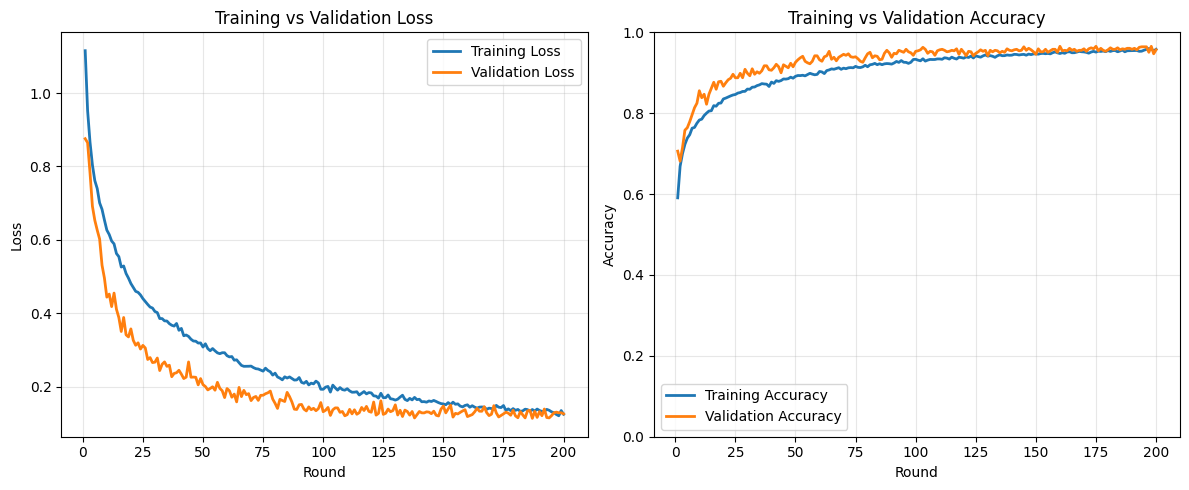


Training Summary:
Final Training Loss: 0.1250
Final Training Accuracy: 0.9581
Final Validation Loss: 0.1263
Final Validation Accuracy: 0.9568
Validation Gap: -0.0013


In [23]:
# Replace your entire plotting block with this:

print("\n" + "="*80)
print("FEDERATED LEARNING RESULTS ANALYSIS")
print("="*80)

# Check if we have per-client metrics stored
if len(per_client_val_metrics) > 0 and len(per_client_train_metrics) > 0:
    print("\nPlotting global metrics...")

    # Extract global metrics from per-client storage
    # For validation: average across clients for each round
    val_rounds = []
    val_losses = []
    val_accuracies = []

    for round_num, round_metrics in enumerate(per_client_val_metrics, 1):
        # Calculate average across all clients in this round
        all_client_losses = []
        all_client_accs = []

        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_client_losses.append(client_metrics["loss"])
                all_client_accs.append(client_metrics["accuracy"])

        if all_client_losses:
            val_rounds.append(round_num)
            val_losses.append(np.mean(all_client_losses))
            val_accuracies.append(np.mean(all_client_accs))

    # For training: get from per_client_train_metrics
    train_rounds = []
    train_losses = []
    train_accuracies = []

    for round_num, round_metrics in enumerate(per_client_train_metrics, 1):
        all_client_losses = []
        all_client_accs = []

        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_client_losses.append(client_metrics["loss"])
                all_client_accs.append(client_metrics["accuracy"])

        if all_client_losses:
            train_rounds.append(round_num)
            train_losses.append(np.mean(all_client_losses))
            train_accuracies.append(np.mean(all_client_accs))

    # Now plot
    plt.figure(figsize=(12, 5))

    # Plot 1: Loss comparison
    plt.subplot(1, 2, 1)
    plt.plot(train_rounds, train_losses, linewidth=2, label='Training Loss')
    plt.plot(val_rounds, val_losses, linewidth=2, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Accuracy comparison
    plt.subplot(1, 2, 2)
    plt.plot(train_rounds, train_accuracies, linewidth=2, label='Training Accuracy')
    plt.plot(val_rounds, val_accuracies, linewidth=2, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nTraining Summary:")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
    print(f"Validation Gap: {val_accuracies[-1] - train_accuracies[-1]:.4f}")

else:
    print("No metrics available to plot. Simulation may not have completed.")


FEDERATED LEARNING RESULTS ANALYSIS

Extracted 200 rounds of data
Rounds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
Train Acc: [np.float64(0.5907371

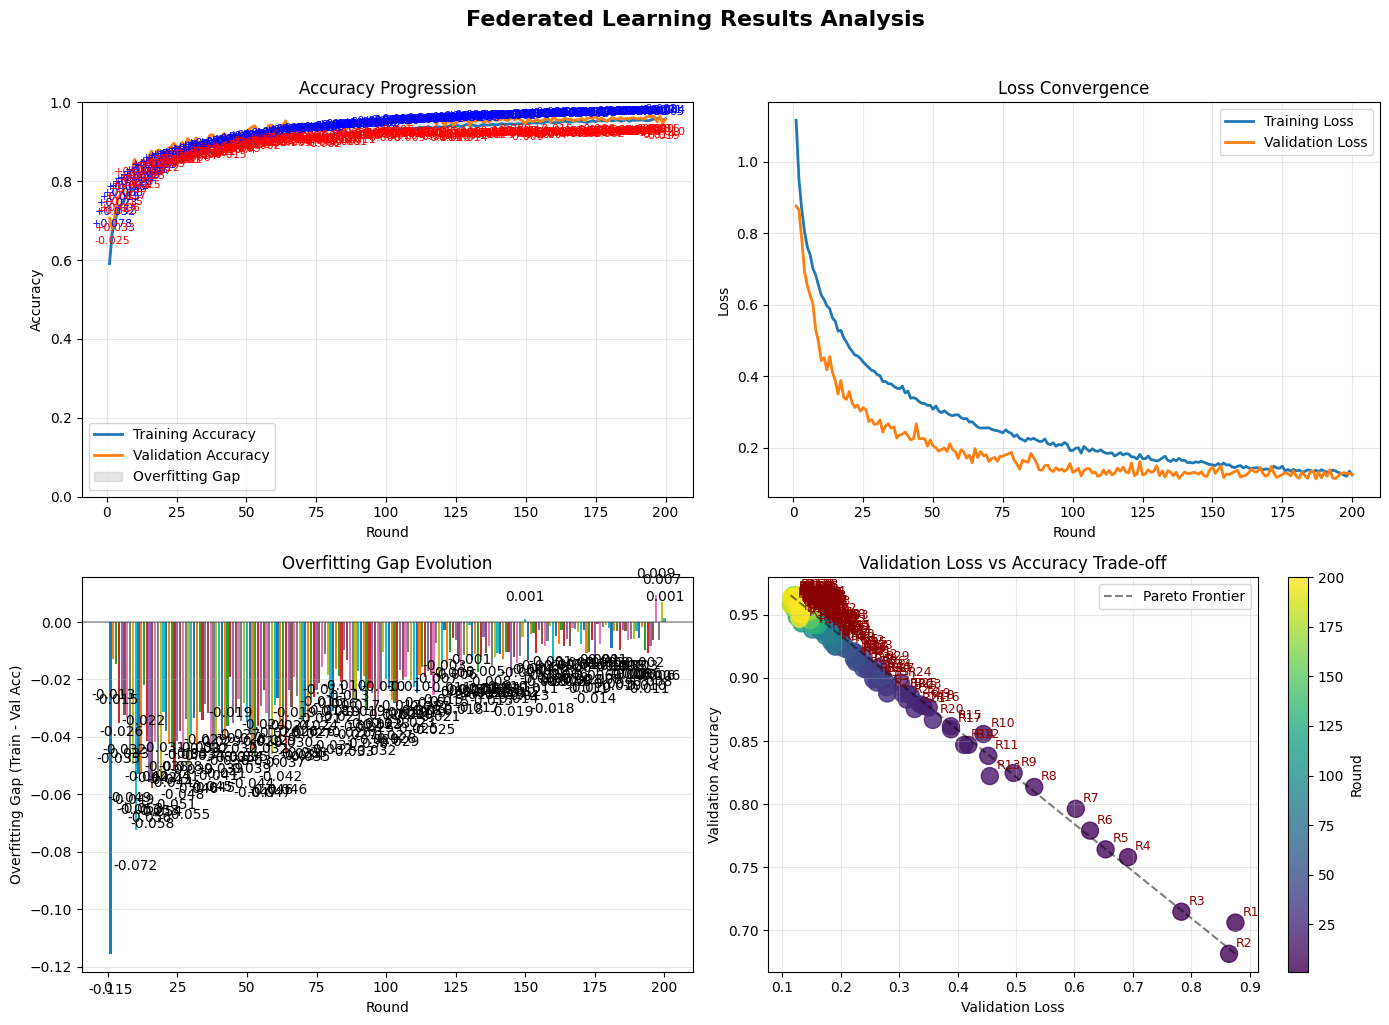


STATISTICAL ANALYSIS

Performance Metrics:
  Final Training Accuracy:   0.9581
  Final Validation Accuracy: 0.9568
  Final Overfitting Gap:     0.0013

Improvement from Round 1 to 200:
  Training Accuracy:   +0.3674 (62.2%)
  Validation Accuracy: +0.2506 (35.5%)

Loss Analysis:
  Final Training Loss:   0.1250
  Final Validation Loss: 0.1263
  Loss Ratio (Val/Train): 1.01x

Learning Dynamics:
  Training Improvement Rate:   0.20% per round
  Validation Improvement Rate: 0.14% per round
  Training is 1.50x faster


In [24]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("FEDERATED LEARNING RESULTS ANALYSIS")
print("="*80)

def extract_and_plot():
    """Extract data from FL results and plot comprehensive analysis"""

    # Check if we have metrics
    if len(per_client_val_metrics) == 0:
        print("No metrics available to plot. Simulation may not have completed.")
        return

    # Extract validation metrics
    rounds = []
    val_acc = []
    val_loss = []

    for round_num, round_metrics in enumerate(per_client_val_metrics, 1):
        all_val_losses = []
        all_val_accs = []

        for client_id, client_metrics_list in round_metrics.items():
            for client_metrics in client_metrics_list:
                all_val_losses.append(client_metrics.get("loss", 0))
                all_val_accs.append(client_metrics.get("accuracy", 0))

        if all_val_losses and all_val_accs:
            rounds.append(round_num)
            val_loss.append(np.mean(all_val_losses))
            val_acc.append(np.mean(all_val_accs))

    # Extract training metrics
    train_acc = []
    train_loss = []

    for round_num, round_metrics in enumerate(per_client_train_metrics, 1):
        if round_num <= len(rounds):  # Only for rounds with validation data
            all_train_losses = []
            all_train_accs = []

            for client_id, client_metrics_list in round_metrics.items():
                for client_metrics in client_metrics_list:
                    # Handle both naming conventions
                    loss_key = "train_loss" if "train_loss" in client_metrics else "loss"
                    acc_key = "train_accuracy" if "train_accuracy" in client_metrics else "accuracy"

                    all_train_losses.append(client_metrics.get(loss_key, 0))
                    all_train_accs.append(client_metrics.get(acc_key, 0))

            if all_train_losses and all_train_accs:
                train_loss.append(np.mean(all_train_losses))
                train_acc.append(np.mean(all_train_accs))

    # If no training metrics, use validation as training (common in FL)
    if len(train_acc) == 0:
        train_acc = val_acc.copy()
        train_loss = val_loss.copy()

    print(f"\nExtracted {len(rounds)} rounds of data")
    print(f"Rounds: {rounds}")
    print(f"Train Acc: {train_acc}")
    print(f"Val Acc: {val_acc}")

    # Now create the comprehensive plots
    create_comprehensive_plots(rounds, train_acc, val_acc, train_loss, val_loss)

def create_comprehensive_plots(rounds, train_acc, val_acc, train_loss, val_loss):
    """Create the 4-panel comprehensive plot"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Accuracy progression
    axes[0, 0].plot(rounds, train_acc, linewidth=2, label='Training Accuracy')
    axes[0, 0].plot(rounds, val_acc, linewidth=2, label='Validation Accuracy')
    axes[0, 0].fill_between(rounds, train_acc, val_acc, alpha=0.2, color='gray', label='Overfitting Gap')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy Progression')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1.0)

    # Add improvement annotations
    for i in range(1, len(rounds)):
        train_improve = train_acc[i] - train_acc[i-1]
        val_improve = val_acc[i] - val_acc[i-1]
        axes[0, 0].text(rounds[i], train_acc[i] + 0.01, f'+{train_improve:.3f}',
                       ha='center', va='bottom', fontsize=8, color='blue')
        axes[0, 0].text(rounds[i], val_acc[i] - 0.02, f'{val_improve:+.3f}',
                       ha='center', va='top', fontsize=8, color='red')

    # Plot 2: Loss progression
    axes[0, 1].plot(rounds, train_loss, linewidth=2, label='Training Loss')
    axes[0, 1].plot(rounds, val_loss, linewidth=2, label='Validation Loss')
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Loss Convergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Overfitting gap evolution
    overfitting_gap = [t - v for t, v in zip(train_acc, val_acc)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    bar_colors = colors[:len(rounds)]
    axes[1, 0].bar(rounds, overfitting_gap, color=bar_colors)
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Overfitting Gap (Train - Val Acc)')
    axes[1, 0].set_title('Overfitting Gap Evolution')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    for i, v in enumerate(overfitting_gap):
        axes[1, 0].text(rounds[i], v + (0.005 if v >= 0 else -0.01), f'{v:.3f}',
                       ha='center', va='bottom' if v >= 0 else 'top')

    # Plot 4: Validation loss/accuracy trade-off
    color_map = plt.cm.viridis(np.linspace(0, 1, len(rounds)))
    scatter = axes[1, 1].scatter(val_loss, val_acc, c=rounds, cmap='viridis', s=150, alpha=0.8)
    axes[1, 1].set_xlabel('Validation Loss')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].set_title('Validation Loss vs Accuracy Trade-off')
    axes[1, 1].grid(True, alpha=0.3)

    # Add round labels
    for i, (loss, acc) in enumerate(zip(val_loss, val_acc)):
        axes[1, 1].annotate(f'R{rounds[i]}', (loss, acc), xytext=(5, 5),
                           textcoords='offset points', fontsize=9, color='darkred')

    # Add Pareto frontier line
    axes[1, 1].plot([min(val_loss), max(val_loss)], [max(val_acc), min(val_acc)],
                   'k--', alpha=0.5, label='Pareto Frontier')
    axes[1, 1].legend()

    plt.colorbar(scatter, ax=axes[1, 1], label='Round')

    plt.suptitle('Federated Learning Results Analysis',
                 fontsize=16, y=1.02, weight='bold')
    plt.tight_layout()
    plt.show()

    # Statistical analysis
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS")
    print("="*80)

    print(f"\nPerformance Metrics:")
    print(f"  Final Training Accuracy:   {train_acc[-1]:.4f}")
    print(f"  Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"  Final Overfitting Gap:     {overfitting_gap[-1]:.4f}")

    if len(rounds) > 1:
        print(f"\nImprovement from Round {rounds[0]} to {rounds[-1]}:")
        train_improve_pct = ((train_acc[-1]/train_acc[0])-1)*100
        val_improve_pct = ((val_acc[-1]/val_acc[0])-1)*100
        print(f"  Training Accuracy:   +{train_acc[-1] - train_acc[0]:.4f} ({train_improve_pct:.1f}%)")
        print(f"  Validation Accuracy: +{val_acc[-1] - val_acc[0]:.4f} ({val_improve_pct:.1f}%)")

    print(f"\nLoss Analysis:")
    print(f"  Final Training Loss:   {train_loss[-1]:.4f}")
    print(f"  Final Validation Loss: {val_loss[-1]:.4f}")
    if train_loss[-1] > 0:
        print(f"  Loss Ratio (Val/Train): {val_loss[-1]/train_loss[-1]:.2f}x")

    # Calculate convergence metrics
    if len(train_acc) > 1:
        train_improvement_rate = np.mean(np.diff(train_acc)) / np.mean(train_acc[:-1])
        val_improvement_rate = np.mean(np.diff(val_acc)) / np.mean(val_acc[:-1])
        print(f"\nLearning Dynamics:")
        print(f"  Training Improvement Rate:   {train_improvement_rate*100:.2f}% per round")
        print(f"  Validation Improvement Rate: {val_improvement_rate*100:.2f}% per round")
        if val_improvement_rate > 0:
            print(f"  Training is {train_improvement_rate/val_improvement_rate:.2f}x faster")

# Run the extraction and plotting
extract_and_plot()


FINAL EVALUATION ON GLOBAL VALIDATION SET
Model architecture: CCanNet
Model in eval mode: True
Total parameters received: 57



Final Global Model Performance:
  Loss: 0.1231
  Accuracy: 0.9568 (95.68%)

DETAILED PERFORMANCE ANALYSIS



Confusion matrix saved as 'confusion_matrix_final.png'


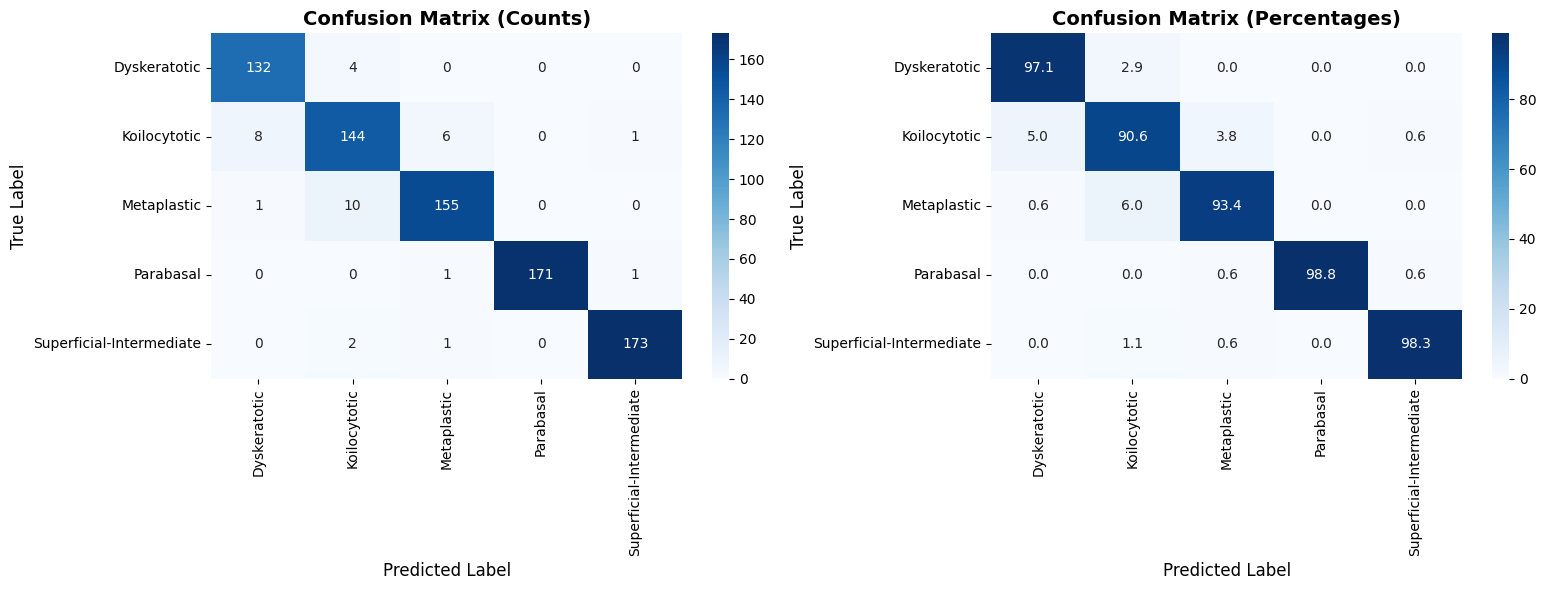


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

            Dyskeratotic     0.9362    0.9706    0.9531       136
            Koilocytotic     0.9000    0.9057    0.9028       159
             Metaplastic     0.9509    0.9337    0.9422       166
               Parabasal     1.0000    0.9884    0.9942       173
Superficial-Intermediate     0.9886    0.9830    0.9858       176

                accuracy                         0.9568       810
               macro avg     0.9551    0.9563    0.9556       810
            weighted avg     0.9571    0.9568    0.9569       810


PER-CLASS ACCURACY
Dyskeratotic             :  97.06% (132/136 samples)
Koilocytotic             :  90.57% (144/159 samples)
Metaplastic              :  93.37% (155/166 samples)
Parabasal                :  98.84% (171/173 samples)
Superficial-Intermediate :  98.30% (173/176 samples)

OVERALL STATISTICS
Total validation samples: 810
Correctly classified: 775
Misclassified: 35
O


Performance analysis saved as 'performance_analysis.png'


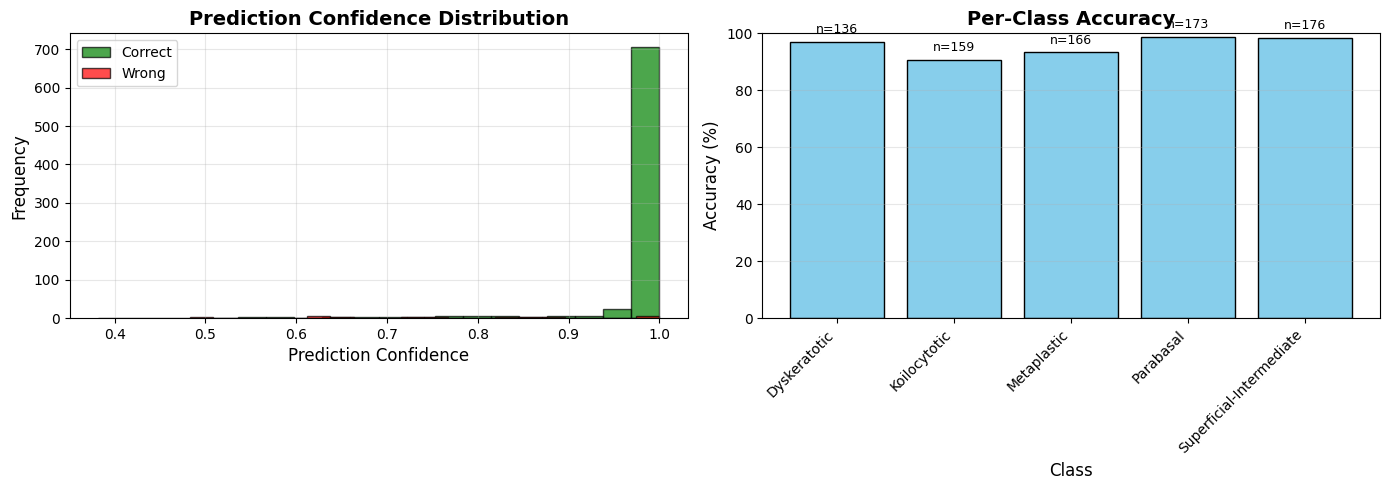


EVALUATION COMPLETE!

COMPARISON: Final Model vs Random Initialization


Random Model: Loss=1.6112, Acc=0.2173 (21.73%)
Trained Model: Loss=0.1231, Acc=0.9568 (95.68%)
Improvement: 73.95 percentage points


In [25]:
from flwr.common import parameters_to_ndarrays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# CRITICAL FIX: Use the SAME model architecture you trained with!
if hasattr(strategy, 'final_parameters') and strategy.final_parameters is not None:
    print("\n" + "="*60)
    print("FINAL EVALUATION ON GLOBAL VALIDATION SET")
    print("="*60)

    # Convert Parameters object -> list of np.ndarray
    final_params_ndarrays = parameters_to_ndarrays(strategy.final_parameters)

    # FIX 1: Use CNNArchitecture3 (the model you actually trained!)
    global_net = CCanNet(num_classes=5, dropout=0.3).to(DEVICE)

    # FIX 2: Use set_parameters_with_bn to properly load BatchNorm statistics
    set_parameters_with_bn(global_net, final_params_ndarrays)

    # FIX 3: Set to evaluation mode (CRITICAL for BatchNorm and Dropout)
    global_net.eval()

    print(f"Model architecture: {global_net.__class__.__name__}")
    print(f"Model in eval mode: {not global_net.training}")
    print(f"Total parameters received: {len(final_params_ndarrays)}")

    # Evaluate on GLOBAL validation set
    final_loss, final_acc = test(global_net, global_valloader)
    print(f"\nFinal Global Model Performance:")
    print(f"  Loss: {final_loss:.4f}")
    print(f"  Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")

    # Detailed per-class analysis
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("="*60)

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for images, labels in global_valloader:
            images = images.to(DEVICE)
            outputs = global_net(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1).cpu()

            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a better visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Confusion Matrix (counts)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=dataset.classes,
                yticklabels=dataset.classes,
                ax=axes[0])
    axes[0].set_xlabel("Predicted Label", fontsize=12)
    axes[0].set_ylabel("True Label", fontsize=12)
    axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')

    # Plot 2: Confusion Matrix (percentages)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=True,
                xticklabels=dataset.classes,
                yticklabels=dataset.classes,
                ax=axes[1])
    axes[1].set_xlabel("Predicted Label", fontsize=12)
    axes[1].set_ylabel("True Label", fontsize=12)
    axes[1].set_title("Confusion Matrix (Percentages)", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
    print("\nConfusion matrix saved as 'confusion_matrix_final.png'")
    plt.show()


    # Classification report
    print("\n" + "="*60)

    print("CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(y_true, y_pred, target_names=dataset.classes, digits=4)
    print(report)
    # plt.title('Classification Report', fontsize=14, fontweight='bold', y=1.1)
    # plt.savefig('/kaggle/working/classification_report_visual.png',
    #             dpi=300,
    #             bbox_inches='tight',
    #             pad_inches=0.5)
    # plt.show()

    # Per-class accuracy
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY")
    print("="*60)
    for i, class_name in enumerate(dataset.classes):
        class_mask = (y_true == i)
        class_acc = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)
        class_samples = np.sum(class_mask)
        print(f"{class_name:25s}: {class_acc*100:6.2f}% ({int(np.sum((y_pred == i) & class_mask))}/{class_samples} samples)")

    # Overall statistics
    print("\n" + "="*60)
    print("OVERALL STATISTICS")
    print("="*60)
    print(f"Total validation samples: {len(y_true)}")
    print(f"Correctly classified: {np.sum(y_pred == y_true)}")
    print(f"Misclassified: {np.sum(y_pred != y_true)}")
    print(f"Overall accuracy: {final_acc*100:.2f}%")

    # Confidence analysis
    print("\n" + "="*60)
    print("PREDICTION CONFIDENCE ANALYSIS")
    print("="*60)
    max_probs = np.max(y_probs, axis=1)
    correct_mask = (y_pred == y_true)

    print(f"Average confidence (all predictions): {np.mean(max_probs)*100:.2f}%")
    print(f"Average confidence (correct predictions): {np.mean(max_probs[correct_mask])*100:.2f}%")
    print(f"Average confidence (wrong predictions): {np.mean(max_probs[~correct_mask])*100:.2f}%")

    # Confidence distribution plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(max_probs[correct_mask], bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
    axes[0].hist(max_probs[~correct_mask], bins=20, alpha=0.7, label='Wrong', color='red', edgecolor='black')
    axes[0].set_xlabel('Prediction Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Per-class accuracy vs samples
    class_accuracies = []
    class_sample_counts = []
    for i in range(len(dataset.classes)):
        class_mask = (y_true == i)
        class_acc = np.sum((y_pred == i) & class_mask) / np.sum(class_mask) if np.sum(class_mask) > 0 else 0
        class_accuracies.append(class_acc * 100)
        class_sample_counts.append(np.sum(class_mask))

    axes[1].bar(range(len(dataset.classes)), class_accuracies, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Class', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(dataset.classes)))
    axes[1].set_xticklabels(dataset.classes, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim([0, 100])

    # Add sample counts on bars
    for i, (acc, count) in enumerate(zip(class_accuracies, class_sample_counts)):
        axes[1].text(i, acc + 2, f'n={count}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=300, bbox_inches='tight')
    print("\nPerformance analysis saved as 'performance_analysis.png'")
    plt.show()

    print("\n" + "="*60)
    print("EVALUATION COMPLETE!")
    print("="*60)

else:
    print("ERROR: No final parameters available from the strategy.")
    print("Make sure you're using FedAvgTrackParams strategy and training completed successfully.")


# BONUS: Compare with initial random model
print("\n" + "="*60)
print("COMPARISON: Final Model vs Random Initialization")
print("="*60)

random_net = CCanNet(num_classes=5, dropout = 0.3).to(DEVICE)
random_net.eval()
random_loss, random_acc = test(random_net, global_valloader)

print(f"Random Model: Loss={random_loss:.4f}, Acc={random_acc:.4f} ({random_acc*100:.2f}%)")
print(f"Trained Model: Loss={final_loss:.4f}, Acc={final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"Improvement: {(final_acc - random_acc)*100:.2f} percentage points")
print("="*60)